# scRNAseq Data Exploration with Seurat
- Author: Samantha Yuen
- Date started: 2021-03-29
- Date completed:

script based on Dr. Yoshiaki Tanaka's `seurat_brainYT.R` and `all_go_analysis_v2_symbol.R`

## About dataset

[scRNAseq of retrotransposon from adult GBM BAM dataset](https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP227039)
- scRNAseq from 9 glioblastoma tumors split into a total of 287 SRAs (sequence read archive) and 12 bam files. 
    - Illumina HiSeq 2000
    - Fluidigm C1 capture, SmartSeq v2 library prep
        - no UMI, so true proportion of mRNAs in each cell is lost  <cite data-cite="7065199/2PYTKX26"></cite><div class="cite2c-biblio"></div>
            - [ ] How is there nFeature_RNA column in @metadata if the sequencing method shouldn't have any?
        - Full mRNA sequence is preserved after tagmentation (no random tagmentation)
- Expecting to get human cancer stem-like cells, vascular cells, immune cells. This includes glia-like cells. 
- 36601 unfiltered genes & 60065 unfiltered cells
    - see `/outs/web_summary.html` for a rough analysis of what this dataset contains. 
    - We ended up with 30244 genes and 59540 cells, after filtering for low complexity cells (<100 genes) and genes with no counts (<1 cell

In [1]:
.libPaths(c("/scratch/samkyy/gete-gbm/renv/library/R-4.0/x86_64-pc-linux-gnu","/tmp/RtmpJsRC8Z/renv-system-library", .libPaths()))

In [2]:
.libPaths()

[1] "/scratch/samkyy/gete-gbm/renv/library/R-4.0/x86_64-pc-linux-gnu"                       
[2] "/home/samkyy/R/x86_64-pc-linux-gnu-library/4.0"                                        
[3] "/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/r/4.0.2/lib64/R/library"

In [3]:
resultsPath <- "~/scratch/gete-gbm/results"

In [4]:
#dir.create(file.path("/home/samkyy/scratch/gete-gbm/results/", "/2021-04-19")) 

### Function: create directory with current date (2021-04-23)

mkdirToday <- function(){
    print(paste0("Current working directory: ", getwd()))
    
    maindir <- resultsPath
    subdir <- format(Sys.Date(), "%Y-%m-%d")
    
    dir.create(file.path(maindir, subdir))
    setwd(file.path(maindir, subdir))
    
    print(paste0("New working directory: ", getwd()))
}

setwdToday <- function() {
    print(paste0("Current working directory: ", getwd()))
    maindir <- resultsPath
    subdir <- format(Sys.Date(), "%Y-%m-%d")
    
    setwd(file.path(maindir, subdir))
    
    print(paste0("New working directory: ", getwd()))
}

## Install, Load Libraries, and load variables

### Load Libraries & variables from previous sessions

In [5]:
library(Seurat)
library(Matrix)
library(ggplot2)
library(cowplot)
library(genefilter)

Attaching SeuratObject



In [6]:
# library(tidyverse)
# library(RCurl)
# library(scales)
# library(SingleCellExperiment)
library(AnnotationHub)
library(ensembldb)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: BiocFileCache

Loading required package: dbplyr

Bioconductor version '3.12' is out-of-da

In [7]:
# Packages for figure layout formatting
library(grid)
library(gridExtra)


Attaching package: 'gridExtra'


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:BiocGenerics':

    combine




In [8]:
# Packages for Gene Ontology
library(GOstats)
library(org.Hs.eg.db)

Loading required package: Category

Loading required package: graph




Attaching package: 'GOstats'


The following object is masked from 'package:AnnotationDbi':

    makeGOGraph






In [9]:
# pathResults = "/home/samkyy/scratch/RetroTransposonAnalysis/results"
# pathFigures = "/home/samkyy/scratch/RetroTransposonAnalysis/figures"
# pathData = "/home/samkyy/scratch/RetroTransposonAnalysis/cellranger_outputs"
# pathQCData = "/home/samkyy/scratch/RetroTransposonAnalysis/code/data"
getwd()

[1] "/scratch/samkyy/gete-gbm/results"

In [5]:
# load the count matrix created in sections 3 to 4.1
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinednf_brain_seurat.RData")
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/2021-03-25.RData")

# load combinednf_brain and combinedTE_brain
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinednf_brain_seurat-03-29.RData")
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinedTE_brain_seurat-03-29.RData")
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/gte_brain_seurat-03-30.RData")
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combined_GE_select_seurat-03-30.RData")

In [5]:
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain_seurat-03-31.RData")
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select_seurat-03-31.RData")

In [8]:
load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")

## Load & Merge aggregated scRNA-seq brain tumor data

File should contain these files: barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz
- *cell IDs*:  column names
- *gene IDs*: row names (vary depending on the reference used to quantify the reads *ie* Ensembl(GrCh38), NCBI, UCSC (hg38))
- *matrix of counts* per gene for every cell 

The loaded data is now a **(sparse) count matrix** that saves space, memory and CPU required to manipulate the matrix. We will use `Read10X()` function which combines loading and sparse matrix generation together, unlike `readMM()` where we still need to load the matrix into R first. 

[Single-cell RNA-seq: Quality Control Analysis | Introduction to Single-cell RNA-seq](https://hbctraining.github.io/scRNA-seq/lessons/03_SC_quality_control-setup.html)

In [50]:
# load filtered and unfiltered scRNAseq data mapped to reference genome

#combined_f <- Read10X("/home/samkyy/scratch/RetroTransposonAnalysis/cellranger_outputs/aggr_mapped/outs/count/filtered_feature_bc_matrix")
combined_nf <- Read10X("/home/samkyy/scratch/RetroTransposonAnalysis/cellranger_outputs/aggr_none/outs/count/filtered_feature_bc_matrix")

In [6]:
#dim(combined_f)
dim(combined_nf)

[1] 36601 60065

In [118]:
# repeat steps for retrotransposon mapping
combined_TE <- Read10X("/home/samkyy/scratch/RetroTransposonAnalysis/cellranger_outputs/aggrRT_none/outs/count/filtered_feature_bc_matrix")
dim(combined_TE) #row genes by col cells

[1]  1180 37204

### Create Seurat object
counts will be normalized here

`CreateSeuratObject(counts, project name, assay, min.cells, min.features)`
- `counts`: Unnormalized data such as raw counts or TPMs
- `assay`: Name of the assay according to the initial input data, by default = RNA
- `min.cells`: include features only if they contain a certain number of cells
    - 1 -- remove genes with no counts <cite data-cite="7065199/MYE4IIIV"></cite>
- `min.features`: include cells only if they contain a certain number of features
    - [100 is the standard](https://hbctraining.github.io/scRNA-seq/lessons/03_SC_quality_control-setup.html)
    - 1000 was used in <cite data-cite="7065199/MYE4IIIV"></cite>, however it uses Single Cell 3’ Reagent Kits v2 User Guide (CG0052 10x) chemistry, and so has Barcode + UMI. 
Genomics)
- `names.field`: Adjust the cell name if contains different sections (e.g. BARCODE_CLUSTER_CELLTYPE), this dataset only has the barcode number, so any number would redefine as the BARCODE. 
- `names.delim`: depeneding on how the BARCODE_CLUSTER_CELLTYPE is separated, use that to split the string. 

[For more info on the CreateSeuratObject function](https://www.rdocumentation.org/packages/Seurat/versions/3.1.1/topics/CreateSeuratObject)

In [16]:
# create seurat object for filtered reads & save the cell id's

# combinedf_brain <- CreateSeuratObject(counts=combined_f,project="combined_filtered",
#                                       names.field = 2,names.delim = "-", min.features = 100, min.cells = 1)
# orig_id_f <- combinedf_brain@meta.data$orig.ident
# names(orig_id_f) <- rownames(combinedf_brain@meta.data)

# create seurat object for unfiltered reads & save the cell id's

combinednf_brain <- CreateSeuratObject(counts=combined_nf,project="combined_unfiltered",
                                       names.field = 2,names.delim = "-", min.features = 100, min.cells = 1)
orig_id_nf <- combinednf_brain@meta.data$orig.ident
names(orig_id_nf) <- rownames(combinednf_brain@meta.data)

In [117]:
# create seurat object for aggregated unfiltered TE reads
combinedTE_brain <- CreateSeuratObject(counts=combined_TE,project="combined_nfTE",
                                       names.field = 2,names.delim = "-", min.features = 100, min.cells = 1)
orig_id_TE <- combinedTE_brain@meta.data$orig.ident
names(orig_id_TE) <- rownames(combinedTE_brain@meta.data)

Warning message:
"Non-unique cell names (colnames) present in the input matrix, making unique"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


We will be using the **unfiltered datasets** until the filtered dataset is needed.

In [30]:
print("MetaData of Datasets mapped to reference genome")
head(combinednf_brain@meta.data)
tail(combinednf_brain@meta.data)
dim(combinednf_brain@meta.data) # 59540 cells from reference genome mapped samples

print("MetaData of Datasets mapped to retrotransposon reference")
head(combinedTE_brain@meta.data)
tail(combinedTE_brain@meta.data)
dim(combinedTE_brain@meta.data) # 37022 cells from reference genome mapped samples

[1] "MetaData of Datasets mapped to reference genome"


orig.ident nCount_RNA nFeature_RNA
AAACCTGCAATTCCTT-1 1          11916      4509        
AAACCTGCACAGAGGT-1 1           4061      1671        
AAACCTGGTGTGGCTC-1 1           4314      2102        
AAACGGGGTCCGAATT-1 1           7251      2943        
AAACGGGTCGAATGGG-1 1           1708      1049        
AAAGATGAGGGTATCG-1 1           2177       878

orig.ident nCount_RNA nFeature_RNA
TTTGTCACAGTCAGAG-12 12          688        569        
TTTGTCAGTACCGTAT-12 12         2334       1401        
TTTGTCAGTCTAGAGG-12 12         9840       3483        
TTTGTCAGTGAGCGAT-12 12         2393       1314        
TTTGTCATCATAACCG-12 12          598        327        
TTTGTCATCCGTAGGC-12 12         4028       2107

[1] 59540     3

[1] "MetaData of Datasets mapped to retrotransposon reference"


orig.ident nCount_RNA nFeature_RNA
AAACCTGCAGTGAGTG-1 1           2209      264         
AAACCTGGTAGGCTGA-1 1           3240      285         
AAACCTGGTATGAATG-1 1           4790      349         
AAACGGGAGCCATCGC-1 1           3692      296         
AAACGGGCATCGGACC-1 1           6549      383         
AAACGGGGTAGCGATG-1 1          11792      457

orig.ident nCount_RNA nFeature_RNA
TTTGTCACATAGGATA-12 12         3391       269         
TTTGTCAGTCTTGATG-12 12         2986       238         
TTTGTCAGTGGTGTAG-12 12         1050       173         
TTTGTCAGTTATGTGC-12 12          815       150         
TTTGTCAGTTCCAACA-12 12         3091       259         
TTTGTCATCGCGTTTC-12 12         1327       172

[1] 37022     3

- `orig.ident`: sample name (defaulted to numbers used in mapping probably)
- `nCount_RNA`: # UMI's per cell
- `nFeature_RNA`: # genes detected per cell

### Combine Genes + Retrotransposons into one Seurat Object

In [121]:
# rename colnames of retrotransposon to match those of reference genes
for(i in 1:length(combined_TE[1,])){
    if ( str_detect(colnames(combined_TE)[i], "-1$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-1$", "-11")
    } else if ( str_detect(colnames(combined_TE)[i], "-2$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-2$", "-5")
    } else if ( str_detect(colnames(combined_TE)[i], "-3$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-3$", "-1")
    } else if ( str_detect(colnames(combined_TE)[i], "-4$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-4$", "-12")
    } else if ( str_detect(colnames(combined_TE)[i], "-5$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-5$", "-6")
    } else if ( str_detect(colnames(combined_TE)[i], "-6$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-6$", "-2")
    } else if ( str_detect(colnames(combined_TE)[i], "-7$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-7$", "-3")
    } else if ( str_detect(colnames(combined_TE)[i], "-8$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-8$", "-9")
    } else if ( str_detect(colnames(combined_TE)[i], "-9$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-9$", "-8")
    } else if ( str_detect(colnames(combined_TE)[i], "-10$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-10$", "-7")
    } else if ( str_detect(colnames(combined_TE)[i], "-11$") ) {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-11$", "-4")
    } else {
        colnames(combined_TE)[i] <- str_replace(colnames(combined_TE)[i], "-12$", "-10")        
    }
}

# length(combined_TE[1,]) # 37204 cells in the original retrotransposon sparse matrix

In [122]:
# find intersecting cell names between genes and retrotransposon datasets
cellnames <- intersect(colnames(combined_nf),colnames(combined_TE))
    # length(cellnames) # 37104 cells will be present in the combined sparse matrix
combinedgte_brain <- rbind(combined_nf[,cellnames],combined_TE[,cellnames])

In [123]:
# Create Seurat Object with genes + retrotransposons combined
gte_brain <- CreateSeuratObject(counts=combinedgte_brain,project="combined_GenesRetrotransposons",
                                       names.field = 2,names.delim = "-", min.features = 100, min.cells = 1)
orig_id_gte <- gte_brain@meta.data$orig.ident
names(orig_id_gte) <- rownames(gte_brain@meta.data)

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [135]:
head(gte_brain@meta.data)
tail(gte_brain@meta.data)
dim(gte_brain@meta.data) # 37104 cells from reference genome mapped samples

orig.ident nCount_RNA nFeature_RNA
AAACCTGCAATTCCTT-1 1          16712      4840        
AAACCTGCACAGAGGT-1 1           5963      1850        
AAACCTGGTGTGGCTC-1 1           7866      2355        
AAACGGGGTCCGAATT-1 1          14361      3262        
AAACGGGTCGAATGGG-1 1           2803      1201        
AAAGATGAGGGTATCG-1 1           6653      1116

orig.ident nCount_RNA nFeature_RNA
TTTGTCACACCTCGTT-12 12          6778      2179        
TTTGTCACAGCTATTG-12 12          4930      1582        
TTTGTCAGTACCGTAT-12 12          4235      1613        
TTTGTCAGTCTAGAGG-12 12         15473      3825        
TTTGTCAGTGAGCGAT-12 12          3701      1494        
TTTGTCATCCGTAGGC-12 12          7391      2382

[1] 37104     3

## Quality Control & Filtration

### Generate Quality Metrics
- `number of genes detected per UMI`: More genes detected per UMI, the more complex our data
- `mitochondrial ratio`: Percent of genes originating from the mitochondria
    - The pattern provided (“^MT-“) works for human gene names, so check what the pattern is if working with other organims, depending on the reference genome used, the prefix for mitochondrial genes may be different too: (ie “mt-“, “mt.”, or “MT_”...)

Doublet removal will be done when cellular markers show inconsistencies (belong to more than one cell type). [Single-cell RNA-seq: Quality Control Analysis | Introduction to Single-cell RNA-seq - ARCHIVED](https://hbctraining.github.io/scRNA-seq/lessons/04_SC_quality_control.html)

In [31]:
# number of genes per UMI
combinednf_brain$log10GenesPerUMI <- log10(combinednf_brain$nFeature_RNA) / log10(combinednf_brain$nCount_RNA)
head(combinednf_brain$log10GenesPerUMI)

# do the same for TE dataset
combinedTE_brain$log10GenesPerUMI <- log10(combinedTE_brain$nFeature_RNA) / log10(combinedTE_brain$nCount_RNA)
head(combinedTE_brain$log10GenesPerUMI)

AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1 AAACGGGGTCCGAATT-1 
         0.8964581          0.8931295          0.9140969          0.8985577 
AAACGGGTCGAATGGG-1 AAAGATGAGGGTATCG-1 
         0.9345048          0.8818512

AAACCTGCAGTGAGTG-1 AAACCTGGTAGGCTGA-1 AAACCTGGTATGAATG-1 AAACGGGAGCCATCGC-1 
         0.7241215          0.6992774          0.6909222          0.6927700 
AAACGGGCATCGGACC-1 AAACGGGGTAGCGATG-1 
         0.6769078          0.6532873

In [32]:
# mitochondrial ratio
combinednf_brain$mitoRatio <- PercentageFeatureSet(object = combinednf_brain, pattern = "^MT-")
combinednf_brain$mitoRatio <- combinednf_brain@meta.data$mitoRatio / 100

#do the same for TE dataset
combinedTE_brain$mitoRatio <- PercentageFeatureSet(object = combinedTE_brain, pattern = "^MT-")
combinedTE_brain$mitoRatio <- combinedTE_brain@meta.data$mitoRatio / 100

In [33]:
head(combinednf_brain$mitoRatio)
head(combinedTE_brain$mitoRatio)

AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1 AAACGGGGTCCGAATT-1 
       0.008308157        0.068456045        0.070931850        0.084402151 
AAACGGGTCGAATGGG-1 AAAGATGAGGGTATCG-1 
       0.066159251        0.278824070

AAACCTGCAGTGAGTG-1 AAACCTGGTAGGCTGA-1 AAACCTGGTATGAATG-1 AAACGGGAGCCATCGC-1 
                 0                  0                  0                  0 
AAACGGGCATCGGACC-1 AAACGGGGTAGCGATG-1 
                 0                  0

makes sense that the TE mapped dataset doesn't have mitochondrial genes, because we're being specific to retrotransposons.

Rename metadata columns for downstream QC.
I skipped a step for adding sample conditions, because there were no conditions in this experiment.

In [128]:
# Create metadata dataframe
metadata_nf <- combinednf_brain@meta.data
metadata_TE <- combinedTE_brain@meta.data

# Add cell IDs to metadata
metadata_nf$cells <- rownames(metadata_nf)
metadata_TE$cells <- rownames(metadata_TE)

# Rename columns
# metadata_nf <- metadata_nf %>%
#         dplyr::rename(seq_folder = orig.ident,
#                       nUMI = nCount_RNA,
#                       nGene = nFeature_RNA)
# metadata_TE <- metadata_TE %>%
#         dplyr::rename(seq_folder = orig.ident,
#                       nUMI = nCount_RNA,
#                       nGene = nFeature_RNA)

In [26]:
#combinednf_brain@meta.data <- metadata_nf

# Create .RData to Load at any time
#save(combinednf_brain, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinednf_brain_seurat.RData")

Add original sample origin names to column sample 

In [37]:
sampleNames_ordered <- list("SF11159_1", "SF11159_2", "SF11209_GBM1", "SF11209_GBM2", "SF22215_GBM1", "SF22215_GBM2", "SF11232_1", "SF11232_2", "Tumor2_1", "Tumor2_2", "TQ1", "TQ2")
#sampleNames_nf <- list("SF11159_2", "SF11209_GBM1", "SF11209_GBM2","TQ2","SF22215_GBM2","SF11232_2","TQ1","SF22215_GBM1","SF11159_1","Tumor2_2","SF11232_1","Tumor2_1")
#sampleNames_TE <- list("SF11209_GBM1","SF11159_1","SF11159_2","Tumor2_1","SF22215_GBM1","SF11232_2","SF22215_GBM2", "SF11209_GBM2", "Tumor2_2", "SF11232_1", "TQ2", "TQ1")

In [20]:
#metadata_nf <- combinednf_brain@meta.data

In [130]:
# Create sample column
metadata_nf$sample <- NA
metadata_TE$sample <- NA

In [131]:
for(i in 1:length(sampleNames)) {
    metadata_nf$sample[which(metadata_nf$seq_folder == i)] <- sampleNames_nf[i]
    metadata_TE$sample[which(metadata_TE$seq_folder == i)] <- sampleNames_TE[i]
}

In [132]:
metadata_nf$seq_folder <- factor(metadata_nf$seq_folder, levels = c("9", "1", "2", "3", "8",
                                                 "5", "11", "6", "12", "10", "7", "4"))
# metadata_nf$sample <- factor(metadata_nf$sample, levels = sampleNames_ordered)

metadata_TE$seq_folder <- factor(metadata_TE$seq_folder, levels = c("8", "3", "6", "7", "9",
                                                 "2", "1", "5", "4", "12", "10", "11"))
# metadata_TE$sample <- factor(metadata_TE$sample, levels = sampleNames_ordered)

In [133]:
# Add metadata back to Seurat object
combinednf_brain@meta.data <- metadata_nf
combinedTE_brain@meta.data <- metadata_TE

In [184]:
#save.image('/home/samkyy/scratch/RetroTransposonAnalysis/code/data/2021-03-25.RData')
save(combinednf_brain, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinednf_brain_seurat-03-29.RData")
save(combinedTE_brain, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinedTE_brain_seurat-03-29.RData")

### Cell Counts

Droplet generation techniques have a capture efficiency of 70-80% which is considered high. However in 10x, the cell count can drop to 50-60%. Cell concentration at library preparation should be determined by hemocytometer / automated cell counter and not by FACS or Bioanalyzer.

In 10x experiments, emulsion droplets (GEMs) can contain:
- no cell, no bead
- cell, but no bead
- no cell, but one or more beads present *
- cell, and one (or more) bead present *

[* Starred scenarios can result the number of cells detected being higher than what was loaded.]

In [134]:
cellcount_nf <- combinednf_brain@meta.data %>%
    ggplot(aes(x=seq_folder, fill=seq_folder)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleNames_ordered) +
    scale_fill_discrete(labels = sampleNames_ordered) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    theme(plot.title = element_text(hjust=0.5, face="bold"))
#     ggtitle("Number of Cells")

cellcount_TE <- combinedTE_brain@meta.data %>%
    ggplot(aes(x=seq_folder, fill=seq_folder)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleNames_ordered) +
    scale_fill_discrete(labels = sampleNames_ordered) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    theme(plot.title = element_text(hjust=0.5, face="bold"))
#     ggtitle("Number of Cells")

In [135]:
# Save figure of cell count
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_cellcount.pdf", width = size*2, height = size)
grid.arrange(cellcount_nf, cellcount_TE, nrow = 1, top="Number of Cells per Dataset")
dev.off()

png 
  2

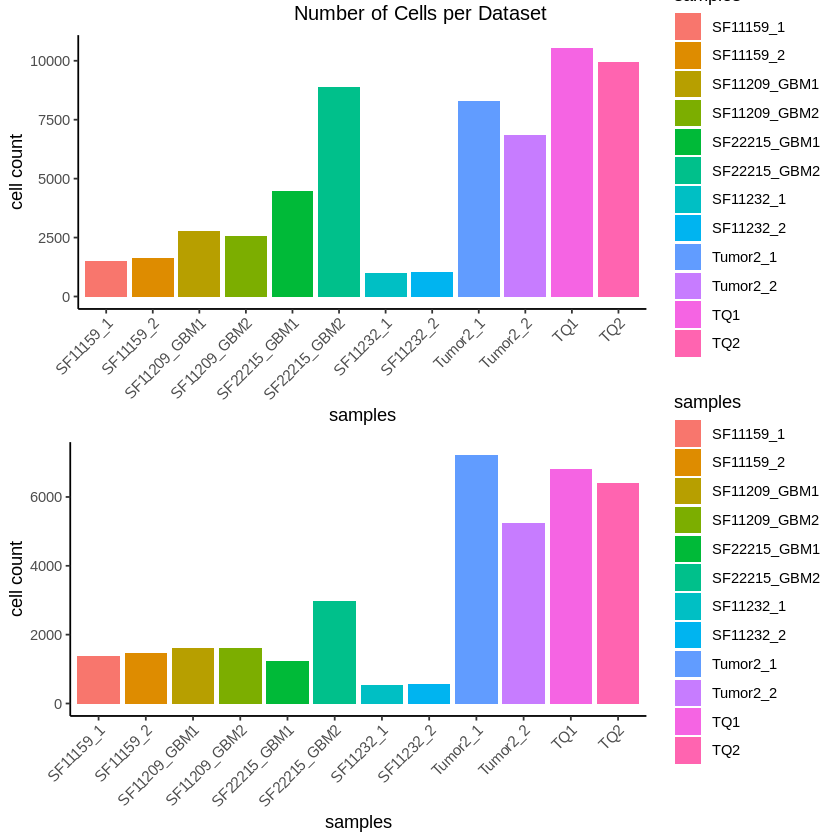

In [137]:
grid.arrange(cellcount_nf, cellcount_TE, nrow = 2, top="Number of Cells per Dataset")

There is a significant difference in cell count between replicates: 
- "SF22215_GBM1" and "SF22215_GBM2" (Greens)
- "Tumor2_1" and "Tumor2_2" 

Other samples seem to contain an equal number of cells. 

### UMI per Transcript

On the reference genome mapped samples, 500-1000 transcripts would be considered to shallow. If majority of cells have > 1000 unique transcripts then that would be acceptable.

In [170]:
# Visualize the number UMIs/transcripts per cell
umi_nf <- combinednf_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nUMI, fill=seq_folder)) + 
    labs(x = "UMI per Transcript (log10)", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10(labels = comma, limit=c(100, 100000)) + 
    theme_classic() +
    ggtitle("GRCh38") + theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(xintercept = c(500,1000))

umi_TE <- combinedTE_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nUMI, fill=seq_folder)) + 
    labs(x = "UMI per Transcript (log10)", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10(labels = comma, limit=c(100, 100000)) + 
    theme_classic() +
    ggtitle("Retrotransposons") + theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(xintercept = c(500,1000))

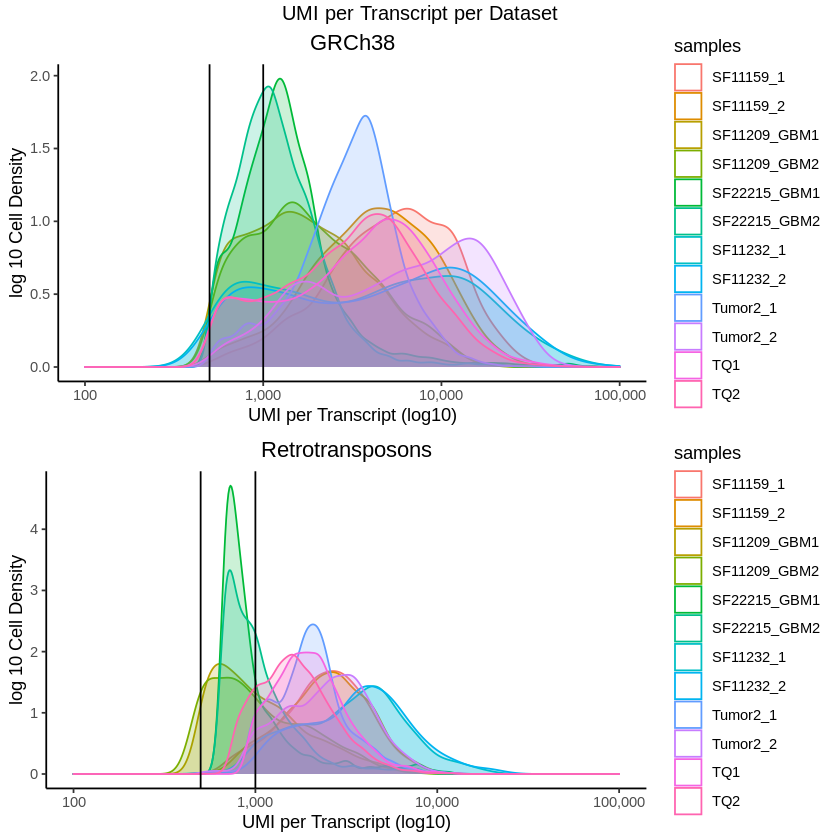

In [171]:
grid.arrange(umi_nf, umi_TE, nrow = 2, top="UMI per Transcript per Dataset")

Samples that had inconsistent cells also had low UMI per transcript. Here's a list of samples where majority of cell are below the standard 500 log10(UMI/transcript) cutoff point:
- "SF22215_GBM1" and "SF22215_GBM2" (Greens)
- "SF11209_GBM1" and "SF11209_GBM2" (Light Greens) - see retrotransposon mapped graph

In [172]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_umipertranscript.pdf", width = size*2, height = size)
grid.arrange(umi_nf, umi_TE, nrow = 1, top="UMI per Transcript per Dataset")
dev.off()

png 
  2

### Genes detected per cell

In [21]:
#reference 

# Visualize the distribution of genes detected per cell via histogram
genesh_nf <- combinednf_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nGene, fill=seq_folder)) + 
    labs(x = "log 10 Number of Genes Detected per Cell", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10(labels = comma) + 
    geom_vline(xintercept = 300) +
    ggtitle("GRCh38")

# Visualize the distribution of genes detected per cell via boxplot
genesv_nf <- combinednf_brain@meta.data %>% 
    ggplot(aes(x=seq_folder, y=log10(nGene), fill=seq_folder)) + 
    labs(x = "samples", y = "log 10 Number of Genes Detected per Cell") +
    labs(fill="samples") + scale_fill_discrete(labels = sampleNames_ordered) +
    geom_violin() + 
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

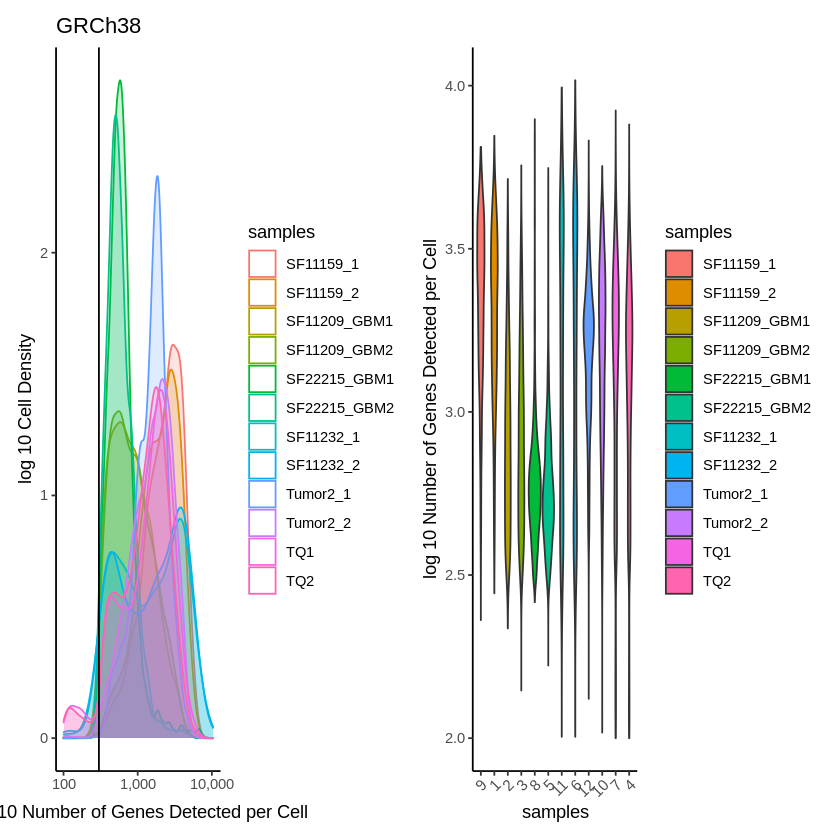

In [22]:
genesh_nf + genesv_nf

In [24]:
# Visualize the distribution of genes detected per cell via histogram
genesh_TE <- combinedTE_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nGene, fill=seq_folder)) + 
    labs(x = "log 10 Number of Genes Detected per Cell", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10(labels = comma) + 
    geom_vline(xintercept = 300) + 
    ggtitle("Retrotransposons")

# Visualize the distribution of genes detected per cell via boxplot
genesv_TE <- combinedTE_brain@meta.data %>% 
    ggplot(aes(x=seq_folder, y=log10(nGene), fill=seq_folder)) + 
    labs(x = "samples", y = "log 10 Number of Genes Detected per Cell") +
    labs(fill="samples") + scale_fill_discrete(labels = sampleNames_ordered) +
    geom_violin() + 
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

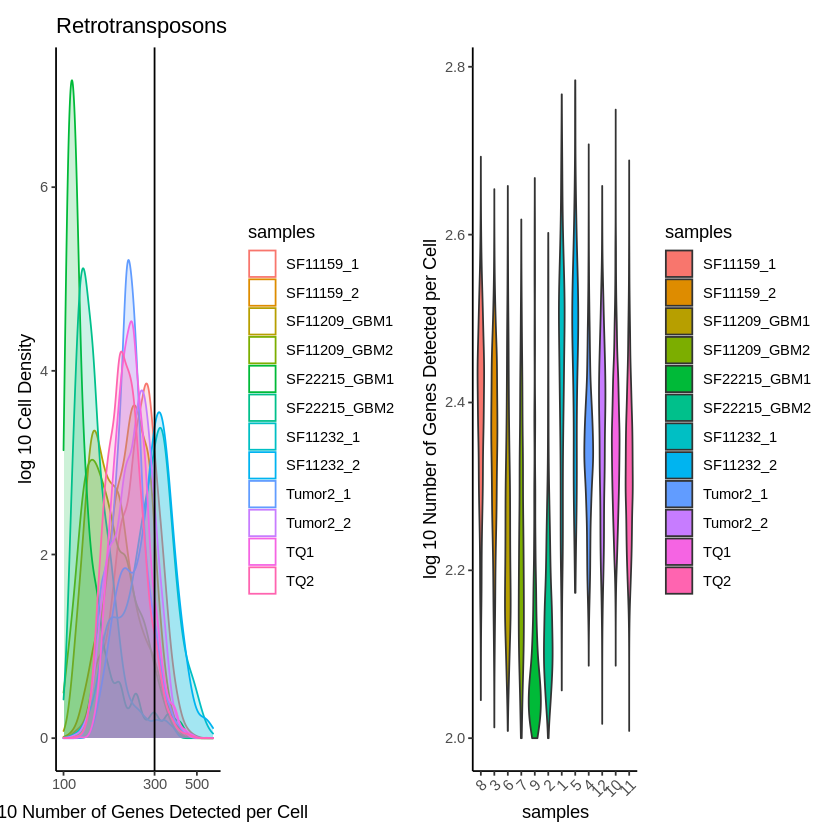

In [25]:
genesh_TE + genesv_TE

In [26]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_genespercell.pdf", width = size*2, height = size)
grid.arrange(genesh_nf, genesv_nf,
             genesh_TE, genesv_TE, 
             nrow = 2, top="Number of Cells vs Number of Genes")
dev.off()

png 
  2

In our reference genome mapped dataset, all cases contained >300 genes per cell which is what we want to see. however there are some abnormal distributions like the ones below that may be attributed to non-fully sequenced cells, or contains cells with different complexities
- Bell distributions that contain a "shoulder" include:
    - SF11159_1" and "SF11159_2"
    - "TQ1" and "TQ2"
- Bimodal distributions can be seen in:
    - "SF11232_1" and "SF11232_2"
    
In the retrotransposon mapped datasets, most cases have <300 genes per cell with the exception of "SF11232_1" and "SF11232_2". Some odd distributions with shorter peaks include:
- "SF11209_1" and "SF11209_2"
- "SF22215_GBM1" and "SF22215_GBM2"
- "TQ1" and "TQ2"

Tumor2_1 and Tumor2_2 replicates had consistently different distribution and variation compared to other paired replicates. 

### UMI vs Genes detected per cell

In [13]:
sampleNamesnf_named <- c(`9` = "SF11159_1", `1` = "SF11159_2", `2` = "SF11209_GBM1", `3` = "SF11209_GBM2", 
                         `8` = "SF22215_GBM1", `5` = "SF22215_GBM2", `11` = "SF11232_1", `6` = "SF11232_2", 
                         `12` = "Tumor2_1", `10` = "Tumor2_2", `7` = "TQ1", `4` = "TQ2")
sampleNamesTE_named <- c(`8` = "SF11159_1", `3` = "SF11159_2", `6` = "SF11209_GBM1", `7` = "SF11209_GBM2", 
                         `9` = "SF22215_GBM1", `2` = "SF22215_GBM2", `1` = "SF11232_1", `5` = "SF11232_2", 
                         `4` = "Tumor2_1", `12` = "Tumor2_2", `10` = "TQ1", `11` = "TQ2")

In [37]:
# Visualize the correlation between genes detected and number of UMIs 
# and determine whether strong presence of cells with low numbers of genes/UMIs
umigenes_nf <- combinednf_brain@meta.data %>% 
    ggplot(aes(x=nUMI, y=nGene, color=mitoRatio)) + 
    geom_point() + 
    scale_colour_gradient(low = "gray90", high = "black") +
    stat_smooth(method=lm) +
    scale_x_log10() + 
    scale_y_log10() + 
    labs(x = "log 10 UMI per Transcript", y = "log 10 Genes Detected per Cell") +
    theme_classic() +
    geom_vline(xintercept = 500) +
    geom_hline(yintercept = 250) +
    facet_wrap(~seq_folder, labeller = as_labeller(sampleNamesnf_named)) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))

umigenes_TE <- combinedTE_brain@meta.data %>% 
    ggplot(aes(x=nUMI, y=nGene)) + 
    geom_point(colour = "lightgray") + 
#     scale_colour_gradient(low = "white", high = "black") +
    stat_smooth(method=lm) +
    scale_x_log10() + 
    scale_y_log10() + 
    labs(x = "log 10 UMI per Transcript", y = "log 10 Genes Detected per Cell") +
    theme_classic() +
    geom_vline(xintercept = 500) + # Threshold for UMI per transcript. 
    geom_hline(yintercept = 250) + # Threshold for Genes detected per cell
    facet_wrap(~seq_folder, labeller = as_labeller(sampleNamesTE_named)) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Retrotransposons") + theme(plot.title = element_text(hjust=0.5, face="bold"))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



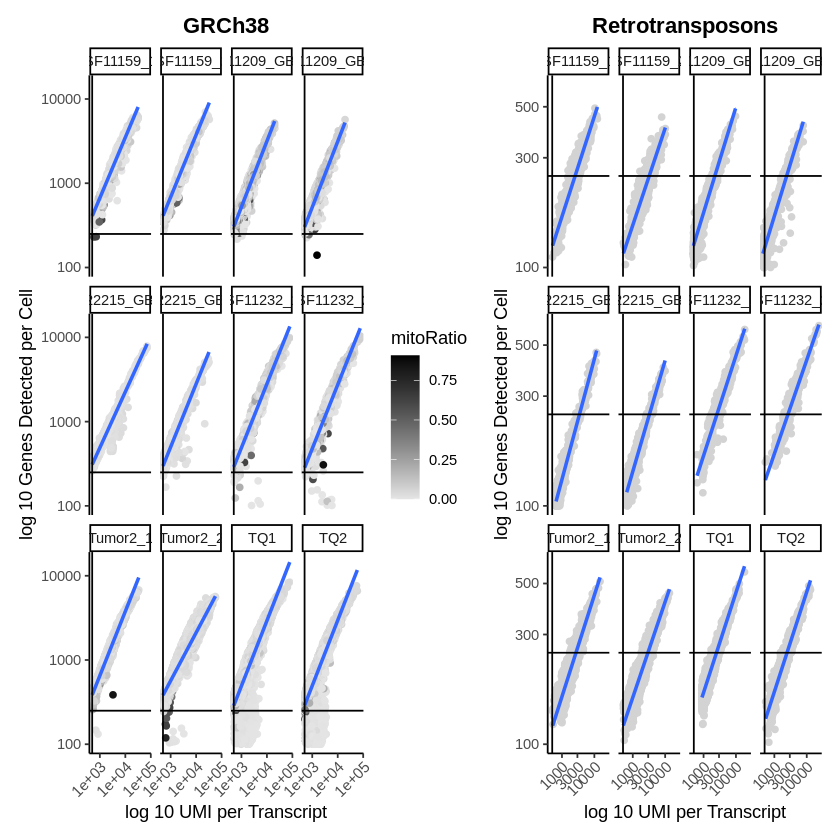

In [38]:
umigenes_nf + umigenes_TE

In [138]:
# Save figure of UMI vs Genes per cell
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_umigenes.pdf", width = size*2, height = size)
grid.arrange(umigenes_nf, umigenes_TE, nrow = 1, top="UMI vs Genes Detected per cell")
dev.off()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



png 
  2

Reference: 
- "Tumor2_2" had a highest mitochondrial ratio than other samples. However, many other samples had a high mitochondrial ratio that is over the standard thresholds (UMI per transcript = 500, and Genes Detected = 250). Therefore, it may be necessary to raise the threshold higher. 
    - To note, majority of SF22215_GBM1 and SF22215_GBM2 as well as SF11209_GBM1 and SF11209_GBM2 may be filtered out in the process. 
- "TQ1" and "TQ2" had a high volume of low quality cells as seen in the bottom left of their graphs. 

Retrotransposons
- There wouldn't be any mitochondria detected in the retrotransposon mapped datasets. 
- I should use a different umi per transcript threshold perhaps, because there isn't as many retrotransposons detected in a cell compared to genes from the reference genome. 

### Mitochondrial counts ratio

In [148]:
# Visualize the distribution of mitochondrial gene expression detected per cell
mito_nf <- combinednf_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=mitoRatio, fill=seq_folder)) + 
    labs(x = "Mitochondrial Ratio", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10() + 
    theme_classic() +
    geom_vline(xintercept = 0.2) + 
    ggtitle("GRCh38 Mitochondrial Counts Ratio") + theme(plot.title = element_text(hjust = 0.5))

# The retrotransposons don't need to be made

In [149]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_mitoratio.pdf", width = size*2, height = size)
mito_nf
dev.off()

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 185 rows containing non-finite values (stat_density)."


png 
  2

### Novelty Genes

In [145]:
# Visualize the overall complexity of the gene expression by visualizing the genes detected per UMI
newgenes_nf <- combinednf_brain@meta.data %>%
    ggplot(aes(x=log10GenesPerUMI, color = seq_folder, fill=seq_folder)) +
    labs(x = "log 10 Genes Detected Per UMI per Transcript", y = "Cell Count") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) +
    theme_classic() +
    geom_vline(xintercept = 0.8) + 
    ggtitle("GRCh38") + theme(plot.title = element_text(hjust = 0.5))

newgenes_TE <- combinedTE_brain@meta.data %>%
    ggplot(aes(x=log10GenesPerUMI, color = seq_folder, fill=seq_folder)) +
    labs(x = "log 10 Genes Detected Per UMI per Transcript", y = "Cell Count") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) +
    theme_classic() +
    geom_vline(xintercept = 0.8) + 
    ggtitle("Retrotransposons") + theme(plot.title = element_text(hjust = 0.5))

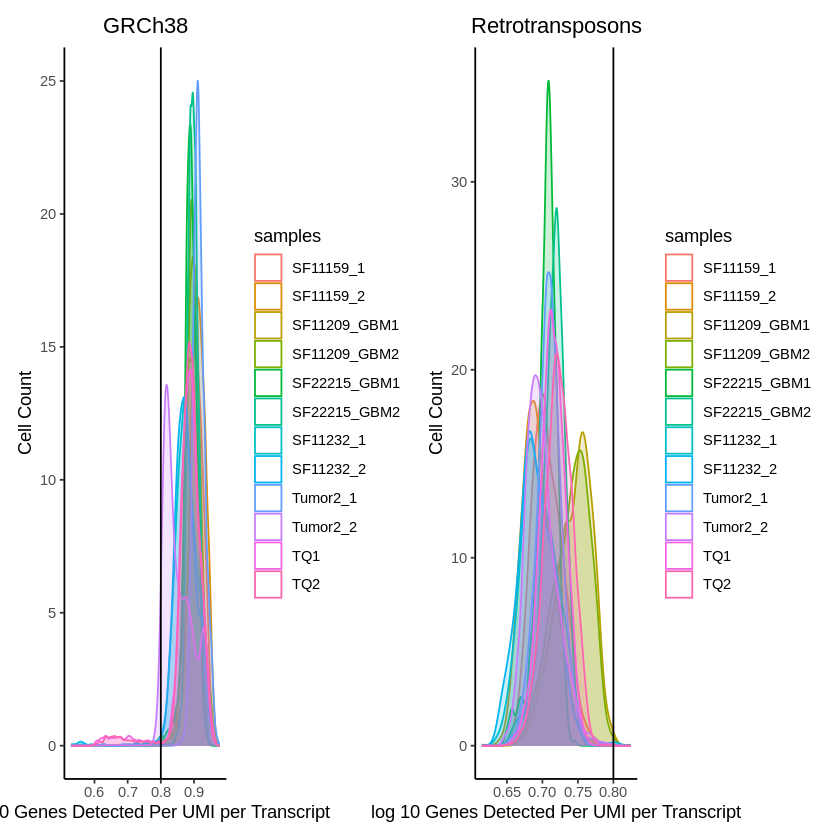

In [146]:
newgenes_nf + newgenes_TE

In [147]:
# Save figure of UMI vs Genes per cell
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_newgenes.pdf", width = size*2, height = size)
grid.arrange(newgenes_nf, newgenes_TE, nrow = 1, top="Gene Complexity")
dev.off()

png 
  2

### Subsetting Gene Expression + Retrotransposon Expression cells

In [150]:
barcode <- colnames(gte_brain)
combined_GE_select <- subset(combinednf_brain, cells=barcode)

In [152]:
dim(combined_GE_select) # 31242 features by 37104 cells

[1] 31242 37104

#### Quality Metrics

In [155]:
# number of genes per UMI in GE+TE dataset
gte_brain$log10GenesPerUMI <- log10(gte_brain$nFeature_RNA) / log10(gte_brain$nCount_RNA)
head(gte_brain$log10GenesPerUMI)

# do the same for subsetted GE dataset
combined_GE_select$log10GenesPerUMI <- log10(combined_GE_select$nFeature_RNA) / log10(combined_GE_select$nCount_RNA)
head(combined_GE_select$log10GenesPerUMI)

AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1 AAACGGGGTCCGAATT-1 
         0.8725599          0.8653694          0.8655554          0.8451595 
AAACGGGTCGAATGGG-1 AAAGATGAGGGTATCG-1 
         0.8932366          0.7971881

AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1 AAACGGGGTCCGAATT-1 
         0.8964581          0.8931295          0.9140969          0.8985577 
AAACGGGTCGAATGGG-1 AAAGATGAGGGTATCG-1 
         0.9345048          0.8818512

In [156]:
# mitochondrial ratio
gte_brain$mitoRatio <- PercentageFeatureSet(object = gte_brain, pattern = "^MT-")
gte_brain$mitoRatio <- gte_brain@meta.data$mitoRatio / 100

#do the same for TE dataset
combined_GE_select$mitoRatio <- PercentageFeatureSet(object = combined_GE_select, pattern = "^MT-")
combined_GE_select$mitoRatio <- combined_GE_select@meta.data$mitoRatio / 100

In [157]:
head(gte_brain$mitoRatio)
head(combined_GE_select$mitoRatio)

AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1 AAACGGGGTCCGAATT-1 
       0.005923887        0.046620828        0.038901602        0.042615417 
AAACGGGTCGAATGGG-1 AAAGATGAGGGTATCG-1 
       0.040313949        0.091237036

AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1 AAACGGGGTCCGAATT-1 
       0.008308157        0.068456045        0.070931850        0.084402151 
AAACGGGTCGAATGGG-1 AAAGATGAGGGTATCG-1 
       0.066159251        0.278824070

makes sense that the TE mapped dataset doesn't have mitochondrial genes, because we're being specific to retrotransposons.

Rename metadata columns for downstream QC.
I skipped a step for adding sample conditions, because there were no conditions in this experiment.

In [164]:
# Create metadata dataframe
metadata_gte <- gte_brain@meta.data
metadata_GE_select <- combined_GE_select@meta.data

# Add cell IDs to metadata
metadata_gte$cells <- rownames(metadata_gte)
metadata_GE_select$cells <- rownames(metadata_GE_select)

# Rename columns
# metadata_gte <- metadata_gte %>%
#         dplyr::rename(seq_folder = orig.ident,
#                       nUMI = nCount_RNA,
#                       nGene = nFeature_RNA)
# metadata_GE_select <- metadata_GE_select %>%
#         dplyr::rename(seq_folder = orig.ident,
#                       nUMI = nCount_RNA,
#                       nGene = nFeature_RNA)

ERROR: Error: Can't rename columns that don't exist.
[31m✖[39m Column `orig.ident` doesn't exist.


In [26]:
#combinednf_brain@meta.data <- metadata_nf

# Create .RData to Load at any time
#save(combinednf_brain, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combinednf_brain_seurat.RData")

Add original sample origin names to column sample 

In [15]:
sampleNames_ordered <- list("SF11159_1", "SF11159_2", "SF11209_GBM1", "SF11209_GBM2", "SF22215_GBM1", "SF22215_GBM2", "SF11232_1", "SF11232_2", "Tumor2_1", "Tumor2_2", "TQ1", "TQ2")
sampleNames_nf <- list("SF11159_2", "SF11209_GBM1", "SF11209_GBM2","TQ2","SF22215_GBM2","SF11232_2","TQ1","SF22215_GBM1","SF11159_1","Tumor2_2","SF11232_1","Tumor2_1")
#sampleNames_TE <- list("SF11209_GBM1","SF11159_1","SF11159_2","Tumor2_1","SF22215_GBM1","SF11232_2","SF22215_GBM2", "SF11209_GBM2", "Tumor2_2", "SF11232_1", "TQ2", "TQ1")

In [20]:
#metadata_nf <- combinednf_brain@meta.data

In [167]:
# Create sample column
metadata_gte$sample <- NA
metadata_GE_select$sample <- NA

In [168]:
for(i in 1:length(sampleNames_ordered)) {
    metadata_gte$sample[which(metadata_gte$seq_folder == i)] <- sampleNames_nf[i]
    metadata_GE_select$sample[which(metadata_GE_select$seq_folder == i)] <- sampleNames_nf[i]
}

In [169]:
metadata_gte$seq_folder <- factor(metadata_gte$seq_folder, levels = c("9", "1", "2", "3", "8",
                                                 "5", "11", "6", "12", "10", "7", "4"))
# metadata_nf$sample <- factor(metadata_nf$sample, levels = sampleNames_ordered)

metadata_GE_select$seq_folder <- factor(metadata_GE_select$seq_folder, levels = c("9", "1", "2", "3", "8",
                                                 "5", "11", "6", "12", "10", "7", "4"))
# metadata_TE$sample <- factor(metadata_TE$sample, levels = sampleNames_ordered)

In [170]:
# Add metadata back to Seurat object
gte_brain@meta.data <- metadata_gte
combined_GE_select@meta.data <- metadata_GE_select

In [171]:
#save.image('/home/samkyy/scratch/RetroTransposonAnalysis/code/data/2021-03-25.RData')
save(gte_brain, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/gte_brain_seurat-03-30.RData")
save(combined_GE_select, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/combined_GE_select_seurat-03-30.RData")

#### Cell Counts

In [173]:
cellcount_gte <- gte_brain@meta.data %>%
    ggplot(aes(x=seq_folder, fill=seq_folder)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleNames_ordered) +
    scale_fill_discrete(labels = sampleNames_ordered) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust=0.5, face="bold"))


cellcount_GEs <- combined_GE_select@meta.data %>%
    ggplot(aes(x=seq_folder, fill=seq_folder)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleNames_ordered) +
    scale_fill_discrete(labels = sampleNames_ordered) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Subsetted GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))


In [174]:
# Save figure of cell count
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GTE_cellcount.pdf", width = size*2, height = size)
grid.arrange(cellcount_GEs, cellcount_gte, nrow = 1, top="Number of Cells per Dataset")
dev.off()

png 
  2

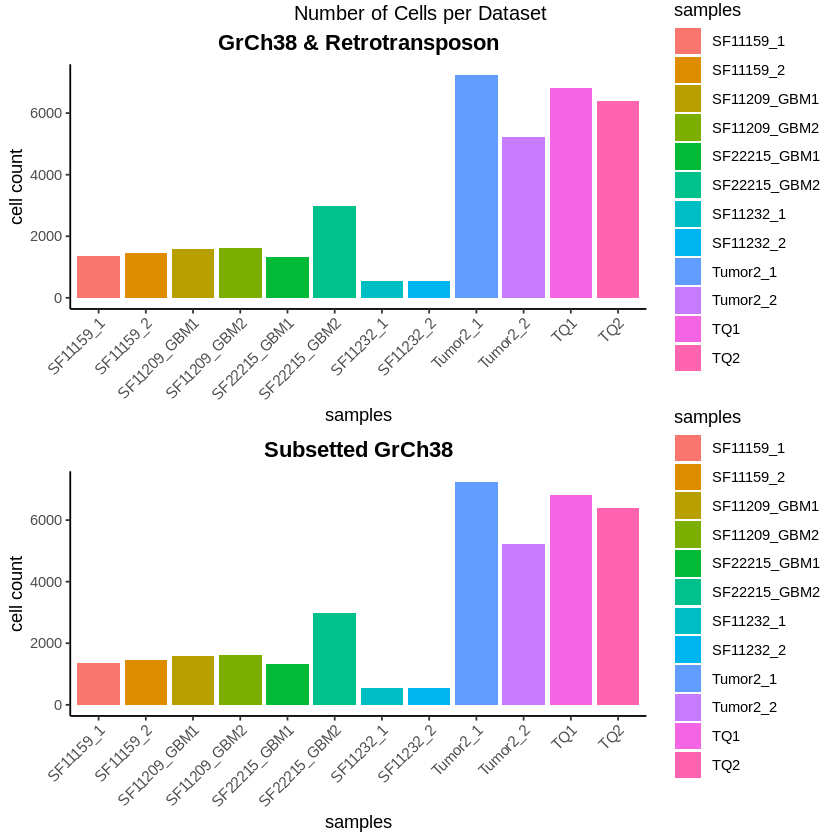

In [175]:
grid.arrange(cellcount_gte, cellcount_GEs, nrow = 2, top="Number of Cells per Dataset")

#### UMI per Transcript

On the reference genome mapped samples, 500-1000 transcripts would be considered to shallow. If majority of cells have > 1000 unique transcripts then that would be acceptable.

In [178]:
# Visualize the number UMIs/transcripts per cell
umi_nf <- gte_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nUMI, fill=seq_folder)) + 
    labs(x = "UMI per Transcript (log10)", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10(labels = comma, limit=c(100, 100000)) + 
    theme_classic() +
    ggtitle("GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(xintercept = c(500,1000))

umi_TE <- combined_GE_select@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nUMI, fill=seq_folder)) + 
    labs(x = "UMI per Transcript (log10)", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10(labels = comma, limit=c(100, 100000)) + 
    theme_classic() +
    ggtitle("Subsetted GRCh38") + theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(xintercept = c(500,1000))

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


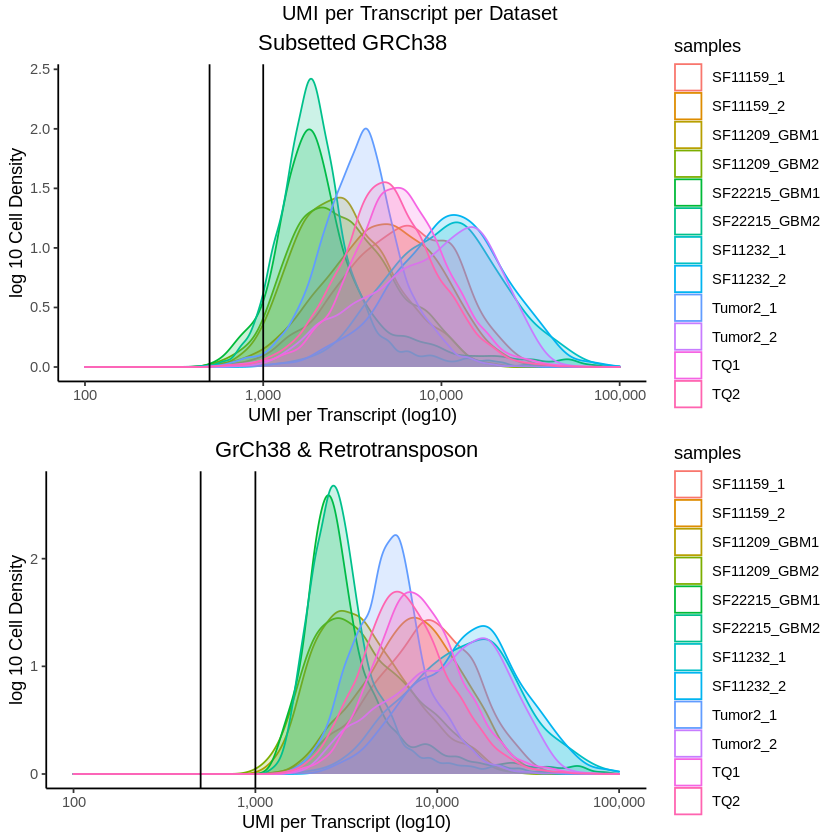

In [179]:
grid.arrange(umi_TE, umi_nf, nrow = 2, top="UMI per Transcript per Dataset")

In [180]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GTE_umipertranscript.pdf", width = size*2, height = size)
grid.arrange(umi_TE, umi_nf, nrow = 1, top="UMI per Transcript per Dataset")
dev.off()

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


png 
  2

#### Genes detected per cell

In [185]:
#reference 

# Visualize the distribution of genes detected per cell via histogram
genesh_nf <- combined_GE_select@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nGene, fill=seq_folder)) + 
    labs(x = "log 10 Number of Genes Detected per Cell", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10(labels = comma) + 
    geom_vline(xintercept = 300) +
    ggtitle("Subsetted GrCh38")

# Visualize the distribution of genes detected per cell via boxplot
genesv_nf <- combined_GE_select@meta.data %>% 
    ggplot(aes(x=seq_folder, y=log10(nGene), fill=seq_folder)) + 
    labs(x = "samples", y = "log 10 Number of Genes Detected per Cell") +
    labs(fill="samples") + scale_fill_discrete(labels = sampleNames_ordered) +
    geom_violin() + 
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

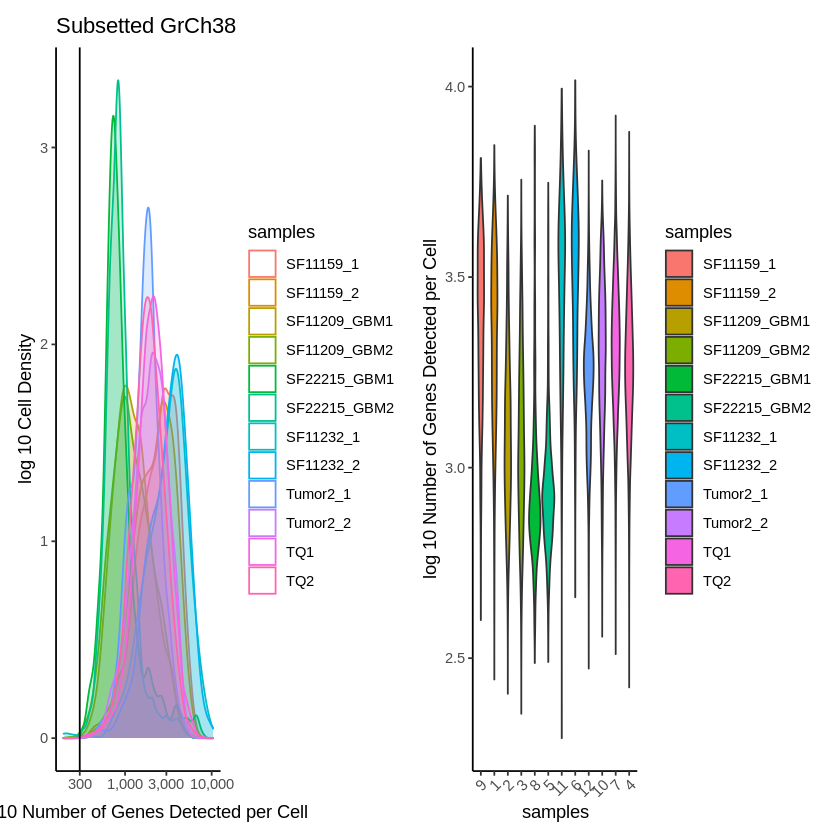

In [186]:
genesh_nf + genesv_nf

In [187]:
# Visualize the distribution of genes detected per cell via histogram
genesh_TE <- gte_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nGene, fill=seq_folder)) + 
    labs(x = "log 10 Number of Genes Detected per Cell", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10(labels = comma) + 
    geom_vline(xintercept = 300) + 
    ggtitle("GrCh38 & Retrotransposon")

# Visualize the distribution of genes detected per cell via boxplot
genesv_TE <- gte_brain@meta.data %>% 
    ggplot(aes(x=seq_folder, y=log10(nGene), fill=seq_folder)) + 
    labs(x = "samples", y = "log 10 Number of Genes Detected per Cell") +
    labs(fill="samples") + scale_fill_discrete(labels = sampleNames_ordered) +
    geom_violin() + 
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

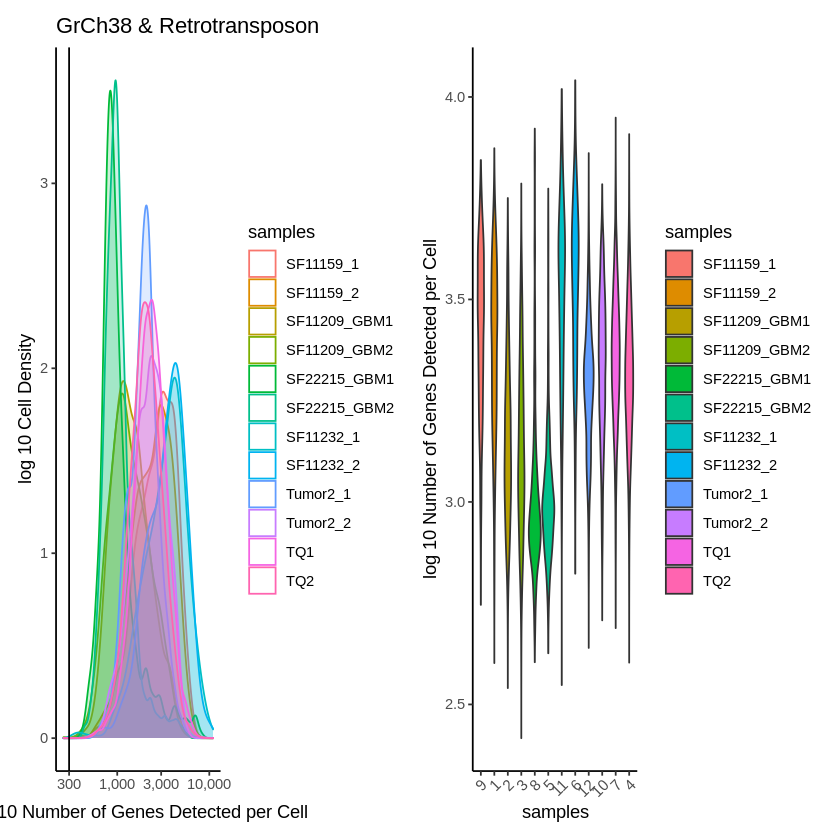

In [188]:
genesh_TE + genesv_TE

In [189]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GTE_genespercell.pdf", width = size*2, height = size)
grid.arrange(genesh_nf, genesv_nf,
             genesh_TE, genesv_TE, 
             nrow = 2, top="Number of Cells vs Number of Genes")
dev.off()

png 
  2

#### UMI vs Genes detected per cell

In [8]:
sampleNamesnf_named <- c(`9` = "SF11159_1", `1` = "SF11159_2", `2` = "SF11209_GBM1", `3` = "SF11209_GBM2", 
                         `8` = "SF22215_GBM1", `5` = "SF22215_GBM2", `11` = "SF11232_1", `6` = "SF11232_2", 
                         `12` = "Tumor2_1", `10` = "Tumor2_2", `7` = "TQ1", `4` = "TQ2")
# sampleNamesTE_named <- c(`8` = "SF11159_1", `3` = "SF11159_2", `6` = "SF11209_GBM1", `7` = "SF11209_GBM2", 
#                          `9` = "SF22215_GBM1", `2` = "SF22215_GBM2", `1` = "SF11232_1", `5` = "SF11232_2", 
#                          `4` = "Tumor2_1", `12` = "Tumor2_2", `10` = "TQ1", `11` = "TQ2")

In [9]:
# Visualize the correlation between genes detected and number of UMIs 
# and determine whether strong presence of cells with low numbers of genes/UMIs
umigenes_nf <- combined_GE_select@meta.data %>% 
    ggplot(aes(x=nUMI, y=nGene, color=mitoRatio)) + 
    geom_point() + 
    scale_colour_gradient(low = "gray90", high = "black") +
    stat_smooth(method=lm) +
    scale_x_log10(labels = comma) + 
    scale_y_log10() + 
    labs(x = "log 10 UMI per Transcript", y = "log 10 Genes Detected per Cell") +
    theme_classic() +
    geom_vline(xintercept = 500) +
    geom_hline(yintercept = 250) +
    facet_wrap(~seq_folder, labeller = as_labeller(sampleNamesnf_named)) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Subsetted GrCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))

umigenes_TE <- gte_brain@meta.data %>% 
    ggplot(aes(x=nUMI, y=nGene, color=mitoRatio)) + 
    geom_point() + 
    scale_colour_gradient(low = "gray90", high = "black") +
    stat_smooth(method=lm) +
    scale_x_log10(labels = comma) + 
    scale_y_log10() + 
    labs(x = "log 10 UMI per Transcript", y = "log 10 Genes Detected per Cell") +
    theme_classic() +
    geom_vline(xintercept = 500) + # Threshold for UMI per transcript. 
    geom_hline(yintercept = 250) + # Threshold for Genes detected per cell
    facet_wrap(~seq_folder, labeller = as_labeller(sampleNamesnf_named)) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust=0.5, face="bold"))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



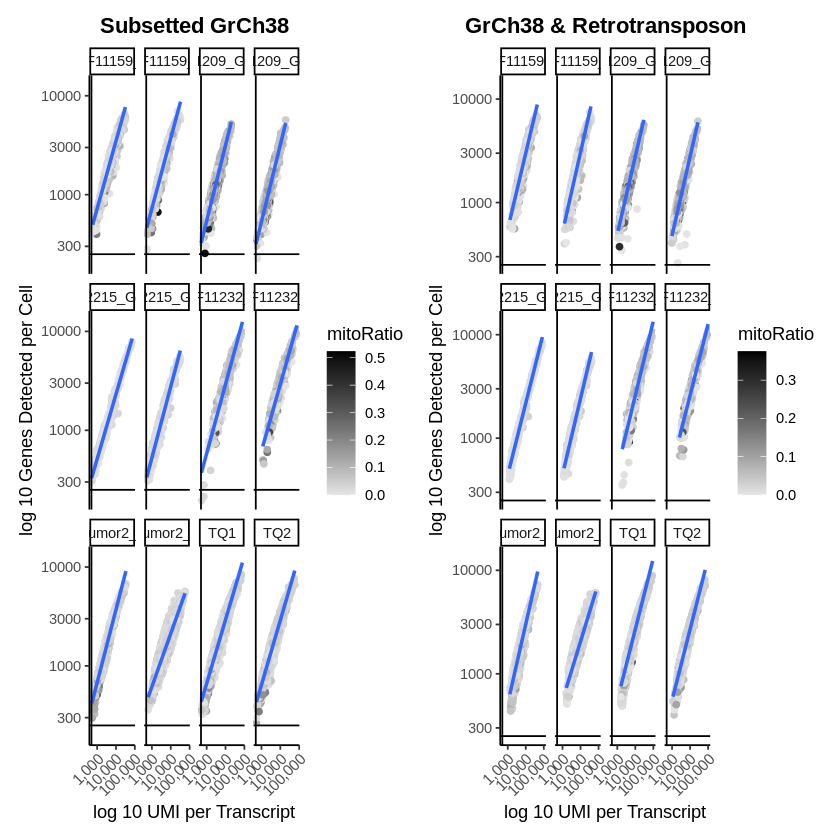

In [10]:
umigenes_nf + umigenes_TE

In [11]:
# Save figure of UMI vs Genes per cell
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GTE_umigenes.pdf", width = size*2, height = size)
grid.arrange(umigenes_nf, umigenes_TE, nrow = 1, top="UMI vs Genes Detected per cell")
dev.off()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



png 
  2

#### Mitochondrial counts ratio

In [199]:
# Visualize the distribution of mitochondrial gene expression detected per cell
mito_nf <- combined_GE_select@meta.data %>% 
    ggplot(aes(color=seq_folder, x=mitoRatio, fill=seq_folder)) + 
    labs(x = "Mitochondrial Ratio", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10() + 
    theme_classic() +
    geom_vline(xintercept = 0.2) + 
    ggtitle("Subsetted GrCh38") + theme(plot.title = element_text(hjust = 0.5))

mito_TE <- gte_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=mitoRatio, fill=seq_folder)) + 
    labs(x = "Mitochondrial Ratio", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10() + 
    theme_classic() +
    geom_vline(xintercept = 0.2) + 
    ggtitle("GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust = 0.5))

In [200]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GTE_mitoratio.pdf", width = size*2, height = size)
grid.arrange(mito_nf, mito_TE, nrow = 1, top="Mitochondrial Counts Ratio")
dev.off()

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 22 rows containing non-finite values (stat_density)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 22 rows containing non-finite values (stat_density)."


png 
  2

#### Novelty Genes

In [201]:
# Visualize the overall complexity of the gene expression by visualizing the genes detected per UMI
newgenes_nf <- combined_GE_select@meta.data %>%
    ggplot(aes(x=log10GenesPerUMI, color = seq_folder, fill=seq_folder)) +
    labs(x = "log 10 Genes Detected Per UMI per Transcript", y = "Cell Count") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) +
    theme_classic() +
    geom_vline(xintercept = 0.8) + 
    ggtitle("Subsetted GrCh38") + theme(plot.title = element_text(hjust = 0.5))

newgenes_TE <- gte_brain@meta.data %>%
    ggplot(aes(x=log10GenesPerUMI, color = seq_folder, fill=seq_folder)) +
    labs(x = "log 10 Genes Detected Per UMI per Transcript", y = "Cell Count") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) +
    theme_classic() +
    geom_vline(xintercept = 0.8) + 
    ggtitle("GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust = 0.5))

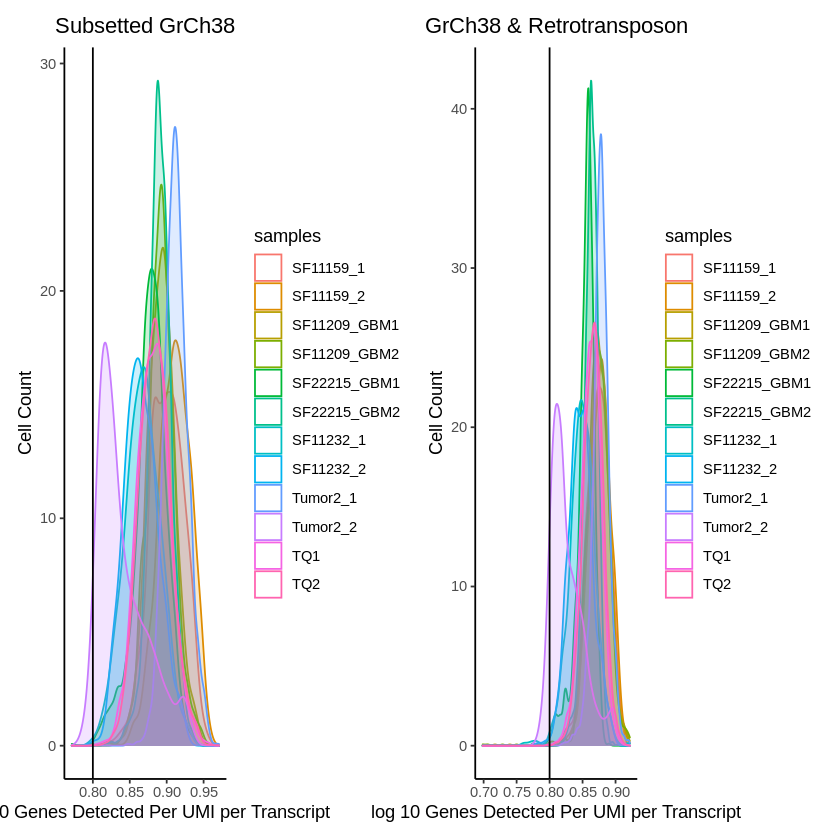

In [202]:
newgenes_nf + newgenes_TE

In [203]:
# Save figure of UMI vs Genes per cell
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GTE_newgenes.pdf", width = size*2, height = size)
grid.arrange(newgenes_nf, newgenes_TE, nrow = 1, top="Gene Complexity")
dev.off()

png 
  2

#### Filter cells

In [12]:
filt_gte_brain <- subset(x = gte_brain, subset= (nUMI >= 1000) & 
                                                (nGene >= 300) & 
                                                (log10GenesPerUMI > 0.80) & 
                                                (mitoRatio < 0.20))

In [40]:
barcode <- colnames(filt_gte_brain)
filt_GE_select <- subset(combined_GE_select, cells=barcode)
dim(filt_gte_brain) # 36558 cells
dim(filt_GE_select) # 36558 cells

[1] 32169 36558

[1] 31242 36558

In [45]:
dim(gte_brain)[2] - dim(filt_gte_brain)[2] # filtered out 546 cells

[1] 546

In [47]:
dim(combined_GE_select)[2] - dim(filt_GE_select)[2] # filtered out 546 cells

[1] 546

In [46]:
#save.image('/home/samkyy/scratch/RetroTransposonAnalysis/code/data/2021-03-25.RData')
save(filt_gte_brain, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain_seurat-03-31.RData")
save(filt_GE_select, file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select_seurat-03-31.RData")

### Filtered Dataset Quality Controls

#### Cell Counts

In [48]:
cellcount_gte <- filt_gte_brain@meta.data %>%
    ggplot(aes(x=seq_folder, fill=seq_folder)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleNames_ordered) +
    scale_fill_discrete(labels = sampleNames_ordered) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Filtered GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust=0.5, face="bold"))


cellcount_GEs <- filt_GE_select@meta.data %>%
    ggplot(aes(x=seq_folder, fill=seq_folder)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleNames_ordered) +
    scale_fill_discrete(labels = sampleNames_ordered) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Subsetted & Filtered GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))


In [49]:
# Save figure of cell count
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_filt_GTE_cellcount.pdf", width = size*2, height = size)
grid.arrange(cellcount_GEs, cellcount_gte, nrow = 1, top="Number of Cells per Dataset after Filtering")
dev.off()

png 
  2

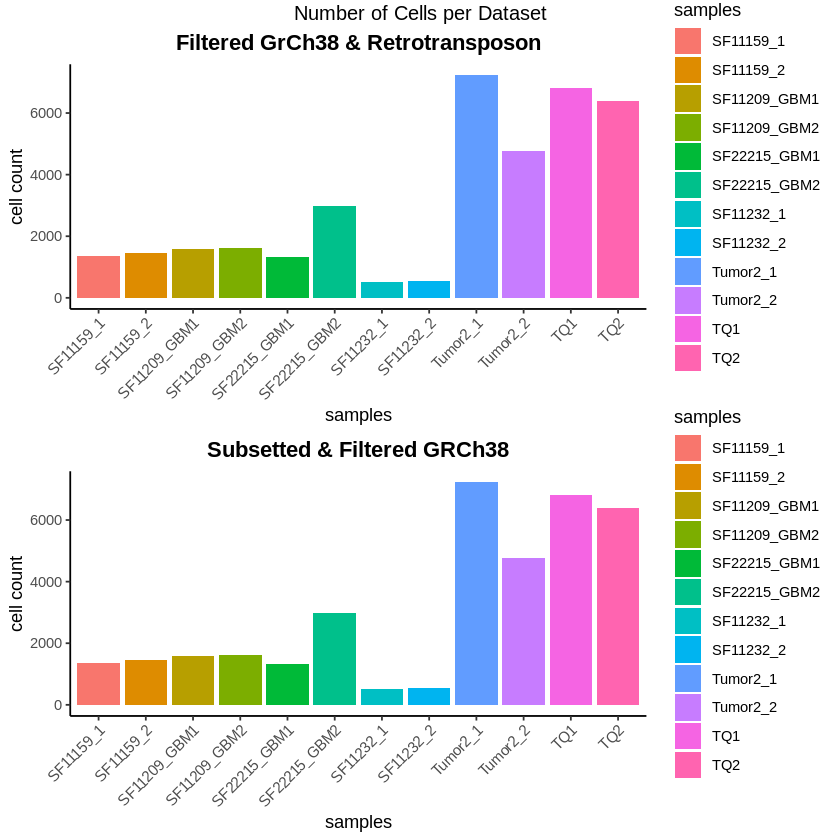

In [50]:
grid.arrange(cellcount_gte, cellcount_GEs, nrow = 2, top="Number of Cells per Dataset")

#### UMI per Transcript

On the reference genome mapped samples, 500-1000 transcripts would be considered to shallow. If majority of cells have > 1000 unique transcripts then that would be acceptable.

In [51]:
# Visualize the number UMIs/transcripts per cell
umi_nf <- filt_gte_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nUMI, fill=seq_folder)) + 
    labs(x = "UMI per Transcript (log10)", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10(labels = comma, limit=c(100, 100000)) + 
    theme_classic() +
    ggtitle("Filtered GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(xintercept = c(500,1000))

umi_TE <- filt_GE_select@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nUMI, fill=seq_folder)) + 
    labs(x = "UMI per Transcript (log10)", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10(labels = comma, limit=c(100, 100000)) + 
    theme_classic() +
    ggtitle("Subsetted & Filtered GRCh38") + theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(xintercept = c(500,1000))

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


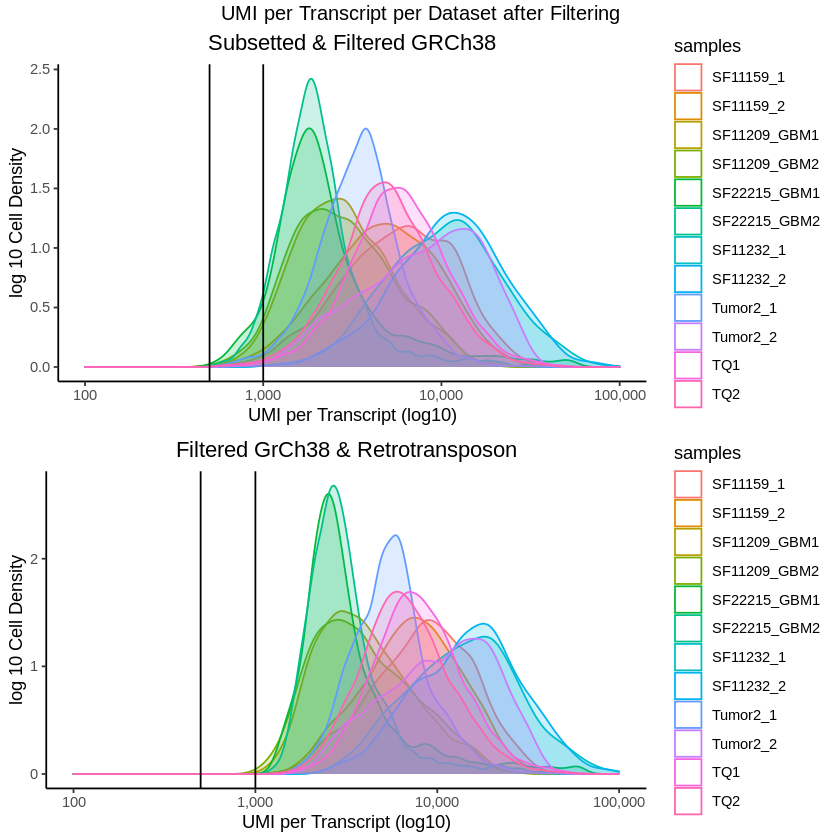

In [52]:
grid.arrange(umi_TE, umi_nf, nrow = 2, top="UMI per Transcript per Dataset after Filtering")

In [53]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_filt_GTE_umipertranscript.pdf", width = size*2, height = size)
grid.arrange(umi_TE, umi_nf, nrow = 1, top="UMI per Transcript per Dataset after Filtering")
dev.off()

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


png 
  2

#### Genes detected per cell

In [54]:
#reference 

# Visualize the distribution of genes detected per cell via histogram
genesh_nf <- filt_GE_select@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nGene, fill=seq_folder)) + 
    labs(x = "log 10 Number of Genes Detected per Cell", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10(labels = comma) + 
    geom_vline(xintercept = 300) +
    ggtitle("Subsetted & Filtered GRCh38")

# Visualize the distribution of genes detected per cell via boxplot
genesv_nf <- filt_GE_select@meta.data %>% 
    ggplot(aes(x=seq_folder, y=log10(nGene), fill=seq_folder)) + 
    labs(x = "samples", y = "log 10 Number of Genes Detected per Cell") +
    labs(fill="samples") + scale_fill_discrete(labels = sampleNames_ordered) +
    geom_violin() + 
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

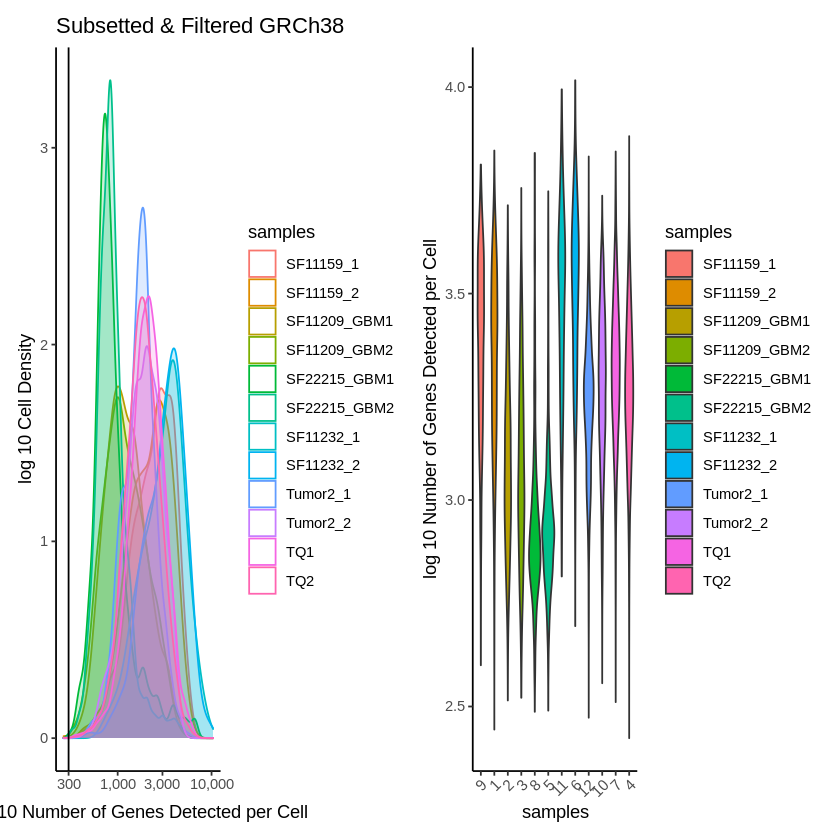

In [55]:
genesh_nf + genesv_nf

In [56]:
# Visualize the distribution of genes detected per cell via histogram
genesh_TE <- filt_gte_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=nGene, fill=seq_folder)) + 
    labs(x = "log 10 Number of Genes Detected per Cell", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10(labels = comma) + 
    geom_vline(xintercept = 300) + 
    ggtitle("Filtered GrCh38 & Retrotransposon")

# Visualize the distribution of genes detected per cell via boxplot
genesv_TE <- filt_gte_brain@meta.data %>% 
    ggplot(aes(x=seq_folder, y=log10(nGene), fill=seq_folder)) + 
    labs(x = "samples", y = "log 10 Number of Genes Detected per Cell") +
    labs(fill="samples") + scale_fill_discrete(labels = sampleNames_ordered) +
    geom_violin() + 
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

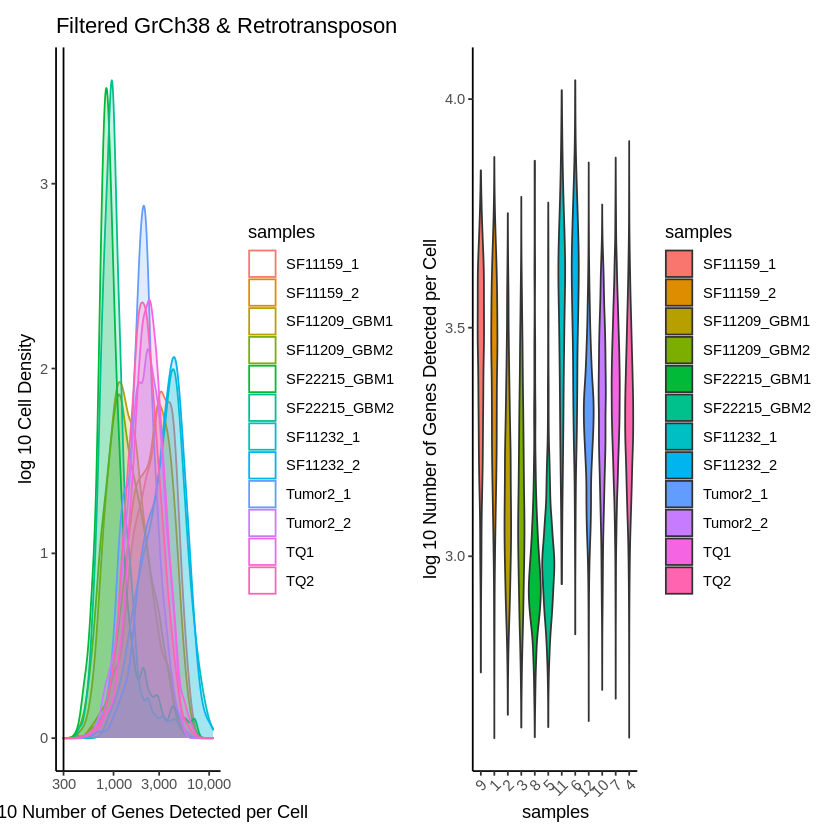

In [57]:
genesh_TE + genesv_TE

In [58]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_filt_GTE_genespercell.pdf", width = size*2, height = size)
grid.arrange(genesh_nf, genesv_nf,
             genesh_TE, genesv_TE, 
             nrow = 2, top="Number of Cells vs Number of Genes after Filtering")
dev.off()

png 
  2

#### UMI vs Genes detected per cell

In [59]:
sampleNamesnf_named <- c(`9` = "SF11159_1", `1` = "SF11159_2", `2` = "SF11209_GBM1", `3` = "SF11209_GBM2", 
                         `8` = "SF22215_GBM1", `5` = "SF22215_GBM2", `11` = "SF11232_1", `6` = "SF11232_2", 
                         `12` = "Tumor2_1", `10` = "Tumor2_2", `7` = "TQ1", `4` = "TQ2")
# sampleNamesTE_named <- c(`8` = "SF11159_1", `3` = "SF11159_2", `6` = "SF11209_GBM1", `7` = "SF11209_GBM2", 
#                          `9` = "SF22215_GBM1", `2` = "SF22215_GBM2", `1` = "SF11232_1", `5` = "SF11232_2", 
#                          `4` = "Tumor2_1", `12` = "Tumor2_2", `10` = "TQ1", `11` = "TQ2")

In [60]:
# Visualize the correlation between genes detected and number of UMIs 
# and determine whether strong presence of cells with low numbers of genes/UMIs
umigenes_nf <- filt_GE_select@meta.data %>% 
    ggplot(aes(x=nUMI, y=nGene, color=mitoRatio)) + 
    geom_point() + 
    scale_colour_gradient(low = "gray90", high = "black") +
    stat_smooth(method=lm) +
    scale_x_log10(labels = comma) + 
    scale_y_log10() + 
    labs(x = "log 10 UMI per Transcript", y = "log 10 Genes Detected per Cell") +
    theme_classic() +
    geom_vline(xintercept = 500) +
    geom_hline(yintercept = 250) +
    facet_wrap(~seq_folder, labeller = as_labeller(sampleNamesnf_named)) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Subsetted & Filtered GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))

umigenes_TE <- filt_gte_brain@meta.data %>% 
    ggplot(aes(x=nUMI, y=nGene, color=mitoRatio)) + 
    geom_point() + 
    scale_colour_gradient(low = "gray90", high = "black") +
    stat_smooth(method=lm) +
    scale_x_log10(labels = comma) + 
    scale_y_log10() + 
    labs(x = "log 10 UMI per Transcript", y = "log 10 Genes Detected per Cell") +
    theme_classic() +
    geom_vline(xintercept = 500) + # Threshold for UMI per transcript. 
    geom_hline(yintercept = 250) + # Threshold for Genes detected per cell
    facet_wrap(~seq_folder, labeller = as_labeller(sampleNamesnf_named)) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("Filtered GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust=0.5, face="bold"))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



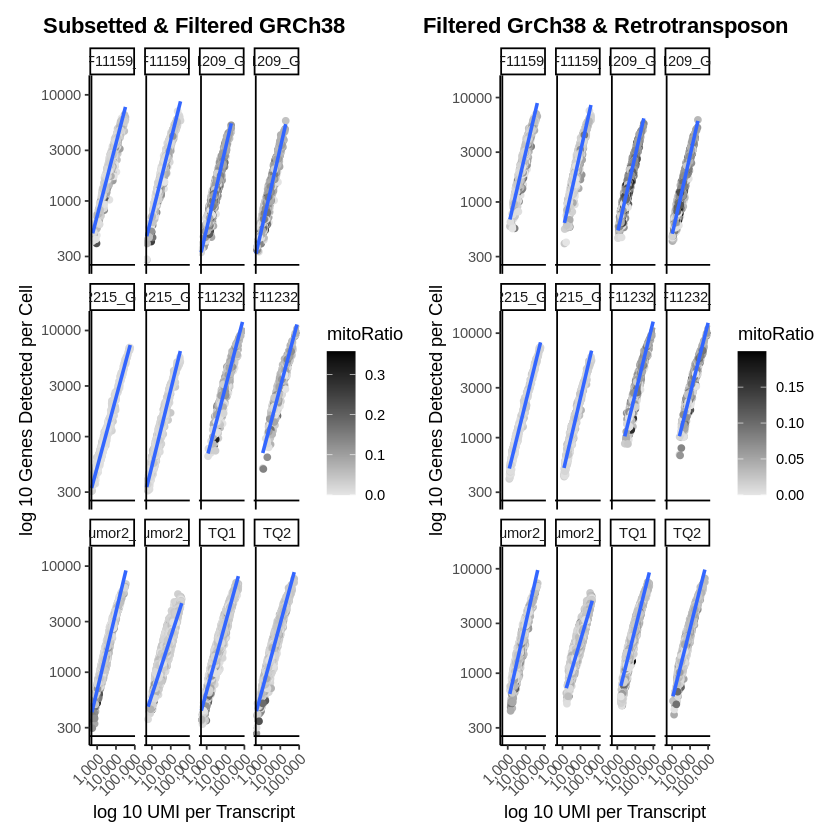

In [61]:
umigenes_nf + umigenes_TE

In [62]:
# Save figure of UMI vs Genes per cell
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_filt_GTE_umigenes.pdf", width = size*2, height = size)
grid.arrange(umigenes_nf, umigenes_TE, nrow = 1, top="UMI vs Genes Detected per cell after Filtering")
dev.off()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



png 
  2

#### Mitochondrial counts ratio

In [63]:
# Visualize the distribution of mitochondrial gene expression detected per cell
mito_nf <- filt_GE_select@meta.data %>% 
    ggplot(aes(color=seq_folder, x=mitoRatio, fill=seq_folder)) + 
    labs(x = "Mitochondrial Ratio", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10() + 
    theme_classic() +
    geom_vline(xintercept = 0.2) + 
    ggtitle("Subsetted & Filtered GRCh38") + theme(plot.title = element_text(hjust = 0.5))

mito_TE <- filt_gte_brain@meta.data %>% 
    ggplot(aes(color=seq_folder, x=mitoRatio, fill=seq_folder)) + 
    labs(x = "Mitochondrial Ratio", y = "log 10 Cell Density") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) + 
    scale_x_log10() + 
    theme_classic() +
    geom_vline(xintercept = 0.2) + 
    ggtitle("Filtered GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust = 0.5))

In [64]:
# Save figure of UMI per transcript
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_filt_GTE_mitoratio.pdf", width = size*2, height = size)
grid.arrange(mito_nf, mito_TE, nrow = 1, top="Mitochondrial Counts Ratio after Filtering")
dev.off()

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 21 rows containing non-finite values (stat_density)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 21 rows containing non-finite values (stat_density)."


png 
  2

#### Novelty Genes

In [65]:
# Visualize the overall complexity of the gene expression by visualizing the genes detected per UMI
newgenes_nf <- filt_GE_select@meta.data %>%
    ggplot(aes(x=log10GenesPerUMI, color = seq_folder, fill=seq_folder)) +
    labs(x = "log 10 Genes Detected Per UMI per Transcript", y = "Cell Count") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) +
    theme_classic() +
    geom_vline(xintercept = 0.8) + 
    ggtitle("Subsetted & Filtered GRCh38") + theme(plot.title = element_text(hjust = 0.5))

newgenes_TE <- filt_gte_brain@meta.data %>%
    ggplot(aes(x=log10GenesPerUMI, color = seq_folder, fill=seq_folder)) +
    labs(x = "log 10 Genes Detected Per UMI per Transcript", y = "Cell Count") +
    labs(color="samples") + scale_color_discrete(labels = sampleNames_ordered) +
    guides(fill=FALSE) + 
    geom_density(alpha = 0.2) +
    theme_classic() +
    geom_vline(xintercept = 0.8) + 
    ggtitle("Filtered GrCh38 & Retrotransposon") + theme(plot.title = element_text(hjust = 0.5))

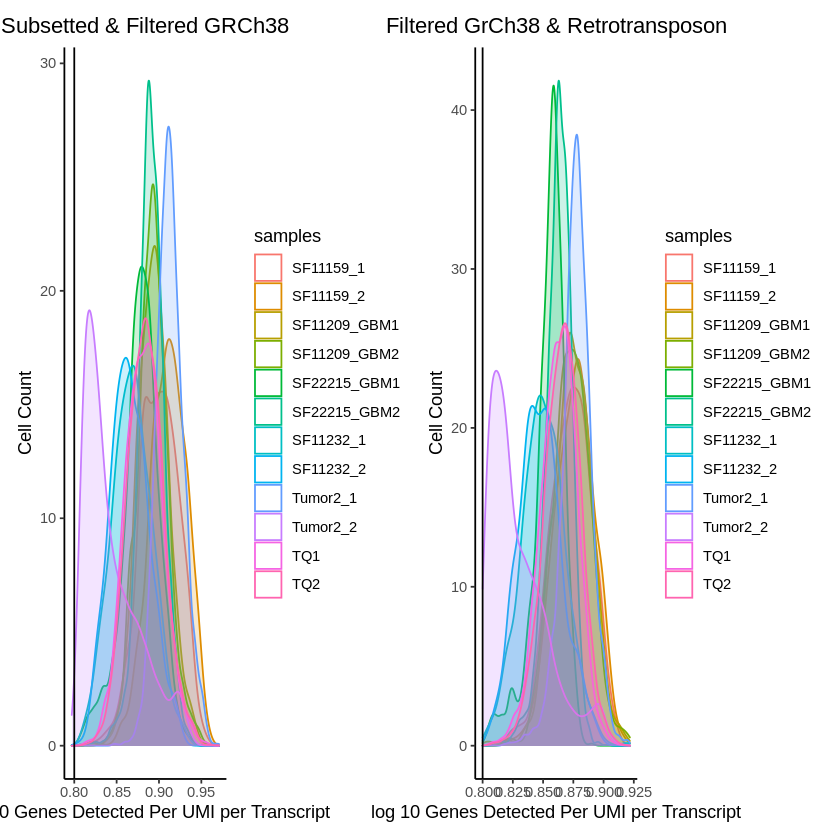

In [66]:
newgenes_nf + newgenes_TE

In [67]:
# Save figure of UMI vs Genes per cell
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_filt_GTE_newgenes.pdf", width = size*2, height = size)
grid.arrange(newgenes_nf, newgenes_TE, nrow = 1, top="Gene Complexity")
dev.off()

png 
  2

### Alternative to the visualization

In [ ]:
# Visualize QC metrics as a violin plot
# VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

## Data Integration & Clustering

Dr. Tanaka and Seurat vignettes follow the same protocol.
- [Single-cell RNA-seq: Theory of normalization and PCA | Introduction to Single-cell RNA-seq - ARCHIVED](https://hbctraining.github.io/scRNA-seq/lessons/05_normalization_and_PCA.html): Next step in normalization and integration. 

In [6]:
# split the dataset into a list of seurat objects by their sample of origin
filt_gte_brain.list <- SplitObject(object=filt_gte_brain, split.by="seq_folder")
filt_GE_select.list <- SplitObject(object=filt_GE_select, split.by="seq_folder")

**NormalizeData()**
- `normalization.method = LogNormalize` (default)
- [NormalizeData function - RDocumentation](https://www.rdocumentation.org/packages/Seurat/versions/4.0.1/topics/NormalizeData)
- [ ] Should I normalize before or after I filter the cells?

**FindVariableFeatures()**
- Find outliers via 'mean variability plot'
- `selection.method = vst` (default)
- [FindVariableFeatures function - RDocumentation](https://www.rdocumentation.org/packages/Seurat/versions/4.0.1/topics/FindVariableFeatures)

**FindIntegrationAnchors()** sets anchors to be used as inputs for **IntegrateData**
- [FindIntegrationAnchors function - RDocumentation](https://www.rdocumentation.org/packages/Seurat/versions/4.0.0/topics/FindIntegrationAnchors) <cite data-cite="7065199/YXIX4SBW"></cite> 
- [Introduction to scRNA-seq integration • Seurat](https://satijalab.org/seurat/articles/integration_introduction.html)
- Used to compute the standardized differences between different datasets.

### Normalize & Find Variable Features

In [7]:
# normalize and identify variable features for each dataset independently
# Normalize the RNA reads per tumor sample via Log Normalization method, then remove most variable features (outliers)
for(i in 1:length(filt_gte_brain.list)){
    filt_gte_brain.list[[i]] <- NormalizeData(filt_gte_brain.list[[i]],verbose=TRUE)
    filt_gte_brain.list[[i]] <- FindVariableFeatures(filt_gte_brain.list[[i]],selection.method="vst",nfeatures=2500,verbose=TRUE)
    filt_GE_select.list[[i]] <- NormalizeData(filt_GE_select.list[[i]],verbose=TRUE)
    filt_GE_select.list[[i]] <- FindVariableFeatures(filt_GE_select.list[[i]],selection.method="vst",nfeatures=2500,verbose=TRUE)
}

In [10]:
# Takes ~2h with 2 cores at 30GB each 
filt_gte_brain.anchors <- FindIntegrationAnchors(filt_gte_brain.list,dims=1:20)
filt_gte_brain.intergrated <- IntegrateData(anchorset = filt_gte_brain.anchors,dims=1:20)

filt_GE_select.anchors <- FindIntegrationAnchors(filt_GE_select.list,dims=1:20)
filt_GE_select.intergrated <- IntegrateData(anchorset = filt_GE_select.anchors,dims=1:20)


# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the 'RNA' assay
DefaultAssay(object = filt_gte_brain.intergrated) <- "integrated"
DefaultAssay(object = filt_GE_select.intergrated) <- "integrated"

# Run the standard workflow for visualization and clustering (ScaleData, RunPCA, RunUMAP, FindNeighbors, FindClusters)
filt_gte_brain.intergrated <- ScaleData(object = filt_gte_brain.intergrated, verbose = FALSE)
filt_GE_select.intergrated <- ScaleData(object = filt_GE_select.intergrated, verbose = FALSE)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3796 anchors

Filtering anchors

	Retained 2155 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3798 anchors

Filtering anchors

	Retained 2170 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4405 anchors

Filtering anchors

	Retained 3511 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5111 anchors

Filtering anchors

	Retained 1695 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6064 anchors

Filtering anchors

	Retained 1979 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6216 anchors

Filtering anchors

	Retained 2185 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4859 anchors


Finding anchors

	Found 2475 anchors

Filtering anchors

	Retained 875 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14168 anchors

Filtering anchors

	Retained 2990 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5872 anchors

Filtering anchors

	Retained 597 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5284 anchors

Filtering anchors

	Retained 1158 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13320 anchors

Filtering anchors

	Retained 2528 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2407 anchors

Filtering anchors

	Retained 866 anchors

Merging dataset 11 into 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 6 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding

Finding neighborhoods

Finding anchors

	Found 11242 anchors

Filtering anchors

	Retained 2155 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5432 anchors

Filtering anchors

	Retained 783 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4999 anchors

Filtering anchors

	Retained 1333 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1982 anchors

Filtering anchors

	Retained 1731 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2002 anchors

Filtering anchors

	Retained 1633 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1962 anchors

Filtering anchors

	Retained 1667 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2319 anchors

Filtering anchors

	Retained 2036 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2219 anchors

F

In [11]:
save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")

### PCA & UMAP Visualization with Seurat Functions

In [12]:
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")

In [12]:
# library(reticulate)

# Run PCA and UMAP for genes + retrotransposons
filt_gte_brain.intergrated <- RunPCA(object = filt_gte_brain.intergrated, npcs = 20, verbose = FALSE)

In [13]:
# Takes around 30mins 
filt_gte_brain.intergrated <- RunUMAP(object = filt_gte_brain.intergrated, reduction = "pca", dims = 1:20, umap.method = 'uwot', metric = 'cosine')
save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.dat")

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
08:11:29 UMAP embedding parameters a = 0.9922 b = 1.112

08:11:29 Read 36558 rows and found 20 numeric columns

08:11:29 Using Annoy for neighbor search, n_neighbors = 30

08:11:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:11:35 Writing NN index file to temp file /tmp/Rtmp9nvbLu/file3366f7f79a96b

08:11:35 Searching Annoy index using 1 thread, search_k = 3000

08:12:02 Annoy recall = 100%

08:12:04 Commencing smooth kNN distance calibration using 1 thread

08:12:10 Initializing f

In [46]:
# Run PCA and UMAP for filtered and subsetted genes
filt_GE_select.intergrated <- RunPCA(object = filt_GE_select.intergrated, npcs = 20, verbose = FALSE)
filt_GE_select.intergrated <- RunUMAP(object = filt_GE_select.intergrated, reduction = "pca", dims = 1:20, umap.method = "uwot", metric = "cosine")
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.dat")

09:17:13 UMAP embedding parameters a = 0.9922 b = 1.112

09:17:13 Read 36558 rows and found 20 numeric columns

09:17:13 Using Annoy for neighbor search, n_neighbors = 30

09:17:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:17:18 Writing NN index file to temp file /tmp/Rtmp9nvbLu/file3366f14a4ad59

09:17:18 Searching Annoy index using 1 thread, search_k = 3000

09:17:36 Annoy recall = 100%

09:17:37 Commencing smooth kNN distance calibration using 1 thread

09:17:41 Initializing from normalized Laplacian + noise

09:17:43 Commencing optimization for 200 epochs, with 1604664 positive edges

09:18:09 Optimization finished



#### Clustering & Cluster Analysis

[Cluster Analysis Tutorial](https://hbctraining.github.io/scRNA-seq/lessons/07_SC_clustering_cells_SCT.html)
- [Elbow plot: quantitative approach | Introduction to Single-cell RNA-seq - ARCHIVED](https://hbctraining.github.io/scRNA-seq/lessons/elbow_plot_metric.html)

Since we're using 'SCTransform' under the Seurat package. It's not so important to select which principal components to compute the clusters with since it can better take into account more variation from the data. 

By default Seurat uses the 'K-nearest Neighbor' method to cluster each cell together. 
>  For datasets of 3,000 - 5,000 cells, the resolution set between 0.4-1.4 generally yields good clustering. Increased resolution values lead to a greater number of clusters, which is often required for larger datasets.

By default, the resolution is: 0.8

In [26]:
# Printing out the most variable genes driving PCs
print(x = filt_GE_select.intergrated[["pca"]], 
      dims = 1:10, 
      nfeatures = 5)

PC_ 1 
Positive:  SPARCL1, CALD1, PTPRZ1, CNN3, PTN 
Negative:  TYROBP, C1QB, C1QA, C1QC, FCER1G 
PC_ 2 
Positive:  SOD2, NAMPT, CD44, NFKBIA, ANXA1 
Negative:  STMN1, TF, PLP1, MAG, PPP1R14A 
PC_ 3 
Positive:  TOP2A, MKI67, UBE2C, NUSAP1, CENPF 
Negative:  PLP1, ERMN, TF, MAG, ENPP2 
PC_ 4 
Positive:  GFAP, ID3, AQP4, ITM2C, ID1 
Negative:  AKAP12, IGFBP5, NDRG1, ADM, VEGFA 
PC_ 5 
Positive:  RGS5, HIGD1B, NID1, CLDN5, TMEM204 
Negative:  PTPRZ1, MEG3, C1orf61, ASIC4, GAP43 
PC_ 6 
Positive:  ITGA1, HIGD1B, RGS5, TMEM204, CLDN5 
Negative:  UBE2C, GLUL, TOP2A, MKI67, SOD2 
PC_ 7 
Positive:  CP, CAV1, TAGLN, CXCL8, NDRG1 
Negative:  CXCL11, ISG15, NPTX2, IFI44L, GBP5 
PC_ 8 
Positive:  SLN, TMEM100, HOPX, VIM, NMB 
Negative:  CXCL10, CXCL11, SAA1, GBP5, GBP1 
PC_ 9 
Positive:  GPNMB, HK2, NUPR1, PLIN2, CYTIP 
Negative:  GAP43, COL6A1, TNC, SLN, ADAM12 
PC_ 10 
Positive:  C3, LINC01736, HLA-DMB, CX3CR1, CENPA 
Negative:  CLEC5A, GPNMB, LGALS1, TGFBI, SLC16A10 


In [27]:
# Printing out the most variable genes driving PCs
print(x = filt_gte_brain.intergrated[["pca"]], 
      dims = 1:10, 
      nfeatures = 5)

PC_ 1 
Positive:  SPARCL1, CALD1, GPM6B, PTPRZ1, CLU 
Negative:  TYROBP, C1QB, C1QA, C1QC, FCER1G 
PC_ 2 
Positive:  SOD2, NAMPT, S100A10, NFKBIA, CD44 
Negative:  STMN1, PLP1, TF, ANLN, PPP1R14A 
PC_ 3 
Positive:  TOP2A, MKI67, UBE2C, NUSAP1, HMGB2 
Negative:  PLP1, ERMN, TF, MAG, ENPP2 
PC_ 4 
Positive:  AKAP12, IGFBP5, NDRG1, ADM, VEGFA 
Negative:  ID3, GFAP, AQP4, ITM2C, ID1 
PC_ 5 
Positive:  PTPRZ1, C1orf61, MEG3, BCAN, GFAP 
Negative:  NID1, IFI27, HIGD1B, ARHGAP29, RGS5 
PC_ 6 
Positive:  ITGA1, TMEM204, HIGD1B, NID1, ESAM 
Negative:  GLUL, GAPDH, FTH1, LDHA, LOX 
PC_ 7 
Positive:  CP, TAGLN, RNF19A, CXCL8, NUPR1 
Negative:  NPTX2, CXCL11, ISG15, IFI44L, TPD52L1 
PC_ 8 
Positive:  MT-CO3, MT-CO2, MT-ND4, MT-ATP6, MT-ND1 
Negative:  ENO1, GAPDH, RPS5, RPL17, UBB 
PC_ 9 
Positive:  MT-CO3, SLN, MT-CO2, GAP43, MT-ATP6 
Negative:  CXCL11, IFITM1, RSAD2, CXCL10, GBP5 
PC_ 10 
Positive:  CENPA, TMEM100, SLN, CCNB1, PLK1 
Negative:  SAA1, CP, SAA2, RBP1, SCG3 


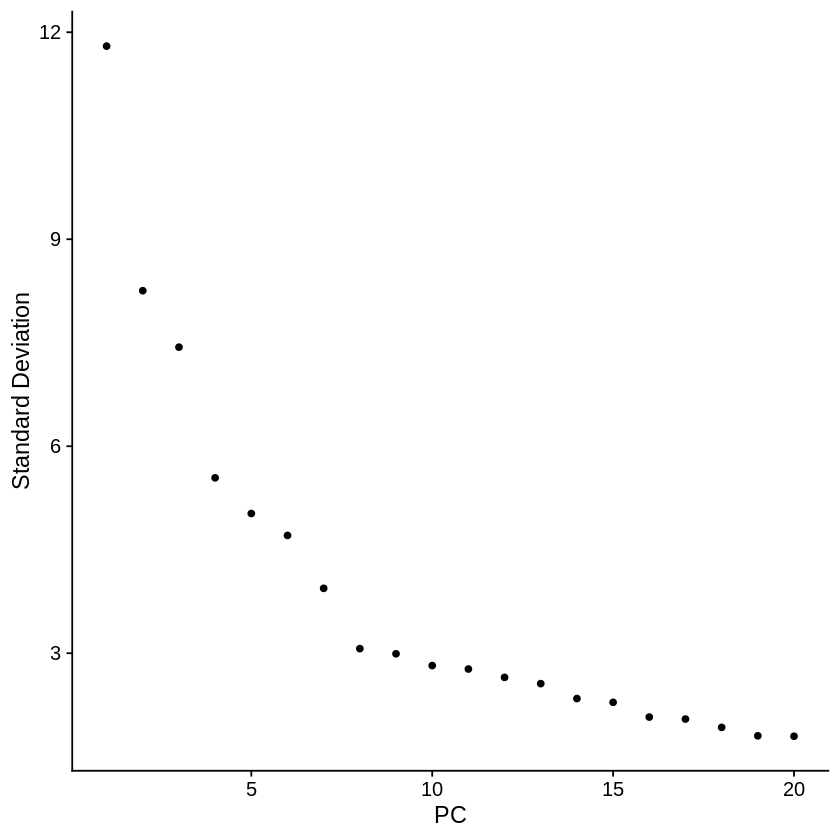

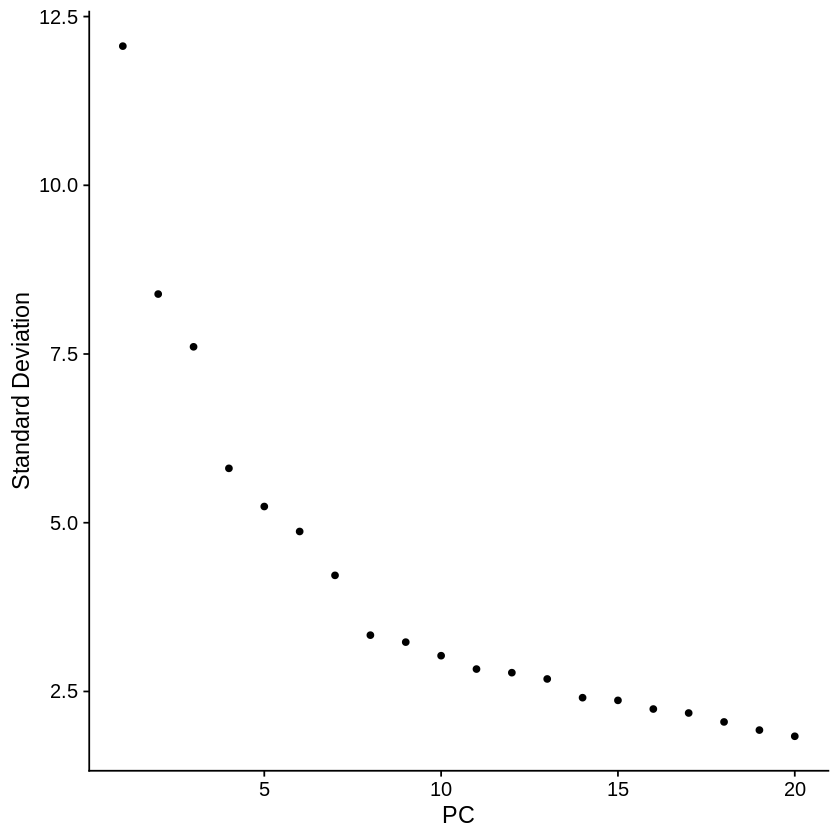

In [54]:
# Which PCAs should we include in our analyses? 
ElbowPlot(object = filt_GE_select.intergrated, ndims = 20)
ElbowPlot(object = filt_gte_brain.intergrated, ndims = 20)

    # estimate that ~PC8-10 would be a good threshold

> We can calculate where the principal components start to elbow by taking the larger value of: (1) The point where the principal components only contribute 5% of standard deviation and the principal components cumulatively contribute 90% of the standard deviation. (2) The point where the percent change in variation between the consecutive PCs is less than 0.1%.

In [ ]:
# Determine percent of variation associated with each PC
pct <- filt_GE_select[["pca"]]@stdev / sum(filt_GE_select[["pca"]]@stdev) * 100

# Calculate cumulative percents for each PC
cumu <- cumsum(pct)

# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]
co1

# Determine the difference between variation of PC and subsequent PC
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1

# last point where change of % of variation is more than 0.1%.
co2

# Minimum of the two calculation
pcs <- min(co1, co2)

pcs

# Create a dataframe with values
plot_df <- data.frame(pct = pct, 
           cumu = cumu, 
           rank = 1:length(pct))

# Elbow plot to visualize 
  ggplot(plot_df, aes(cumu, pct, label = rank, color = rank > pcs)) + 
  geom_text() + 
  geom_vline(xintercept = 90, color = "grey") + 
  geom_hline(yintercept = min(pct[pct > 5]), color = "grey") +
  theme_bw()

In [14]:
# takes around 10 minutes
# Determine the K-nearest neighbor graph (with first 20 PCAs)
filt_gte_brain.intergrated <- FindNeighbors(filt_gte_brain.intergrated,dims=1:20,reduction="pca")

# Determine the clusters with default resolution (0.8)
filt_gte_brain.intergrated <- FindClusters(filt_gte_brain.intergrated)

# You can view different resolutions using:
#Idents(object = filt_GE_select.intergrated) <- "integrated_snn_res.0.8"

save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.dat")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36558
Number of edges: 1321277

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8836
Number of communities: 22
Elapsed time: 19 seconds


In [47]:
# Determine the K-nearest neighbor graph (with first 20 PCAs)
filt_GE_select.intergrated <- FindNeighbors(filt_GE_select.intergrated,dims=1:20,reduction="pca")

# Determine the clusters with default resolution (0.8)
filt_GE_select.intergrated <- FindClusters(filt_GE_select.intergrated)

# You can view different resolutions using:
#Idents(object = filt_gte_brain.intergrated) <- "integrated_snn_res.0.8"

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36558
Number of edges: 1328858

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8853
Number of communities: 22
Elapsed time: 10 seconds


In [49]:
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.dat")

#### Plot UMAPs

In [28]:
sampleNames_ordered <- list("SF11159_1", "SF11159_2", "SF11209_GBM1", "SF11209_GBM2", "SF22215_GBM1", "SF22215_GBM2", "SF11232_1", "SF11232_2", "Tumor2_1", "Tumor2_2", "TQ1", "TQ2")

In [28]:
# Redo the levels of seq_folders so they're in the correct order
filt_gte_brain.intergrated@meta.data$seq_folder <- factor(filt_gte_brain.intergrated@meta.data$seq_folder, levels = c("9", "1", "2", "3", "8", "5", "11", "6", "12", "10", "7", "4"))

In [30]:
save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
save(filt_gte_brain.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.dat")

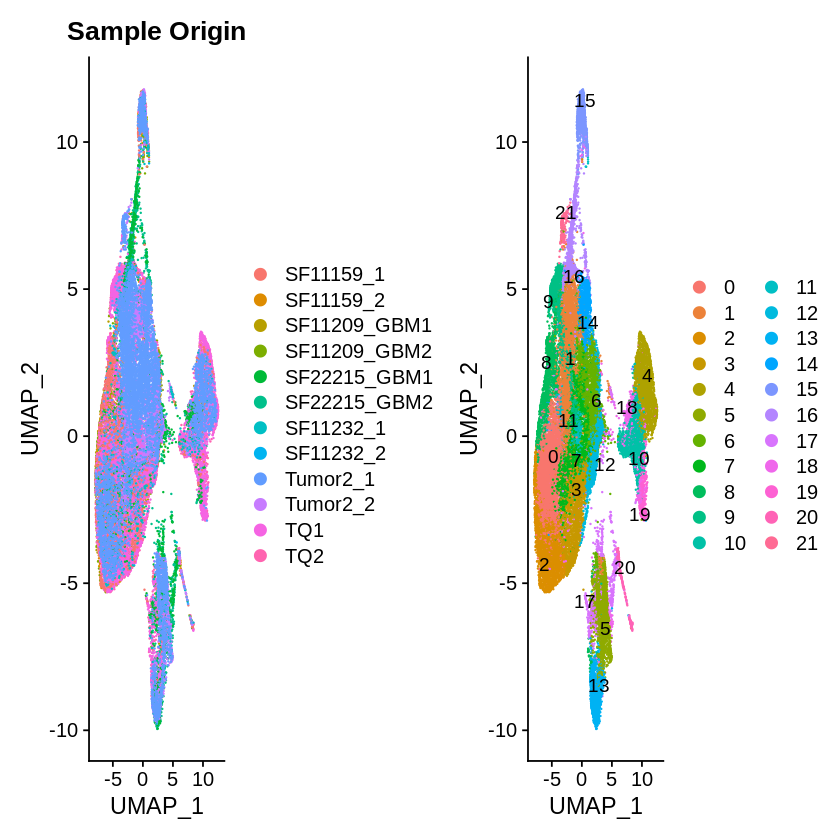

In [44]:
# Visualization of genes 
p1 <- DimPlot(filt_gte_brain.intergrated, reduction = "umap", group.by = "seq_folder") + 
    scale_colour_discrete(labels=sampleNames_ordered) + 
    ggtitle("Sample Origin")
p2 <- DimPlot(filt_gte_brain.intergrated, reduction = "umap", label = TRUE, repel = TRUE) + 
    ggtitle("Clusters")
p1 + p2

In [45]:
# Save UMAP for genes + retrotransposons
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_TE_UMAP.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow = 1, top="UMAP of Filtered Genes + Retrotransposons")
dev.off()

png 
  2

In [48]:
# Redo the levels of seq_folders so they're in the correct order
filt_GE_select.intergrated@meta.data$seq_folder <- factor(filt_GE_select.intergrated@meta.data$seq_folder, levels = c("9", "1", "2", "3", "8", "5", "11", "6", "12", "10", "7", "4"))

In [49]:
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")
save(filt_GE_select.intergrated,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.dat")

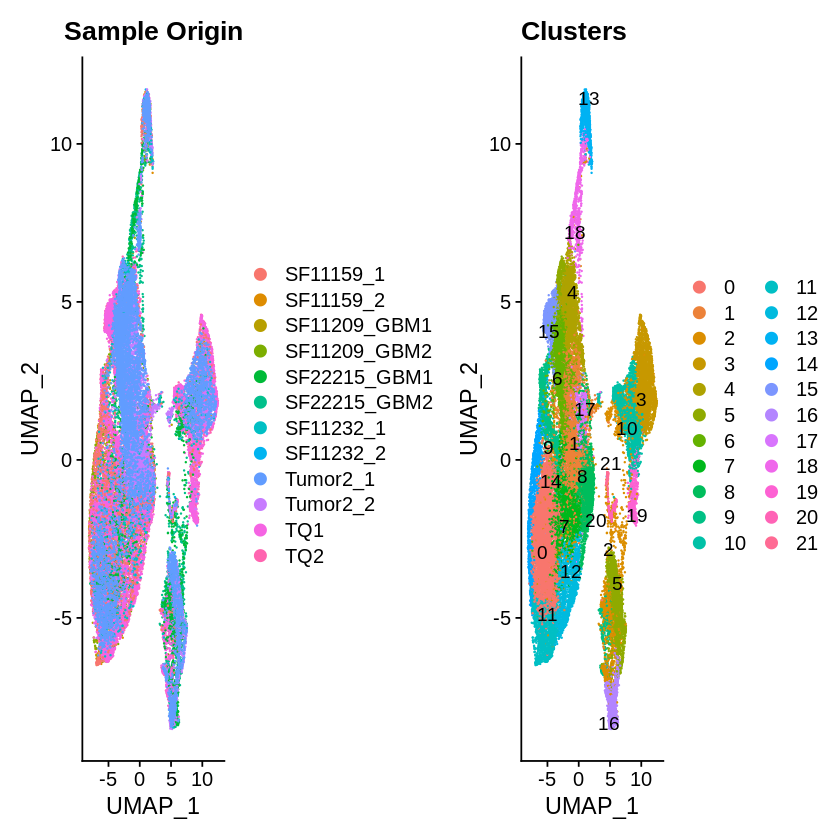

In [50]:
# Visualization of genes 
p1 <- DimPlot(filt_GE_select.intergrated, reduction = "umap", group.by = "seq_folder") + 
    scale_colour_discrete(labels=sampleNames_ordered) + 
    ggtitle("Sample Origin")
p2 <- DimPlot(filt_GE_select.intergrated, reduction = "umap", label = TRUE, repel = TRUE) + 
    ggtitle("Clusters")
p1 + p2

In [51]:
# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_UMAP.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow = 1, top="UMAP of Filtered & Subsetted Genes")
dev.off()

png 
  2

Plot clustered UMAPs in the same figure

In [6]:
p1 <- DimPlot(filt_GE_select.intergrated, reduction = "umap", label = TRUE, repel = TRUE) + 
    ggtitle("Reference Genes")
p2 <- DimPlot(filt_gte_brain.intergrated, reduction = "umap", label = TRUE, repel = TRUE) + 
    ggtitle("Reference Genes + Retrotransposons")

size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_GE_TE_UMAP.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow = 1, top="Clusters identified in Reference Genes + Retrotransposons\nresolution:0.8")
dev.off()

png 
  2

Plot Genes + Retrotransposon cluster labels onto Genes UMAP space

In [10]:
filt_GE_select.intergrated_v2 <- filt_GE_select.intergrated

filt_GE_select.intergrated_v2@active.ident <- filt_gte_brain.intergrated@active.ident

p1 <- DimPlot(filt_GE_select.intergrated, reduction = "umap", label = TRUE, repel = TRUE) + 
    ggtitle("Gene Clusters")
p2 <- DimPlot(filt_GE_select.intergrated_v2, reduction="umap", label=TRUE, repel = TRUE) + ggtitle("Genes with Genes + Retrotransposon cluster labels")

size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_GE_TE_UMAP_MatchingClusters.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow = 1, top="Matching Clusters Labels\nresolution:0.8")
dev.off()

png 
  2

#### Exploration of Quality Control metrics on Integrated Data

Make sure there are no artefacts from other factors such as:
- Distribution of cell clusters per sample
- Cell cycle phase
- mitochondrial expression

In [31]:
# Extract identity and sample information from seurat object to determine the number of cells per cluster per sample
n_cells_GE_select <- FetchData(filt_GE_select.intergrated, vars = c("ident", "seq_folder")) %>%
        dplyr::count(ident, seq_folder) %>%
        tidyr::spread(ident, n)

# View(n_cells_GE_select)

In [11]:
sampleClusters <- DimPlot(filt_GE_select.intergrated, label = TRUE, split.by = "sample", ncol = 4)  + NoLegend()

In [12]:
# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_SampleDistribution.pdf", width = size*2, height = size)
grid.arrange(sampleClusters, nrow = 1, top="Distribution of cell clusters per sample (Genes)")
dev.off()

png 
  2

In [43]:
#Repeat for Genes + Retrotransposons
sampleClusters <- DimPlot(filt_gte_brain.intergrated, label = TRUE, split.by = "sample", ncol = 4)  + NoLegend()

# Save UMAP for genes + retrotransposons
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_TE_SampleDistribution.pdf", width = size*2, height = size)
grid.arrange(sampleClusters, nrow = 1, top="Distribution of cell clusters per sample (Genes + Retrotransposons)")
dev.off()

png 
  2

In [13]:
# Explore whether clusters segregate by quality control metrics
# Determine metrics to plot present in seurat_integrated@meta.data
metrics <-  c("nCount_RNA", "nFeature_RNA", "mitoRatio")

qcClusters <- FeaturePlot(filt_GE_select.intergrated, 
            reduction = "umap", 
            features = metrics,
            pt.size = 0.4, 
            order = TRUE,
            min.cutoff = 'q10',
            label = TRUE) 

# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_QCmetrics.pdf", width = size*2, height = size*2)
qcClusters
dev.off()

png 
  2

In [56]:
# Explore whether clusters segregate by quality control metrics
# Determine metrics to plot present in seurat_integrated@meta.data
metrics <-  c("nCount_RNA", "nFeature_RNA", "mitoRatio")

qcClusters <- FeaturePlot(filt_gte_brain.intergrated, 
            reduction = "umap", 
            features = metrics,
            pt.size = 0.4, 
            order = TRUE,
            min.cutoff = 'q10',
            label = TRUE) 

# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_TE_QCmetrics.pdf", width = size*2, height = size*2)
qcClusters
dev.off()

png 
  2

### Manual PCA and Clustering (didn't run)

Create clusters for reference genome mapped reads

In [27]:
preclust <- filt_GE_select.intergrated@active.ident
clust_num <- length(unique(preclust))
ratio <- vector("list",clust_num)
names(ratio) <- 1:clust_num
ratio -> pval
ratio -> dif_gene_1p25_pval005_brain
row_count <- nrow(filt_GE_select.intergrated@assays$RNA)
col_count <- ncol(filt_GE_select.intergrated@assays$RNA)

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[1:5000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[5001:10000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[10001:15000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[15001:20000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[20001:25000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[25001:30000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_GE_select.intergrated@assays$RNA[30001:row_count,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

save(ratio,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/ratio_GE_select.dat")
save(pval,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/pval_GE_select.dat")
save(ratio,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/ratio_GE_select.RData")
save(pval,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/pval_GE_select.RData")

In [28]:
for(i in (1:clust_num)-1){
      dif_gene_1p25_pval005_brain[[(i+1)]] <- rownames(exp)[which(ratio[[(i+1)]] > log2(1.25) & pval[[(i+1)]][,3] < 0.05)]
}

save(dif_gene_1p25_pval005_brain,file="dif_gene_GE_select.Rdata")
save(dif_gene_1p25_pval005_brain,file="dif_gene_GE_select.dat")

Create clusters for reference genome + retrotransposon mapped reads

In [ ]:
preclust <- filt_gte_brain.intergrated@active.ident
clust_num <- length(unique(preclust))
ratio <- vector("list",clust_num)
names(ratio) <- 1:clust_num
ratio -> pval
ratio -> dif_gene_gte_brain
row_count <- nrow(filt_gte_brain.intergrated@assays$RNA)
col_count <- ncol(filt_gte_brain.intergrated@assays$RNA)

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[1:5000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[5001:10000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[10001:15000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[15001:20000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[20001:25000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[25001:30000,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

exp <- as.matrix(filt_gte_brain.intergrated@assays$RNA[30001:row_count,1:col_count])
for(i in (1:clust_num)-1){
      samp <- numeric(col_count)
      samp[which(preclust==i)] <- 1
      ratio[[(i+1)]] <- c(ratio[[(i+1)]],rowMeans(exp[,which(samp==1)]) - rowMeans(exp[,which(samp==0)]))
      pval[[(i+1)]]  <- rbind(pval[[(i+1)]],rowttests(as.matrix(exp),fac=factor(samp)))
}

save(ratio,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/ratio_gte_select.dat")
save(pval,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/pval_gte_select.dat")
save(ratio,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/ratio_gte_select.RData")
save(pval,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/pval_gte_select.RData")

### Exploring Known Cell-Type Markers
guided by Yoshiaki

#### GBM subtype markers
Plot gene expression: ASCL1, OLIG2, EGFR, GFAP, TGFB1 and RELB

In [21]:
match(c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', 'TGFB1', 'RELB'), rownames(filt_gte_brain.intergrated))
match(c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', 'TGFB1', 'RELB'), rownames(filt_GE_select.intergrated))

[1]  873 1330 1720   91   NA   NA

[1]  856 1299 1160  180   NA   NA

In [60]:
match(c("TGFB1","RELB"),rownames(filt_gte_brain.intergrated@assays$RNA))

[1] 27319 27442

Warning message:
"Could not find TGFB1 in the default search locations, found in RNA assay instead"
Warning message:
"Could not find RELB in the default search locations, found in RNA assay instead"


png 
  2

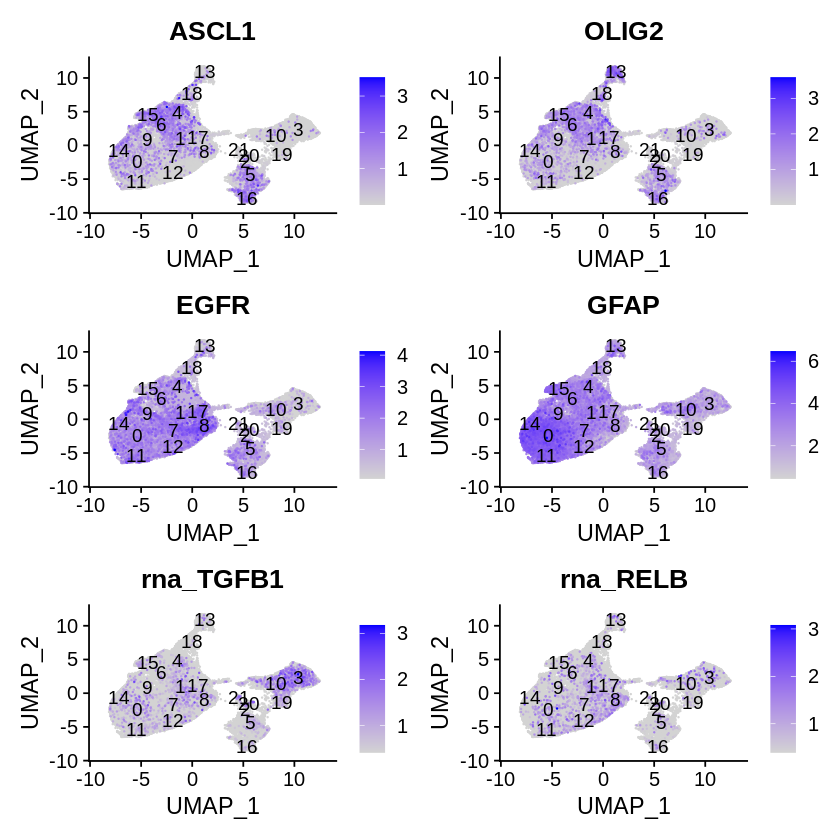

In [63]:
p <- FeaturePlot(filt_GE_select.intergrated, 
            reduction = "umap", 
            features = c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', "TGFB1","RELB"), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)
p 

# Save UMAP for genes
size = 4
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_GBMsubtypeMarkers.pdf", width = size*2, height = size*3)
p
dev.off()

Warning message:
"Could not find TGFB1 in the default search locations, found in RNA assay instead"
Warning message:
"Could not find RELB in the default search locations, found in RNA assay instead"


png 
  2

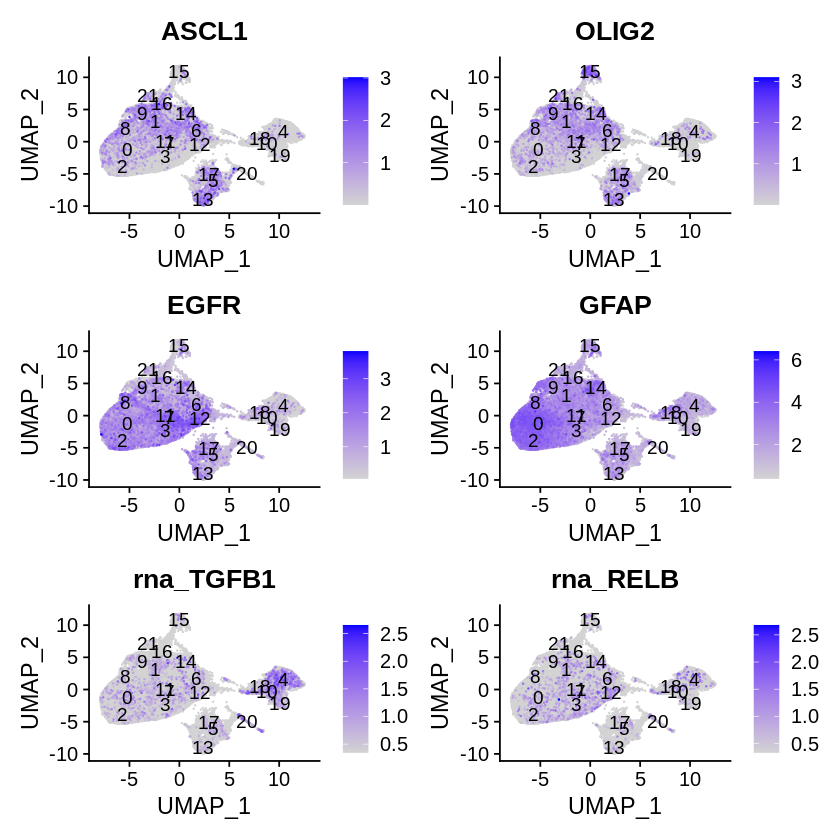

In [64]:
p <- FeaturePlot(filt_gte_brain.intergrated, 
            reduction = "umap", 
            features = c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', "TGFB1","RELB"), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)

p 

# Save UMAP for genes
size = 4
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_TE_GBMsubtypeMarkers.pdf", width = size*2, height = size*3)
p
dev.off()

#### Cell Cyle Markers
TOP2A, MKI67, PCNA, and MCM6

In [14]:
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(filt_gte_brain.intergrated))
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(filt_GE_select.intergrated))

[1]  30  66 920  NA

[1]   29   61  895 1820

In [15]:
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(filt_gte_brain.intergrated@assays$RNA))

[1] 24610 16127 28135  4218

png 
  2

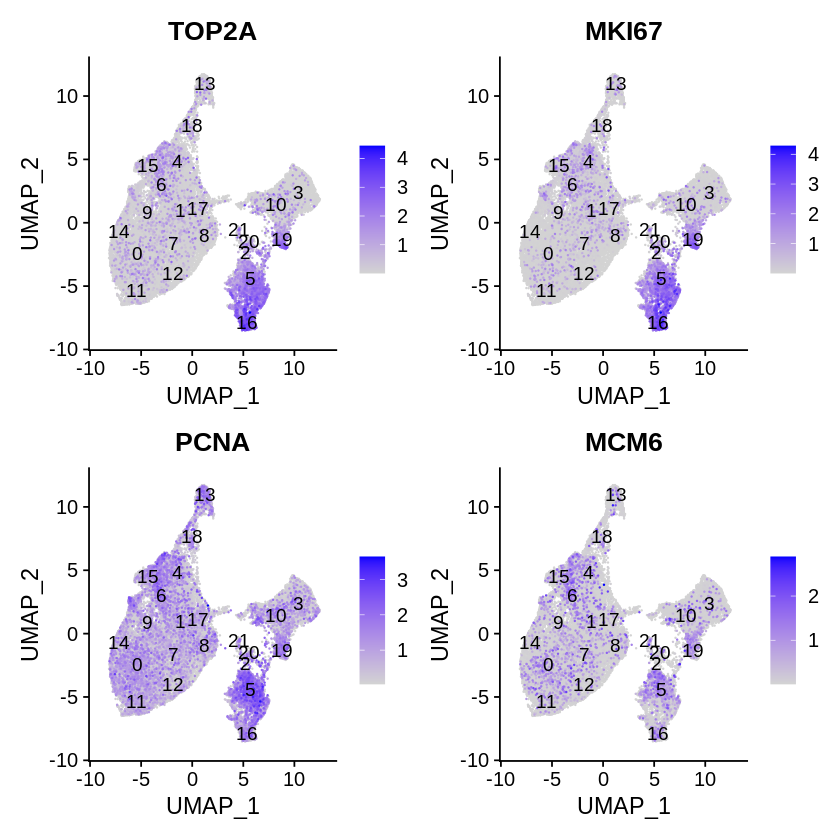

In [16]:
p <- FeaturePlot(filt_GE_select.intergrated, 
            reduction = "umap", 
            features = c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)
p 

# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_CCMarkers.pdf", width = size, height = size)
p
dev.off()

Warning message:
"Could not find MCM6 in the default search locations, found in RNA assay instead"


png 
  2

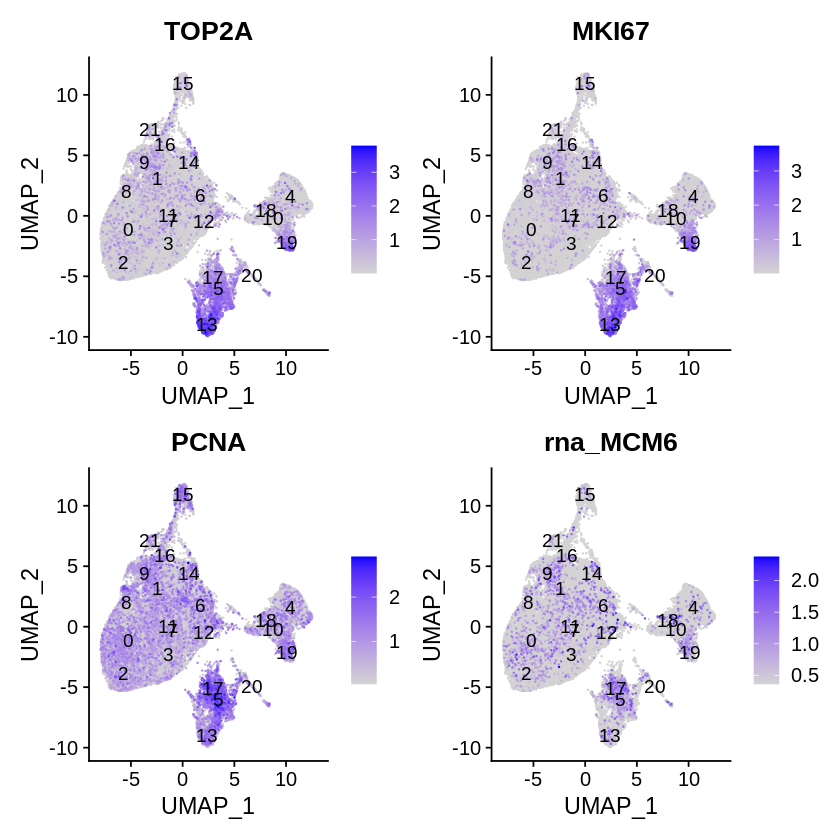

In [17]:
p <- FeaturePlot(filt_gte_brain.intergrated, 
            reduction = "umap", 
            features = c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)

p 

# Save UMAP for genes + retrotransposons
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_TE_CCMarkers.pdf", width = size, height = size)
p
dev.off()

#### Prom1 (CD133) Cancer Stem Cell Marker

In [20]:
match(c('PROM1'), rownames(filt_gte_brain.intergrated))
match(c('PROM1'), rownames(filt_GE_select.intergrated))

match(c('PROM1'), rownames(filt_gte_brain.intergrated@assays$RNA))
match(c('PROM1'), rownames(filt_GE_select.intergrated@assays$RNA))

[1] NA

[1] NA

[1] 6993

[1] 7036

Warning message:
"Could not find PROM1 in the default search locations, found in RNA assay instead"
Warning message:
"Could not find PROM1 in the default search locations, found in RNA assay instead"


png 
  2

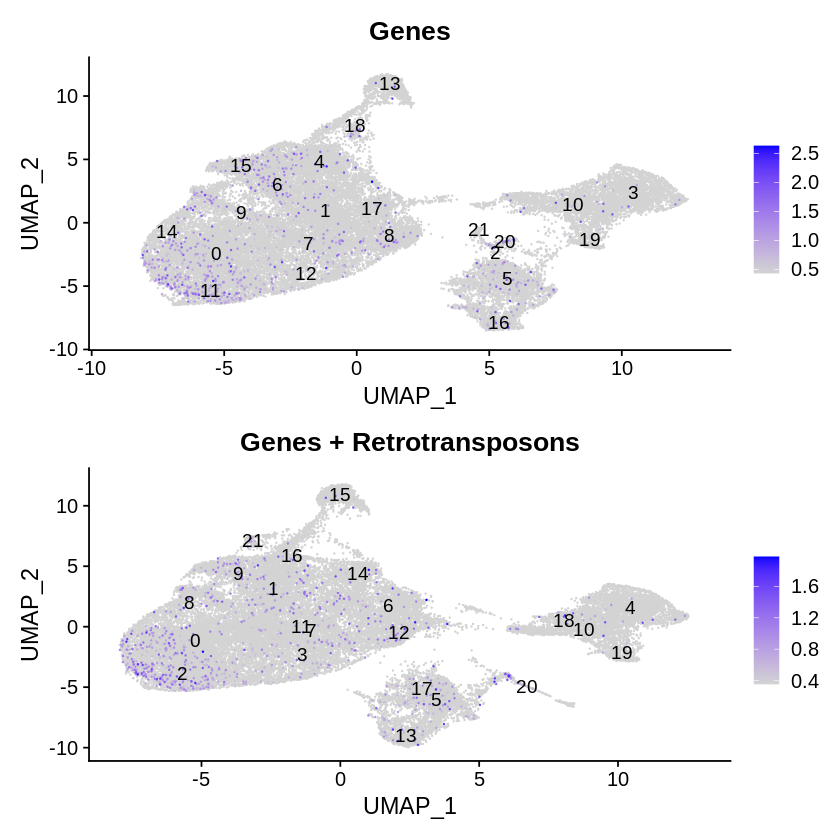

In [22]:
p1 <- FeaturePlot(filt_GE_select.intergrated, 
            reduction = "umap", 
            features = c('PROM1'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE) + ggtitle("Genes")
p2 <- FeaturePlot(filt_gte_brain.intergrated, 
            reduction = "umap", 
            features = c('PROM1'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE) + ggtitle("Genes + Retrotransposons")

p1 + p2 

# Save UMAP for genes + retrotransposons
size = 7
pdf("/home/samkyy/scratch/RetroTransposonAnalysis/figures/r_GE_GE_TE_CancerSCeMarker.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow = 1, top="Cancer Stem Cell Marker CD133\nresolution:0.8")
dev.off()

### Marker Identification (Differential Gene Expression Analysis) & Clustering
- [Single-cell RNA-seq: Marker identification | Introduction to Single-cell RNA-seq - ARCHIVED](https://hbctraining.github.io/scRNA-seq/lessons/09_merged_SC_marker_identification.html)
- [Differential expression testing](https://satijalab.org/seurat/archive/v3.0/de_vignette.html) <- A nicer way to structure the notebook

#### Identification of all markers for each cluster:
This analysis compares each cluster against all others and outputs the genes that are differentially expressed/present. *Useful for identifying unknown clusters and improving confidence in hypothesized cell types.* **This makes more sense for my dataset as there are only GBM specific samples.**

- test.use: Wilcoxon Rank Sum test (default)

In [23]:
# IMPORTANT: make sure to run differential gene expression analysis on raw data
DefaultAssay(filt_GE_select.intergrated) <- "RNA"
DefaultAssay(filt_gte_brain.intergrated) <- "RNA"

Run DGE on both datasets

In [24]:
cluster.markers <- FindAllMarkers(filt_GE_select.intergrated,
                               only.pos = TRUE, min.pct = 0.25, min.diff.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21



In [26]:
save(cluster.markers,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markers.RData")

In [27]:
# Run DGE on both datasets
cluster.markers_gte <- FindAllMarkers(filt_gte_brain.intergrated,
                               only.pos = TRUE, min.pct = 0.25, min.diff.pct = 0.25, logfc.threshold = 0.25)

save(cluster.markers_gte,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markers.RData")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"
Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21



In [28]:
# Show table with the highest expressed gene from each cluster
cluster.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)
cluster.markers_gte %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)  

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   0.000000e+00 2.365932   0.915 0.466  0.000000e+00 0       GFAP    
2   0.000000e+00 2.338292   0.858 0.319  0.000000e+00 0       ID3     
3   0.000000e+00 2.363063   0.594 0.071  0.000000e+00 1       IGLC1   
4   0.000000e+00 2.145766   0.569 0.063  0.000000e+00 1       IGLC2   
5   0.000000e+00 2.661107   0.813 0.505  0.000000e+00 2       HIST1H4C
6   0.000000e+00 2.289677   0.819 0.387  0.000000e+00 2       HMGB2   
7   0.000000e+00 4.227472   0.991 0.229  0.000000e+00 3       C1QB    
8   0.000000e+00 4.041884   0.990 0.212  0.000000e+00 3       C1QA    
9   0.000000e+00 1.813264   0.446 0.156  0.000000e+00 4       STMN2   
10  0.000000e+00 1.248237   0.596 0.214  0.000000e+00 4       CD24    
11  0.000000e+00 2.537517   0.937 0.500  0.000000e+00 5       HIST1H4C
12  0.000000e+00 1.782851   0.826 0.153  0.000000e+00 5       PCLAF   
13  0.000000e+00 2.069696   0.815 0.240  0.000000e+00 6       PDGFRA  
14  0.000000e+00 2.050372   0.869 0.243  0.000000e+00 6       BEX1    
15  0.000000e+00 2.447804   0.727 0.341  0.000000e+00 7       IGFBP5  
16  0.000000e+00 1.940037   0.724 0.278  0.000000e+00 7       VEGFA   
17  0.000000e+00 2.130597   0.474 0.160  0.000000e+00 8       NDRG1   
18 1.849103e-276 2.089306   0.583 0.286 5.776967e-272 8       VEGFA   
19  0.000000e+00 2.364378   0.758 0.444  0.000000e+00 9       CLINT1  
20  0.000000e+00 2.096023   0.733 0.335  0.000000e+00 9       UBLCP1  
21  0.000000e+00 3.485791   0.945 0.465  0.000000e+00 10      SPP1    
22  0.000000e+00 3.062483   0.683 0.183  0.000000e+00 10      PLIN2   
23  0.000000e+00 2.846057   0.876 0.229  0.000000e+00 11      SERPINA3
24 6.967450e-297 3.175324   0.334 0.078 2.176771e-292 11      SAA1    
25  0.000000e+00 3.162742   0.485 0.073  0.000000e+00 12      SAA1    
26  0.000000e+00 2.793733   0.975 0.431  0.000000e+00 12      SOD2    
27  0.000000e+00 6.471883   0.983 0.167  0.000000e+00 13      PLP1    
28  0.000000e+00 5.062002   0.983 0.150  0.000000e+00 13      PTGDS   
29  0.000000e+00 2.791490   0.990 0.712  0.000000e+00 14      CST3    
30  0.000000e+00 2.386095   0.912 0.387  0.000000e+00 14      HOPX    
31  0.000000e+00 2.313539   0.961 0.571  0.000000e+00 15      GAP43   
32  0.000000e+00 2.187268   0.994 0.616  0.000000e+00 15      PTPRZ1  
33  0.000000e+00 3.735440   0.996 0.171  0.000000e+00 16      CENPF   
34  0.000000e+00 3.305241   0.957 0.134  0.000000e+00 16      TOP2A   
35  0.000000e+00 4.852131   0.633 0.034  0.000000e+00 17      CXCL10  
36  0.000000e+00 3.733269   0.724 0.020  0.000000e+00 17      CXCL11  
37  0.000000e+00 3.297954   0.649 0.162  0.000000e+00 18      STMN2   
38 4.458432e-291 2.657315   0.876 0.473 1.392903e-286 18      SOX4    
39  0.000000e+00 3.158589   0.931 0.116  0.000000e+00 19      FCGBP   
40  0.000000e+00 2.737370   0.971 0.170  0.000000e+00 19      S100A9  
41  0.000000e+00 5.812949   0.989 0.021  0.000000e+00 20      CLDN5   
42 1.034955e-305 4.429504   0.951 0.127 3.233406e-301 20      IFI27   
43  0.000000e+00 4.556871   0.829 0.016  0.000000e+00 21      RGS5    
44 9.214475e-164 4.287949   0.837 0.127 2.878786e-159 21      COL4A1

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   0.000000e+00 2.194628   0.899 0.481  0.000000e+00 0       GFAP    
2   0.000000e+00 2.043551   0.852 0.335  0.000000e+00 0       ID3     
3   0.000000e+00 1.630170   0.462 0.164  0.000000e+00 1       CD37    
4   0.000000e+00 1.311594   0.460 0.084  0.000000e+00 1       IGLC1   
5   0.000000e+00 2.521116   0.797 0.210  0.000000e+00 2       SERPINA3
6   0.000000e+00 2.417344   0.927 0.530  0.000000e+00 2       CRYAB   
7   0.000000e+00 2.525971   0.866 0.323  0.000000e+00 3       IGFBP5  
8   0.000000e+00 2.291553   0.629 0.182  0.000000e+00 3       FN1     
9   0.000000e+00 4.095681   0.990 0.226  0.000000e+00 4       C1QB    
10  0.000000e+00 4.008186   0.802 0.133  0.000000e+00 4       CCL3    
11  0.000000e+00 2.580260   0.940 0.501  0.000000e+00 5       HIST1H4C
12  0.000000e+00 1.690431   0.877 0.152  0.000000e+00 5       PCLAF   
13  0.000000e+00 3.389004   0.842 0.394  0.000000e+00 6       7SK     
14  0.000000e+00 2.840836   0.779 0.279  0.000000e+00 6       PLCG2   
15 5.909825e-280 2.831344   0.395 0.117 1.901132e-275 7       IGKC    
16 8.303353e-276 2.404372   0.386 0.109 2.671106e-271 7       IGHM    
17  0.000000e+00 2.274709   0.978 0.708  0.000000e+00 8       CST3    
18  0.000000e+00 2.083862   0.877 0.380  0.000000e+00 8       HOPX    
19  0.000000e+00 1.892883   0.950 0.566  0.000000e+00 9       GAP43   
20  0.000000e+00 1.818596   0.997 0.611  0.000000e+00 9       PTPRZ1  
21  0.000000e+00 3.607859   0.963 0.465  0.000000e+00 10      SPP1    
22  0.000000e+00 2.998069   0.729 0.183  0.000000e+00 10      PLIN2   
23  0.000000e+00 4.056574   0.464 0.033  0.000000e+00 11      CXCL10  
24  0.000000e+00 3.301012   0.938 0.338  0.000000e+00 11      IGFBP5  
25  0.000000e+00 2.248097   0.582 0.160  0.000000e+00 12      NDRG1   
26 2.327753e-243 2.612118   0.607 0.289 7.488148e-239 12      AKAP12  
27  0.000000e+00 3.501841   0.988 0.166  0.000000e+00 13      CENPF   
28  0.000000e+00 3.041576   0.932 0.129  0.000000e+00 13      TOP2A   
29  0.000000e+00 6.101141   0.983 0.165  0.000000e+00 15      PLP1    
30  0.000000e+00 4.684654   0.981 0.149  0.000000e+00 15      PTGDS   
31  0.000000e+00 3.244067   0.727 0.155  0.000000e+00 16      STMN2   
32  0.000000e+00 2.705920   0.902 0.469  0.000000e+00 16      SOX4    
33  0.000000e+00 3.009646   0.928 0.515  0.000000e+00 17      HIST1H4C
34  0.000000e+00 2.409537   0.934 0.402  0.000000e+00 17      HMGB2   
35 4.202135e-138 1.417219   0.772 0.476 1.351785e-133 18      SOX4    
36 2.959222e-110 1.144510   0.441 0.178 9.519520e-106 18      TMSB15A 
37  0.000000e+00 3.135459   0.939 0.116  0.000000e+00 19      FCGBP   
38  0.000000e+00 2.810235   1.000 0.269  0.000000e+00 19      C1QB    
39  0.000000e+00 4.585121   0.613 0.021  0.000000e+00 20      CLDN5   
40  0.000000e+00 3.653532   0.695 0.013  0.000000e+00 20      RGS5    
41  0.000000e+00 3.050807   0.831 0.084  0.000000e+00 21      BCAS1   
42 1.629334e-152 3.091674   0.896 0.297 5.241406e-148 21      SIRT2

- p_val: p-value not adjusted for multiple test correction for condition
- avg_logFC: average log2 fold change for condition. Positive values indicate that the gene is more highly expressed in the cluster.
- pct.1: percentage of cells where the gene is detected in the cluster for condition
- pct.2: percentage of cells where the gene is detected on average in the other clusters for condition
- p_val_adj: adjusted p-value for condition, based on bonferroni correction using all genes in the dataset, used to determine significance

In [32]:
csv_GE <- cluster.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
csv_GTE <- cluster.markers_gte %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)  

In [35]:
# Export dataframe of top 5 genes per cluster for each dataframe
write.csv(csv_GE,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_clustermarkers.csv", row.names= TRUE)
write.csv(csv_GTE,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GTE_clustermarkers.csv", row.names= TRUE)

#### Identification of conserved markers for each cluster (todo)
This analysis looks for genes that are differentially expressed/present within each condition first, and then reports those genes that are conserved in the cluster across all conditions. These genes can help to figure out the identity for the cluster.
*Useful with **more than one condition** to identify cell type markers that are conserved across conditions.*

#### Marker identification between specific clusters
This analysis explores differentially expressed genes between specific clusters.
*Useful for determining differences in gene expression between clusters that appear to be representing the same celltype (i.e with markers that are similar) from the above analyses.*

In [6]:
# IMPORTANT: make sure to run differential gene expression analysis on raw data
DefaultAssay(filt_GE_select.intergrated) <- "RNA"
DefaultAssay(filt_gte_brain.intergrated) <- "RNA"

In [29]:
gbm.classical.markers <- FindMarkers(filt_GE_select.intergrated,
                           ident.1 = c(0, 11, 12, 14, 7, 9, 1, 17, 8), # Potential Classical subtype clusters
                           ident.2 = NULL, #against all other cells
                           only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

In [30]:
save(gbm.classical.markers,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markersC.RData")
csv_GE_gbm_c <- gbm.classical.markers %>% top_n(n = 10, wt = avg_log2FC)
write.csv(csv_GE_gbm_c,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markersC.csv", row.names= TRUE)

In [31]:
gbm.proneural.markers <- FindMarkers(filt_GE_select.intergrated,
                           ident.1 = c(6, 15, 4, 13), # Potential Proneural subtype clusters
                           ident.2 = NULL, #against all other cells
                           only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

save(gbm.proneural.markers,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markersP.RData")
csv_GE_gbm_p <- gbm.proneural.markers %>% top_n(n = 10, wt = avg_log2FC)
write.csv(csv_GE_gbm_p,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markersP.csv", row.names= TRUE)

In [32]:
gbm.mesen.markers <- FindMarkers(filt_GE_select.intergrated,
                           ident.1 = c(3, 10), # Potential Mesenchymal subtype clusters
                           ident.2 = NULL, #against all other cells
                           only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

save(gbm.mesen.markers,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markersM.RData")
csv_GE_gbm_m <- gbm.mesen.markers %>% top_n(n = 10, wt = avg_log2FC)
write.csv(csv_GE_gbm_m,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markersM.csv", row.names= TRUE)

In [28]:
gbm.classical.markers_gte <- FindMarkers(filt_gte_brain.intergrated,
                           ident.1 = c(0, 2, 3, 8, 11, 12), # Potential Classical subtype clusters
                           ident.2 = NULL, #against all other cells
                           only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

save(gbm.classical.markers_gte,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markersC.RData")
csv_GTE_gbm_c <- gbm.classical.markers_gte %>% top_n(n = 10, wt = avg_log2FC)
write.csv(csv_GTE_gbm_c,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markersC.csv", row.names= TRUE)

gbm.proneural.markers_gte <- FindMarkers(filt_gte_brain.intergrated,
                           ident.1 = c(1, 6, 9, 14, 15, 16, 21), # Potential Proneural subtype clusters
                           ident.2 = NULL, #against all other cells
                           only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

save(gbm.proneural.markers_gte,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markersP.RData")
csv_GTE_gbm_p <- gbm.proneural.markers_gte %>% top_n(n = 10, wt = avg_log2FC)
write.csv(csv_GTE_gbm_p,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markersP.csv", row.names= TRUE)

gbm.mesen.markers_gte <- FindMarkers(filt_gte_brain.intergrated,
                           ident.1 = c(4, 10, 18, 19), # Potential Mesenchymal subtype clusters
                           ident.2 = NULL, #against all other cells
                           only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

save(gbm.mesen.markers_gte,file="/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markersM.RData")
csv_GTE_gbm_m <- gbm.mesen.markers_gte %>% top_n(n = 10, wt = avg_log2FC)
write.csv(csv_GTE_gbm_m,"/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markersM.csv", row.names= TRUE)

## Gene Ontology

Convert gene_id's from integrated dataset, to entrez id's (make the column).
- [AnnotationDb Vignette](https://bioconductor.org/packages/release/bioc/vignettes/AnnotationDbi/inst/doc/IntroToAnnotationPackages.pdf)
- [org.Hs.eg.db man](http://bioconductor.org/packages/release/data/annotation/manuals/org.Hs.eg.db/man/org.Hs.eg.db.pdf)
- [Gene Ontology enrichment analysis - Dave Tang's blog](file:///C:/Users/Sam/Zotero/storage/PGPHVSC7/gene-ontology-enrichment-analysis.html)
- [Muris network analysis](https://github.com/massonix/tabula_muris_networks/blob/master/tabula_muris_network_analysis.Rmd)
- [Finding Differentially Expressed Genes with DESeq2](https://www.youtube.com/watch?v=ZjMfiPLuwN4), then [Gene Ontology (GO) Enrichment Analysis](https://www.youtube.com/watch?v=BZyi8L7vBuc)
- [SINGLE CELL RNA-SEQ WORKSHOP MODULE 1 (CLUSTERING 2.7K PBMCs)](https://rstudio-pubs-static.s3.amazonaws.com/349660_87eb2035e4ab465b899e0989bfe15007.html)
- [single cell 10x single-cell analysis - part6](https://ucdavis-bioinformatics-training.github.io/2017_2018-single-cell-RNA-sequencing-Workshop-UCD_UCB_UCSF/day3/scRNA_Workshop-PART6.html)

### Load libraries and data

In [36]:
# load libraries
library(GOstats)
library(org.Hs.eg.db)

# BiocManager::install("biomaRt")
# library(biomaRt) # package containing Ensembl datasets of various organisms 

Loading required package: Category

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: graph


Attaching package: ‘GOstats’


The following object is masked from ‘package:AnnotationDbi’:

    makeGOGraph






In [14]:
# load cluster.markers for GE dataset
load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markers.RData") 
# load cluster.markers_gte for GTE combined dataset
load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markers.RData")

After filtering out low complexity cells (<100 genes) and genes with no counts (expressed in <1 cell), we started with 30244 genes and 59540 cells. 

In differential gene analysis, features that are very infrequently detected in either group of cells, or features that are expressed at similar average levels, are unlikely to be differentially expressed. The following parameters were used to narrow down and speed up the computation:

- `only.pos` = TRUE, `min.pct` = 0.25, `min.diff.pct` = 0.25, `logfc.threshold` = 0.25

Resulting number of DEGs across 22 clusters: 5197 genes

Resulting number of DEGs with unique entrez-ids: (see below)

In [20]:
dim(cluster.markers)
length(unique(rownames(cluster.markers)))

[1] 5197    7

[1] 5197

In [79]:
columns(org.Hs.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "MAP"          "OMIM"        
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"       "UNIGENE"     
[26] "UNIPROT"

In [34]:
setwd(resultsPath)
list.files()

[1] "2021-03-30"                           
 [2] "2021-03-31"                           
 [3] "2021-04-01"                           
 [4] "2021-04-06"                           
 [5] "2021-04-07"                           
 [6] "2021-04-19"                           
 [7] "2021-04-20"                           
 [8] "2021-04-22"                           
 [9] "2021-04-23"                           
[10] "2021-04-26"                           
[11] "2021-04-27"                           
[12] "all_go_analysis_v2_symbol.R"          
[13] "seurat_brain-data-exploration.nb.html"
[14] "seurat_brain-data-exploration.Rmd"    
[15] "seurat_brain-dataexpo.ipynb"          
[16] "seurat_brain-YT.R"                    
[17] "seurat_brain.R"

In [35]:
GOresults_clustered <- readRDS("2021-04-22/GOresults_clustered.rds")
GOresults_clustered_gte <- readRDS("2021-04-23/GOresults_clustered_gte.rds")

GOresults_total <- readRDS("2021-04-19/GOresults_total.rds")
GOresults_total_gte <- readRDS("2021-04-19/GOresults_total_gte.rds")
ls()

[1] "GOresults_clustered"     "GOresults_clustered_gte"
[3] "GOresults_total"         "GOresults_total_gte"    
[5] "GOtable_GE"              "mkdirToday"             
[7] "resultsPath"             "setwdToday"

### GO for retrotransposon DEGs

In [36]:
class <- c("BP","MF","CC")
ann <- "org.Hs.eg.db"

ref2eg <- org.Hs.egSYMBOL2EG
mapped_seqs <- mappedkeys(ref2eg)

universe <- ls(org.Hs.egSYMBOL)

Create list of clusters and there gene symbols

In [175]:
#### Extract clusters
cluster_id <- unique(as.character(cluster.markers$cluster))
if(length(cluster_id) == 0){
    print("no clusters")
    gene_id <- unique(as.character(cluster.markers$gene))
    if(length(gene_id) == 0){
        print("no genes")
    }
} else { 
    #### Extract genes by cluster and convert to entrez_id's
    print("extracting gene symbols by cluster")
    id <- vector("list", length = length(cluster_id))
    entrez_id <- vector("list", length = length(cluster_id))
    nonunique_id <- vector("list", length = length(cluster_id))
    
    for(i in 1:length(cluster_id)){
        
        id[[i]] <- cluster.markers$gene[which(cluster.markers$cluster == i -1)] #clusters are labelled 0-21
        id[[i]] <- intersect(id[[i]], mapped_seqs)
        
        entrez_id[[i]] <- na.omit(unique(as.list(unlist( ref2eg[id[[i]]] ) )))
        nonunique_id[[i]] <- length(id[[i]]) - length(entrez_id[[i]])
        print(paste0("Number of non-unique genes in cluster", i-1, " = ", nonunique_id[[i]]))
    }
    print("converted gene symbols to entrez ids")
}

# Extra code
# select(x, keys, columns, keytype,...)
#select(org.Hs.eg.db, cluster.markers$gene, c("ENTREZID"), "SYMBOL")
#tail(info4genes)

[1] "extracting gene symbols by cluster"
[1] "Number of non-unique genes in cluster0 = 0"
[1] "Number of non-unique genes in cluster1 = 0"
[1] "Number of non-unique genes in cluster2 = 0"
[1] "Number of non-unique genes in cluster3 = 0"
[1] "Number of non-unique genes in cluster4 = 0"
[1] "Number of non-unique genes in cluster5 = 0"
[1] "Number of non-unique genes in cluster6 = 0"
[1] "Number of non-unique genes in cluster7 = 0"
[1] "Number of non-unique genes in cluster8 = 0"
[1] "Number of non-unique genes in cluster9 = 0"
[1] "Number of non-unique genes in cluster10 = 0"
[1] "Number of non-unique genes in cluster11 = 0"
[1] "Number of non-unique genes in cluster12 = 0"
[1] "Number of non-unique genes in cluster13 = 0"
[1] "Number of non-unique genes in cluster14 = 0"
[1] "Number of non-unique genes in cluster15 = 0"
[1] "Number of non-unique genes in cluster16 = 0"
[1] "Number of non-unique genes in cluster17 = 0"
[1] "Number of non-unique genes in cluster18 = 0"
[1] "Number of non-

In [38]:
#### Create parameters for each cluster and each GO class ####
para <- list(NULL)
result <- vector("list", length = length(cluster_id)) # 22 lists + 4 nested lists (3 GO classes + 1 HyperGOresults object)

for (i in 1:length(cluster_id)) {
    for (j in 1:length(class)) {
        print(class[j])
        if (length(entrez_id[[i]]) > 0) {
            para <- new("GOHyperGParams",
                geneIds=entrez_id[[i]],
                universeGeneIds=universe, #is it better for this to be all genes from our annotations, or the genes expressed in our experiment only?
                annotation=ann,
                ontology=class[j],
                pvalueCutoff=1, # no cutoff basically
                conditional=F, 
                testDirection="over")
            #### Perform Hypergeometric tests ####
            rm(data)
            data <- hyperGTest(para)
            result[[i]][[4]][[j]] <- data # save the original file
            data <- summary(data)

            #### Multiple-Test Correction #### 
            if(nrow(data) == 0){
                # no correction
                result[[i]][[j]] <- NULL
            } else {
                # Adjust p-value in the same column
                data$p.adjusted <- p.adjust(data[,2], "BH") #"fdr"
                data <- data[1:5,c(1:2, ncol(data), 3:(ncol(data)-1))] #re-arrange p.adjusted column next to pvalue column
                result[[i]][[j]]<- data
            }
        } else {
            result[[i]][[j]] <- NULL
            print(paste0("No differentially expressed genes in cluster ",i,". no GO computed."))
        }
    }
    print(paste0("Cluster:", i, "gene ontology analysis complete."))
}

[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"
Warning message in rm(data):
"object 'data' not found"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:1gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:2gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:3gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:4gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:5gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:6gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:7gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:8gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:9gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:10gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:11gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:12gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:13gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:14gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:15gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:16gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:17gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:18gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:19gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:20gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:21gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Cluster:22gene ontology analysis complete."


In [42]:
names(result) <- cluster_id
saveRDS(result,file="GOresults_clustered.rds")

Repeat Analysis for GE + TE combined dataset

In [46]:
#### Extract clusters
cluster_id <- unique(as.character(cluster.markers_gte$cluster))
print(cluster_id)
if(length(cluster_id) == 0){
    print("no clusters")
    gene_id <- unique(as.character(cluster.markers_gte$gene))
    if(length(gene_id) == 0){
        print("no genes")
    }
} else { 
    #### Extract genes by cluster and convert to entrez_id's
    print("extracting gene symbols by cluster")
    id <- vector("list", length = length(cluster_id))
    entrez_id <- vector("list", length = length(cluster_id))
    nonunique_id <- vector("list", length = length(cluster_id))
    
    for(i in 1:length(cluster_id)){
        n = as.numeric(cluster_id[i])
        id[[i]] <- cluster.markers_gte$gene[which(cluster.markers_gte$cluster == n)]
        id[[i]] <- intersect(id[[i]], mapped_seqs)
        
        
        entrez_id[[i]] <- na.omit(unique(as.list(unlist( ref2eg[id[[i]]] ) )))
        nonunique_id[[i]] <- length(id[[i]]) - length(entrez_id[[i]])
        print(paste0("Number of non-unique genes in cluster", n, " = ", nonunique_id[[i]]))
    }
    print("converted gene symbols to entrez ids")
}

 [1] "0"  "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "15"
[16] "16" "17" "18" "19" "20" "21"
[1] "extracting gene symbols by cluster"
[1] "Number of non-unique genes in cluster0 = 0"
[1] "Number of non-unique genes in cluster1 = 0"
[1] "Number of non-unique genes in cluster2 = 0"
[1] "Number of non-unique genes in cluster3 = 0"
[1] "Number of non-unique genes in cluster4 = 0"
[1] "Number of non-unique genes in cluster5 = 0"
[1] "Number of non-unique genes in cluster6 = 0"
[1] "Number of non-unique genes in cluster7 = 0"
[1] "Number of non-unique genes in cluster8 = 0"
[1] "Number of non-unique genes in cluster9 = 0"
[1] "Number of non-unique genes in cluster10 = 0"
[1] "Number of non-unique genes in cluster11 = 0"
[1] "Number of non-unique genes in cluster12 = 0"
[1] "Number of non-unique genes in cluster13 = 0"
[1] "Number of non-unique genes in cluster15 = 0"
[1] "Number of non-unique genes in cluster16 = 0"
[1] "Number of non-unique genes in cluster17 = 0"
[1] 

In [52]:
#### Create parameters for each cluster and each GO class ####
para <- list(NULL)
result_gte <- vector("list", length = length(cluster_id)) # 21 lists + 4 nested lists (3 GO classes + 1 HyperGOresults object)

for (i in 1:length(cluster_id)) {
    for (j in 1:length(class)) {
        print(class[j])
        n <- cluster_id[i]
        if (length(entrez_id[[i]]) > 0) {
            para <- new("GOHyperGParams",
                geneIds=entrez_id[[i]],
                universeGeneIds=universe, #is it better for this to be all genes from our annotations, or the genes expressed in our experiment only?
                annotation=ann,
                ontology=class[j],
                pvalueCutoff=1, # no cutoff basically
                conditional=F, 
                testDirection="over")
            #### Perform Hypergeometric tests ####
            data <- hyperGTest(para)
            result_gte[[i]][[4]][[j]] <- data # save the original file
            data <- summary(data)

            #### Multiple-Test Correction #### 
            if(nrow(data) == 0){
                # no correction
                result_gte[[i]][[j]] <- NULL
            } else {
                # Adjust p-value in the same column
                data$p.adjusted <- p.adjust(data[,2], "BH") #"fdr"
                data <- data[1:5,c(1:2, ncol(data), 3:(ncol(data)-1))] #re-arrange p.adjusted column next to pvalue column
                result_gte[[i]][[j]]<- data
            }
        } else {
            result_gte[[i]][[j]] <- NULL
            print(paste0("No differentially expressed genes in cluster ",n,". no GO computed."))
        }
    }
    print(paste0("Cluster:", n, "gene ontology analysis complete."))
    rm(data)
}

[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:0gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:1gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:2gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:3gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:4gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:5gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:6gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:7gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:8gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:9gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:10gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:11gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:12gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:13gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:15gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:16gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:17gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:18gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:19gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:20gene ontology analysis complete."
[1] "BP"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "MF"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "CC"


Warning message in makeValidParams(.Object):
“converting geneIds from list to atomic vector via unlist”


[1] "Cluster:21gene ontology analysis complete."


In [54]:
names(result_gte) <- cluster_id
saveRDS(result_gte,file="GOresults_clustered_gte.rds")

Perform GO analysis with all differentially expressed genes (not separated by clusters)

In [118]:
#### Extract gene symbols from all clusters to entrez_ids ####
gene_id <- unique(as.character(cluster.markers$gene))
if(length(gene_id) == 0){
    print("no genes")
}

rm(entrez_id)
rm(nonunique_id)

gene_id <- intersect(gene_id, mapped_seqs)
entrez_id <- na.omit(unique(as.list(unlist( ref2eg[gene_id] ) )))
nonunique_id <- length(gene_id) - length(entrez_id)

print(paste0("Number of non-unique = ", nonunique_id))
print("converted gene symbols to entrez ids")

#### GO analysis ####
para <- NULL
result_total <- vector("list", length = length(class))

 for (j in 1:length(class)) {
    print(class[j])
    if (length(entrez_id) > 0) {
        para <- new("GOHyperGParams",
            geneIds=entrez_id,
            universeGeneIds=universe, #is it better for this to be all genes from our annotations, or the genes expressed in our experiment only?
            annotation=ann,
            ontology=class[j],
            pvalueCutoff=1, # no cutoff basically
            conditional=F, 
            testDirection="over")
        #### Perform Hypergeometric tests ####
        rm(data)
        data <- hyperGTest(para)
        data <- summary(data)

        #### Multiple-Test Correction #### 
        if(nrow(data) == 0){
            # no correction
            result_total[[j]] <- NULL
        } else {
            # Adjust p-value in the same column
            data$p.adjusted <- p.adjust(data[,2], "BH") #"fdr"
            data <- data[1:5,c(1:2, ncol(data), 3:(ncol(data)-1))] #re-arrange p.adjusted column next to pvalue column
            result_total[[j]] <- data
        }
    } else {
        result_total[[j]] <- NULL
        print(paste0("No differentially expressed genes in this ontology. No output."))
    }
}
print(paste0("Gene ontology analysis complete."))

[1] "Number of non-unique = 0"
[1] "converted gene symbols to entrez ids"
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Gene ontology analysis complete."


In [120]:
saveRDS(result_total,file="/home/samkyy/scratch/gete-gbm/results/2021-04-19/GOresults_total.rds")

In [121]:
#### Extract gene symbols from all clusters to entrez_ids ####
gene_id <- unique(as.character(cluster.markers_gte$gene))
if(length(gene_id) == 0){
    print("no genes")
}

rm(entrez_id)
rm(nonunique_id)

gene_id <- intersect(gene_id, mapped_seqs)
entrez_id <- na.omit(unique(as.list(unlist( ref2eg[gene_id] ) )))
nonunique_id <- length(gene_id) - length(entrez_id)

print(paste0("Number of non-unique = ", nonunique_id))
print("converted gene symbols to entrez ids")

#### GO analysis ####
para <- NULL
result_total_gte <- vector("list", length = length(class))

 for (j in 1:length(class)) {
    print(class[j])
    if (length(entrez_id) > 0) {
        para <- new("GOHyperGParams",
            geneIds=entrez_id,
            universeGeneIds=universe, #is it better for this to be all genes from our annotations, or the genes expressed in our experiment only?
            annotation=ann,
            ontology=class[j],
            pvalueCutoff=1, # no cutoff basically
            conditional=F, 
            testDirection="over")
        #### Perform Hypergeometric tests ####
        rm(data)
        data <- hyperGTest(para)
        data <- summary(data)

        #### Multiple-Test Correction #### 
        if(nrow(data) == 0){
            # no correction
            result_total_gte[[j]] <- NULL
        } else {
            # Adjust p-value in the same column
            data$p.adjusted <- p.adjust(data[,2], "BH") #"fdr"
            data <- data[1:5,c(1:2, ncol(data), 3:(ncol(data)-1))] #re-arrange p.adjusted column next to pvalue column
            result_total_gte[[j]] <- data
        }
    } else {
        result_total_gte[[j]] <- NULL
        print(paste0("No differentially expressed genes in this ontology. No output."))
    }
}
print(paste0("Gene ontology analysis complete."))

[1] "Number of non-unique = 0"
[1] "converted gene symbols to entrez ids"
[1] "BP"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "MF"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "CC"


Warning message in makeValidParams(.Object):
"converting geneIds from list to atomic vector via unlist"


[1] "Gene ontology analysis complete."


In [122]:
saveRDS(result_total_gte,file="/home/samkyy/scratch/gete-gbm/results/2021-04-19/GOresults_total_gte.rds")

### Convert entrez_ids to gene symbols

In [133]:
### Test how to convert between entrez ids and gene symbols

# genesbycat_0_BP <- geneIdsByCategory(GOresults_clustered[[1]][[4]][[1]])
# length(genesbycat_0_BP$`GO:0007155`) #matches with the top go term in the first dataframe, so they seem to be listed in order
# eg <- genesbycat_0_BP$`GO:0007155`

### Convert Gene identifiers to Gene Symbols ###
# eg2ref <- org.Hs.egSYMBOL

# unlist(na.omit(unique(as.list(unlist( eg2ref[eg] ) ))))

[1] 25

[1] "CHL1"    "CNN3"    "COL6A1"  "CCDC80"  "GPM6B"   "ANXA1"   "ANXA2"  
 [8] "TNC"     "ID1"     "IGFBP7"  "APP"     "LGALS1"  "LGALS3"  "CD99"   
[15] "ATP1B2"  "NRCAM"   "PCDH9"   "PTN"     "S100A10" "DST"     "SPARCL1"
[22] "ACTN1"   "CD9"     "CD44"    "CD151"

In [10]:
### Function to return lists of Gene symbols for all GO terms in a cluster
### Input: List of GOHyperGResult objects (BP, MF, CC)
### Output: list of GO terms and the associated gene symbols
genesbyGO <- function(geneIds){ 
    eg2ref <- org.Hs.egSYMBOL
    result <- vector("list", length = 3)
    names(result) <- c("BP", "MF", "CC")
    for (j in 1:3) { # Loop through each Ontology class
        
        genesbycat <- geneIdsByCategory(geneIds[[j]])
        print(paste0("Number of GO terms in this cluster: ",length(genesbycat)))
        
        for (i in 1:length(genesbycat)){ # Loop through each GO term
            result[[j]][[i]] <- na.omit(unique(as.list(unlist( eg2ref[genesbycat[[i]]] ) ) ))
        }
        names(result[[j]]) <- names(genesbycat)
        print(paste0("completed class: ", j))
    }
    names(result) <- names(geneIds)
    print("Conversion complete")
    return(result)
}

### Convert entrez ids of all genes back to gene symbols using lapply loop on the GO classes for each cluster
### Input: list resulting from GO analysis (nested list of clusters and their summary dataframes and GOHyperGResult object)
### Output: nested list of clusters and their Ontology classes, GO terms and associated gene symbols. 
allGOgenes <- function (GOresults) {
    results <- vector("list", length = length(GOresults))
    for (i in 1:length(GOresults)) {
        print(paste0("Converting cluster ", i))
        class(GOresults[[i]][[4]])
        results[[i]] <- genesbyGO(GOresults[[i]][[4]])
    }
    names(results) <- names(GOresults)
    print("Conversion from entrez ids to gene symbols complete")
    return(results)
}

In [11]:
# a <- genesbyGO(GOresults_clustered[[1]][[4]])

genSymbols_GE <- allGOgenes(GOresults_clustered)
genSymbols_gte <- allGOgenes(GOresults_clustered_gte)

[1] "Converting cluster 1"
[1] "Number of GO terms in this cluster: 2652"
[1] "completed class: 1"
[1] "Number of GO terms in this cluster: 336"
[1] "completed class: 2"
[1] "Number of GO terms in this cluster: 344"
[1] "completed class: 3"
[1] "Conversion complete"
[1] "Converting cluster 2"
[1] "Number of GO terms in this cluster: 2653"
[1] "completed class: 1"
[1] "Number of GO terms in this cluster: 323"
[1] "completed class: 2"
[1] "Number of GO terms in this cluster: 254"
[1] "completed class: 3"
[1] "Conversion complete"
[1] "Converting cluster 3"
[1] "Number of GO terms in this cluster: 1208"
[1] "completed class: 1"
[1] "Number of GO terms in this cluster: 128"
[1] "completed class: 2"
[1] "Number of GO terms in this cluster: 93"
[1] "completed class: 3"
[1] "Conversion complete"
[1] "Converting cluster 4"
[1] "Number of GO terms in this cluster: 5174"
[1] "completed class: 1"
[1] "Number of GO terms in this cluster: 794"
[1] "completed class: 2"
[1] "Number of GO terms in thi

In [12]:
length(genSymbols_GE)
length(genSymbols_GE[[1]])
length(genSymbols_GE[[1]][[1]])

length(genSymbols_gte)
length(genSymbols_gte[[1]])
length(genSymbols_gte[[1]][[1]])

[1] 22

[1] 3

[1] 2652

[1] 21

[1] 3

[1] 2878

### GO results summaries

In [68]:
head(GOresults_total)
head(GOresults_total_gte)

[[1]]
      GOBPID       Pvalue   p.adjusted OddsRatio  ExpCount Count Size
1 GO:0048518 1.269525e-66 1.408538e-62  2.064460  926.7057  1330 6346
2 GO:0048522 6.781911e-65 3.762265e-61  2.067776  835.5831  1225 5722
3 GO:0050896 9.280419e-63 3.432208e-59  2.016748 1372.3890  1775 9398
4 GO:0016043 6.616801e-59 1.835335e-55  1.970858  952.9911  1333 6526
5 GO:0016477 3.654919e-58 7.574870e-55  2.712955  240.9493   482 1650
                                       Term
1 positive regulation of biological process
2   positive regulation of cellular process
3                      response to stimulus
4           cellular component organization
5                            cell migration

[[2]]
      GOMFID       Pvalue   p.adjusted OddsRatio   ExpCount Count  Size
1 GO:0005515 2.158577e-72 5.130939e-69  2.674912 2071.11895  2428 13697
2 GO:0050839 1.008375e-38 1.198454e-35  3.555893   82.25806   204   544
3 GO:0044877 9.172683e-34 7.267822e-31  2.342056  190.22177   351  1258
4 GO:0008092 5.540541e-33 3.292467e-30  2.531387  148.18548   291   980
5 GO:0019899 1.632414e-29 7.760498e-27  1.891254  344.30444   534  2277
                                Term
1                    protein binding
2     cell adhesion molecule binding
3 protein-containing complex binding
4       cytoskeletal protein binding
5                     enzyme binding

[[3]]
      GOCCID        Pvalue   p.adjusted OddsRatio  ExpCount Count  Size
1 GO:0005737 2.330795e-102 3.186196e-99  2.610091 1684.8673  2188 11620
2 GO:0070062  3.596021e-68 2.457880e-65  2.646910  314.2089   607  2167
3 GO:0031982  1.359450e-66 6.194563e-64  2.202242  590.5735   952  4073
4 GO:1903561  1.535568e-60 5.247805e-58  2.468906  331.8986   612  2289
5 GO:0043230  2.172349e-60 5.939201e-58  2.465638  332.1886   612  2291
                     Term
1               cytoplasm
2   extracellular exosome
3                 vesicle
4   extracellular vesicle
5 extracellular organelle

[[1]]
      GOBPID       Pvalue   p.adjusted OddsRatio ExpCount Count Size
1 GO:0016043 1.525571e-60 1.661957e-56  2.021025 901.1041  1278 6526
2 GO:0048518 1.239765e-58 6.752999e-55  2.002808 876.2499  1245 6346
3 GO:0071840 2.737118e-56 9.939386e-53  1.965473 927.4772  1292 6717
4 GO:0048522 2.794825e-55 7.611706e-52  1.983434 790.0885  1140 5722
5 GO:0010033 5.518814e-53 1.202439e-49  2.144760 467.3977   761 3385
                                           Term
1               cellular component organization
2     positive regulation of biological process
3 cellular component organization or biogenesis
4       positive regulation of cellular process
5                 response to organic substance

[[2]]
      GOMFID       Pvalue   p.adjusted OddsRatio  ExpCount Count  Size
1 GO:0005515 5.624357e-79 1.316100e-75  2.930140 1952.4494  2314 13697
2 GO:0050839 9.228560e-34 1.079742e-30  3.345149   77.5449   188   544
3 GO:0044877 3.214167e-31 2.507050e-28  2.303489  179.3226   330  1258
4 GO:0005488 3.801732e-30 2.224013e-27  2.619533 2341.7419  2493 16428
5 GO:0008092 6.083183e-28 2.846930e-25  2.394944  139.6949   267   980
                                Term
1                    protein binding
2     cell adhesion molecule binding
3 protein-containing complex binding
4                            binding
5       cytoskeletal protein binding

[[3]]
      GOCCID        Pvalue    p.adjusted OddsRatio  ExpCount Count  Size
1 GO:0005737 1.096258e-109 1.519413e-106  2.797507 1589.2172  2096 11620
2 GO:0031982  1.397096e-60  9.681876e-58  2.159554  557.0466   893  4073
3 GO:0070062  1.031105e-59  4.763706e-57  2.539414  296.3712   563  2167
4 GO:1903561  1.243763e-52  4.309639e-50  2.368295  313.0566   567  2289
5 GO:0043230  1.694756e-52  4.697864e-50  2.365236  313.3302   567  2291
                     Term
1               cytoplasm
2                 vesicle
3   extracellular exosome
4   extracellular vesicle
5 extracellular organelle

- Dataframes 1-3 show Biological Process, Molecular Function and Cellular Component respectively. 
- The first three dataframes are from the reference genes only, while the last three dataframes are from the genes + retrotransposon genes combined.
- **p.adjusted** - P-value adjusted with the Benjamin Hochberg multiple-test correction. 
- **OddsRatio** - odds of being GO term X | in significant set/odds of being GO term X | not in significant set
- **ExpCount** - Number of expected genes that would be categorized as this ontology term by chance.
- **Count** - The number of genes in our experiment that is labelled with the given GO term.
- **Size** - The number of genes in our gene universe annotated with the given GO term. 

In [94]:
printGenes <- function(x, cluster, numTerms = 5, numGenes = 5) {
    class <- c("BP", "MF", "CC")
    for (j in 1:length(class)) {
        cat("\nGenes in Gene Ontology Class", class[j], "\n")
        for (i in 1:numTerms) {
            cat(i,":", unlist(x[[cluster]][[j]][[i]][1:numGenes]), "\n")
        }
    }
}

#### GO results for Reference Genes

In [95]:
print(paste0("Gene Ontology for cluster: ", 0))
GOresults_clustered[[1]][[1]][,] #BP            
GOresults_clustered[[1]][[2]][,] #MF
GOresults_clustered[[1]][[3]][,] #CC

printGenes(genSymbols_GE, 1)

[1] "Gene Ontology for cluster: 0"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007155 2.199145e-09 2.649100e-06 5.156350   6.484787 25    1474
2 GO:0022610 2.423626e-09 2.649100e-06 5.129488   6.515584 25    1481
3 GO:0009611 3.100303e-09 2.649100e-06 7.313700   2.886038 17     656
4 GO:0048856 3.997133e-09 2.649100e-06 3.707319  26.902629 53    6115
5 GO:0009653 7.568147e-09 3.634632e-06 3.997664  12.371250 34    2812
  Term                              
1 cell adhesion                     
2 biological adhesion               
3 response to wounding              
4 anatomical structure development  
5 anatomical structure morphogenesis

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0005198 4.548257e-06 0.0009768042  4.974132 3.3015475 14    730 
2 GO:0050840 5.831667e-06 0.0009768042 22.456854 0.2577921  5     57 
3 GO:0005201 1.143517e-05 0.0012769270 10.294753 0.7643309  7    169 
4 GO:0005518 1.609910e-05 0.0013483000 17.952663 0.3165867  5     70 
5 GO:0050839 3.286303e-05 0.0022018228  5.083802 2.4603313 11    544 
  Term                                       
1 structural molecule activity               
2 extracellular matrix binding               
3 extracellular matrix structural constituent
4 collagen binding                           
5 cell adhesion molecule binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0062023 4.552163e-18 1.561392e-15 16.708084  1.833836 22     427
2 GO:0031012 1.390317e-16 2.384393e-14 13.096405  2.439389 23     568
3 GO:0070062 1.007121e-10 1.151475e-08  4.998018  9.306611 32    2167
4 GO:0030054 2.095399e-10 1.752882e-08  4.939361  8.988803 31    2093
5 GO:0005576 2.555222e-10 1.752882e-08  4.086705 20.034767 47    4665
  Term                                    
1 collagen-containing extracellular matrix
2 extracellular matrix                    
3 extracellular exosome                   
4 cell junction                           
5 extracellular region


Genes in Gene Ontology Class BP 
1 : CHL1 CNN3 COL6A1 CCDC80 GPM6B 
2 : CHL1 CNN3 COL6A1 CCDC80 GPM6B 
3 : F3 GAP43 ANXA1 ANXA2 TNC 
4 : RAMP1 CHL1 CHI3L1 SCRG1 CLU 
5 : RAMP1 CHL1 CHI3L1 CLU COL6A1 

Genes in Gene Ontology Class MF 
1 : CHI3L1 COL6A1 CRYAB CSRP2 AEBP1 
2 : ANXA2 LGALS1 LGALS3 SPARC SPARCL1 
3 : CHI3L1 COL6A1 AEBP1 EFEMP1 TNC 
4 : COL6A1 AEBP1 SPARC SPARCL1 CD44 
5 : CNN3 ANXA1 ANXA2 NRCAM PTN 

Genes in Gene Ontology Class CC 
1 : CLU SERPINA3 COL6A1 CCDC80 AEBP1 
2 : CHI3L1 CLU SERPINA3 COL6A1 CCDC80 
3 : NAMPT CHL1 AHCYL1 CHI3L1 CLU 
4 : NAMPT CLU CNN3 CRYAB CSRP2 
5 : NAMPT RAMP1 CHL1 AHCYL1 CHI3L1 


In [96]:
print(paste0("Gene Ontology for cluster: ", 1))
GOresults_clustered[[2]][[1]][,]
GOresults_clustered[[2]][[2]][,]
GOresults_clustered[[2]][[3]][,]

printGenes(genSymbols_GE, 2)

[1] "Gene Ontology for cluster: 1"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0046649 1.410770e-16 3.741362e-13 13.996058 2.554596 23     765
2 GO:0050853 5.523269e-16 7.323855e-13 39.811967 0.450811 13     135
3 GO:0042113 8.470955e-15 7.488324e-12 20.175668 1.095304 16     328
4 GO:0045321 2.134237e-14 1.414999e-11  9.500323 4.411269 26    1321
5 GO:0001775 3.146504e-13 1.668906e-10  8.372104 4.948903 26    1482
  Term                             
1 lymphocyte activation            
2 B cell receptor signaling pathway
3 B cell activation                
4 leukocyte activation             
5 cell activation

GOMFID     Pvalue       p.adjusted OddsRatio ExpCount   Count Size
1 GO:0034987 0.0002082889 0.04990346 15.212197 0.29206626  4      80
2 GO:0003680 0.0003624740 0.04990346 93.738462 0.02920663  2       8
3 GO:0042609 0.0004649391 0.04990346 80.342857 0.03285745  2       9
4 GO:0016175 0.0009979067 0.06674683 51.116084 0.04746077  2      13
5 GO:0019899 0.0010415976 0.06674683  2.606066 8.31293592 18    2277
  Term                                            
1 immunoglobulin receptor binding                 
2 minor groove of adenine-thymine-rich DNA binding
3 CD4 receptor binding                            
4 superoxide-generating NAD(P)H oxidase activity  
5 enzyme binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0009897 1.130069e-10 1.539892e-08 12.512103 1.4284473 14     417
2 GO:0009986 1.217306e-10 1.539892e-08  8.244238 3.1240861 19     912
3 GO:0098552 2.053697e-08 1.731951e-06  8.162740 2.1409581 14     625
4 GO:0031226 3.416025e-06 2.160636e-04  4.110933 5.9295976 19    1731
5 GO:0019814 2.003005e-05 8.820698e-04 12.113397 0.5583619  6     163
  Term                                  
1 external side of plasma membrane      
2 cell surface                          
3 side of membrane                      
4 intrinsic component of plasma membrane
5 immunoglobulin complex


Genes in Gene Ontology Class BP 
1 : ADA CD24 IKZF1 CORO1A CLECL1 
2 : FOXP1 IGHM IGKC IGLC1 IGLC2 
3 : ADA IKZF3 IGHM IGKC IGLC1 
4 : ADA CD24 IKZF1 CORO1A CYBA 
5 : ADA CD24 IKZF1 CORO1A CYBA 

Genes in Gene Ontology Class MF 
1 : IGHM IGKC IGLC1 IGLC2 
2 : HMGA1 MEF2C 
3 : CD22 CD74 
4 : CYBA NCF1 
5 : CD24 MEF2B IKZF3 ATF5 SIT1 

Genes in Gene Ontology Class CC 
1 : ADA CD24 IGHM IGKC IGLC1 
2 : ADA CD24 HCST IGHM IGKC 
3 : ADA CD24 IGHM IGKC IGLC1 
4 : CD24 CD52 CYBA SIT1 ICAM3 
5 : IGHM IGKC IGLC1 IGLC2 CD79A 


Could be B-cells in cluster 1

In [97]:
print(paste0("Gene Ontology for cluster: ", 2))
GOresults_clustered[[3]][[1]][,]
GOresults_clustered[[3]][[2]][,]
GOresults_clustered[[3]][[3]][,]

printGenes(genSymbols_GE, 3)

[1] "Gene Ontology for cluster: 2"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0000278 1.656249e-09 1.999092e-06 28.45478  0.8930351 10    1053
2 GO:0051301 1.067456e-08 6.442097e-06 30.68067  0.5113962  8     603
3 GO:0007049 2.572580e-08 9.103015e-06 19.96462  1.5960988 11    1882
4 GO:0022402 3.016741e-08 9.103015e-06 20.58310  1.2059790 10    1422
5 GO:0007059 2.030067e-07 4.900582e-05 33.88171  0.2832609  6     334
  Term                  
1 mitotic cell cycle    
2 cell division         
3 cell cycle            
4 cell cycle process    
5 chromosome segregation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0008301 3.578305e-07 4.544447e-05 305.36667 0.01471229 3      18 
2 GO:0003682 4.458205e-06 2.830960e-04  20.05311 0.48714037 6     596 
3 GO:0000400 8.420502e-05 3.564679e-03 187.91795 0.01389494 2      17 
4 GO:0015631 1.766030e-04 5.607145e-03  18.10728 0.29833261 4     365 
5 GO:0000217 3.445685e-04 8.752041e-03  88.00481 0.02778989 2      34 
  Term                           
1 DNA binding, bending           
2 chromatin binding              
3 four-way junction DNA binding  
4 tubulin binding                
5 DNA secondary structure binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0000793 4.929509e-07 4.535148e-05 44.532258 0.1702541  5     222
2 GO:0031981 4.122537e-05 1.194492e-03 10.357392 4.1850299 12    5457
3 GO:0005694 4.368773e-05 1.194492e-03  9.903631 1.5568281  8    2030
4 GO:0000777 6.713744e-05 1.194492e-03 47.186893 0.0812925  3     106
5 GO:0043232 7.659132e-05 1.194492e-03  9.565157 4.4289074 12    5775
  Term                                        
1 condensed chromosome                        
2 nuclear lumen                               
3 chromosome                                  
4 condensed chromosome kinetochore            
5 intracellular non-membrane-bounded organelle


Genes in Gene Ontology Class BP 
1 : CENPF CKS1B HES1 BIRC5 CENPW 
2 : CENPF CKS1B BIRC5 CENPW STMN1 
3 : CENPF CKS1B HES1 BIRC5 CENPW 
4 : CENPF CKS1B BIRC5 CENPW STMN1 
5 : CENPF BIRC5 CENPW NUSAP1 TOP2A 

Genes in Gene Ontology Class MF 
1 : HMGB2 HMGB3 TOP2A 
2 : CENPF HMGB2 HMGB3 TOP2A PCLAF 
3 : HMGB2 HMGB3 
4 : BIRC5 CENPF STMN1 NUSAP1 
5 : HMGB2 HMGB3 

Genes in Gene Ontology Class CC 
1 : CENPF HMGB2 BIRC5 CENPW TOP2A 
2 : CENPF CKS1B UBE2T HMGB2 HMGB3 
3 : CENPF HMGB2 HMGB3 BIRC5 CENPW 
4 : CENPF BIRC5 CENPW 
5 : CENPF TMSB15A UBE2T HMGB2 HMGB3 


In [98]:
print(paste0("Gene Ontology for cluster: ", 3))
GOresults_clustered[[4]][[1]][,]
GOresults_clustered[[4]][[2]][,]
GOresults_clustered[[4]][[3]][,]

printGenes(genSymbols_GE, 4)

[1] "Gene Ontology for cluster: 3"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0002376 1.524267e-57 7.885034e-54  7.391795 48.609827 167   3287
2 GO:0006955 3.887315e-53 1.005454e-49  7.412205 34.102300 138   2306
3 GO:0045321 9.765958e-51 1.683977e-47  8.760589 19.535620 106   1321
4 GO:0001775 1.944591e-50 2.514842e-47  8.296759 21.916569 111   1482
5 GO:0002274 3.404794e-45 3.522600e-42 11.273675  9.789993  75    662
  Term                        
1 immune system process       
2 immune response             
3 leukocyte activation        
4 cell activation             
5 myeloid leukocyte activation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0140375 2.686915e-13 2.130723e-10 11.138551  2.0817895 19     135
2 GO:0044877 1.471523e-12 5.834587e-10  3.382006 19.3991935 55    1258
3 GO:0019864 5.522966e-09 1.209459e-06 78.255596  0.1696273  6      11
4 GO:0033218 6.100676e-09 1.209459e-06  4.597385  5.8752724 24     381
5 GO:0038023 1.516301e-08 1.903252e-06  2.625264 22.8071600 52    1479
  Term                              
1 immune receptor activity          
2 protein-containing complex binding
3 IgG binding                       
4 amide binding                     
5 signaling receptor activity

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0031410 5.493884e-30 1.457268e-27 4.596511  35.65402 111   2413
2 GO:0097708 6.363615e-30 1.457268e-27 4.587456  35.71312 111   2417
3 GO:0030141 1.365018e-27 2.083928e-25 6.636319  12.64809  64    856
4 GO:0099503 1.046375e-25 1.198099e-23 5.813572  15.04177  67   1018
5 GO:0031982 2.325068e-25 2.129762e-23 3.612445  60.18186 139   4073
  Term                 
1 cytoplasmic vesicle  
2 intracellular vesicle
3 secretory granule    
4 secretory vesicle    
5 vesicle


Genes in Gene Ontology Class BP 
1 : ARPC1B IGSF6 IFI30 MERTK NPC2 
2 : ARPC1B IGSF6 IFI30 NPC2 TNFSF13B 
3 : MERTK NPC2 TNFSF13B CTSC FGL2 
4 : MERTK NPC2 MYL12A TNFSF13B CTSC 
5 : NPC2 CTSC FGL2 PADI2 VSIG4 

Genes in Gene Ontology Class MF 
1 : CCR1 CSF2RA CSF3R CTSH CX3CR1 
2 : ARPC1B CORO1A CTSB CTSS AIF1 
3 : FCER1G FCGR1A FCGR1B FCGR2A FCGR3A 
4 : TPP1 FKBP5 FOLR2 HLA-DPA1 HLA-DPB1 
5 : LPAR6 IGSF6 MERTK LILRB4 CCR1 

Genes in Gene Ontology Class CC 
1 : A2M AP1B1 BIN1 APOC2 APOE 
2 : A2M AP1B1 BIN1 APOC2 APOE 
3 : A2M RHOG ASAH1 BST2 C3 
4 : A2M BIN1 RHOG ASAH1 BST2 
5 : A2M AP1B1 BIN1 APOC2 APOE 


In [101]:
print(paste0("Gene Ontology for cluster: ", 4))
GOresults_clustered[[5]][[1]][,]
GOresults_clustered[[5]][[2]][,]
GOresults_clustered[[5]][[3]][,]

printGenes(genSymbols_GE, 5)

[1] "Gene Ontology for cluster: 4"


GOBPID     Pvalue       p.adjusted  OddsRatio ExpCount     Count Size
1 GO:0032595 0.0001060108 0.006625676 Inf       0.0001060108 1     1   
2 GO:0032597 0.0001060108 0.006625676 Inf       0.0001060108 1     1   
3 GO:0032599 0.0001060108 0.006625676 Inf       0.0001060108 1     1   
4 GO:0032600 0.0001060108 0.006625676 Inf       0.0001060108 1     1   
5 GO:0032913 0.0001060108 0.006625676 Inf       0.0001060108 1     1   
  Term                                                              
1 B cell receptor transport within lipid bilayer                    
2 B cell receptor transport into membrane raft                      
3 protein transport out of membrane raft                            
4 chemokine receptor transport out of membrane raft                 
5 negative regulation of transforming growth factor beta3 production

GOMFID     Pvalue      p.adjusted OddsRatio  ExpCount    Count Size
1 GO:0030296 0.002069603 0.03311366 1018.44444 0.002070619 1      19 
2 GO:0030295 0.008916633 0.03870384  225.54321 0.008936356 1      82 
3 GO:0048306 0.009242095 0.03870384  217.45238 0.009263296 1      85 
4 GO:0019209 0.009675960 0.03870384  207.52273 0.009699215 1      89 
5 GO:0019887 0.020060215 0.06240473   98.72826 0.020161290 1     185 
  Term                                      
1 protein tyrosine kinase activator activity
2 protein kinase activator activity         
3 calcium-dependent protein binding         
4 kinase activator activity                 
5 protein kinase regulator activity

GOCCID     Pvalue      p.adjusted OddsRatio ExpCount    Count Size
1 GO:0031362 0.001941946 0.05150607 1085.5000 0.001942840 1      19 
2 GO:0031233 0.002452670 0.05150607  849.3043 0.002454113 1      24 
3 GO:0046658 0.006126029 0.08576441  330.4746 0.006135283 1      60 
4 GO:0031225 0.017409563 0.12268866  114.0412 0.017485557 1     171 
5 GO:0030426 0.018726844 0.12268866  105.8689 0.018814868 1     184 
  Term                                                   
1 anchored component of external side of plasma membrane 
2 intrinsic component of external side of plasma membrane
3 anchored component of plasma membrane                  
4 anchored component of membrane                         
5 growth cone


Genes in Gene Ontology Class BP 
1 : CD24 
2 : CD24 
3 : CD24 
4 : CD24 
5 : CD24 

Genes in Gene Ontology Class MF 
1 : CD24 
2 : CD24 
3 : STMN2 
4 : CD24 
5 : CD24 

Genes in Gene Ontology Class CC 
1 : CD24 
2 : CD24 
3 : CD24 
4 : CD24 
5 : STMN2 


Very little gene counts in these GO terms, but OddsRatios are quite high compared to previous clusters.

In [103]:
print(paste0("Gene Ontology for cluster: ", 5))
GOresults_clustered[[6]][[1]][,]
GOresults_clustered[[6]][[2]][,]
GOresults_clustered[[6]][[3]][,]

printGenes(genSymbols_GE, 6)

[1] "Gene Ontology for cluster: 5"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0007049 5.745607e-61 1.790906e-57 10.73160  23.04368 122   1882
2 GO:0022402 1.537730e-60 2.396552e-57 11.78691  17.41132 109   1422
3 GO:0000278 5.621840e-58 5.841092e-55 12.88925  12.89319  95   1053
4 GO:1903047 7.909823e-55 6.163729e-52 13.15946  11.08105  87    905
5 GO:0051276 3.752794e-51 2.339492e-48 10.54249  15.34204  95   1253
  Term                      
1 cell cycle                
2 cell cycle process        
3 mitotic cell cycle        
4 mitotic cell cycle process
5 chromosome organization

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0003676 1.204081e-18 6.550199e-16 3.327125   53.928182 115    4303
2 GO:0003682 1.678591e-17 4.565766e-15 6.439086    7.469486  39     596
3 GO:1901363 3.499030e-17 6.344909e-15 3.086265   77.865628 140    6213
4 GO:0005515 6.606408e-17 8.984715e-15 6.859906  171.660310 219   13697
5 GO:0097159 1.302013e-16 1.416590e-14 3.021450   78.943439 140    6299
  Term                           
1 nucleic acid binding           
2 chromatin binding              
3 heterocyclic compound binding  
4 protein binding                
5 organic cyclic compound binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0005654 9.305523e-62 4.364290e-59 9.588682  47.79539 165   3978
2 GO:0031981 1.690326e-47 3.963814e-45 7.252355  65.56547 172   5457
3 GO:0005634 4.377184e-47 6.842998e-45 9.226760  97.03257 203   8076
4 GO:0005694 3.396711e-41 3.982643e-39 7.171419  24.39031 104   2030
5 GO:0031974 1.147418e-38 7.687701e-37 6.026714  78.98614 176   6574
  Term                   
1 nucleoplasm            
2 nuclear lumen          
3 nucleus                
4 chromosome             
5 membrane-enclosed lumen


Genes in Gene Ontology Class BP 
1 : CHAF1A SMC4 CDK4 CDKN3 TUBB4B 
2 : SMC4 CDK4 CDKN3 TUBB4B MAD2L2 
3 : SMC4 CDK4 CDKN3 TUBB4B MAD2L2 
4 : SMC4 CDK4 CDKN3 TUBB4B MAD2L2 
5 : CHAF1A SMC4 MAD2L2 TACC3 ANP32B 

Genes in Gene Ontology Class MF 
1 : DDX39A HNRNPR POP7 TUBB4B BASP1 
2 : CHAF1A CENPF CBX1 NUDT21 SUPT16H 
3 : SMC4 CDK4 DDX39A HNRNPR POP7 
4 : CD24 CHAF1A SMC4 SAE1 CDK4 
5 : SMC4 CDK4 DDX39A HNRNPR POP7 

Genes in Gene Ontology Class CC 
1 : ACAT2 PARP1 BIRC5 BRCA1 BRCA2 
2 : ACAT2 PARP1 BIRC5 BRCA1 BRCA2 
3 : ACAT2 PARP1 BIRC5 BRCA1 BRCA2 
4 : PARP1 BIRC5 BRCA1 BRCA2 CDK1 
5 : ACAT2 PARP1 BIRC5 BRCA1 BRCA2 


In [104]:
print(paste0("Gene Ontology for cluster: ", 6))
GOresults_clustered[[7]][[1]][,]
GOresults_clustered[[7]][[2]][,]
GOresults_clustered[[7]][[3]][,]

printGenes(genSymbols_GE, 7)

[1] "Gene Ontology for cluster: 6"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 1.838802e-09 3.000303e-06  3.859064 13.240645 37    2449
2 GO:0022008 2.279000e-09 3.000303e-06  4.339011  9.050567 30    1674
3 GO:0048699 1.022577e-08 8.974818e-06  4.225961  8.488286 28    1570
4 GO:0010001 4.684428e-08 3.083525e-05 10.236088  1.243507 11     230
5 GO:0007275 2.939885e-07 1.479262e-04  2.776915 30.374006 55    5618
  Term                              
1 nervous system development        
2 neurogenesis                      
3 generation of neurons             
4 glial cell differentiation        
5 multicellular organism development

GOMFID     Pvalue       p.adjusted OddsRatio  ExpCount    Count Size 
1 GO:0005515 3.013124e-05 0.01096777   3.278582 79.11301221 96    13697
2 GO:0038085 3.267549e-04 0.05946938 116.942308  0.02887969  2        5
3 GO:0003785 5.523564e-04 0.06701925  21.228350  0.16172624  3       28
4 GO:0003779 9.698549e-04 0.07494192   3.862655  2.52408457  9      437
5 GO:0001540 1.029422e-03 0.07494192   9.762557  0.44474717  4       77
  Term                                      
1 protein binding                           
2 vascular endothelial growth factor binding
3 actin monomer binding                     
4 actin binding                             
5 amyloid-beta binding

GOCCID     Pvalue       p.adjusted OddsRatio ExpCount   Count Size
1 GO:0043025 2.857545e-05 0.00501598 4.691517  2.85566747 12     522
2 GO:0072534 2.964958e-05 0.00501598      Inf  0.01094125  2       2
3 GO:0045202 4.134049e-05 0.00501598 3.114710  7.42364129 20    1357
4 GO:0036477 6.695968e-05 0.00592627 3.594684  4.69926888 15     859
5 GO:0044297 9.562946e-05 0.00592627 4.110054  3.23861138 12     592
  Term                       
1 neuronal cell body         
2 perineuronal net           
3 synapse                    
4 somatodendritic compartment
5 cell body


Genes in Gene Ontology Class BP 
1 : OLIG2 TUBB3 STMN2 SCRG1 OLIG1 
2 : OLIG2 TUBB3 STMN2 OLIG1 CNP 
3 : OLIG2 TUBB3 STMN2 OLIG1 CNP 
4 : OLIG2 OLIG1 CNP SERPINE2 SOX6 
5 : OLIG2 TUBB3 GADD45G STMN2 SCRG1 

Genes in Gene Ontology Class MF 
1 : CCDC152 OLIG2 TUBB3 PGRMC1 GADD45G 
2 : PDGFRA PTN 
3 : TMSB15A LIMA1 PFN2 
4 : TMSB15A SYNE1 COTL1 LIMA1 PFN2 
5 : PGRMC1 GRIA2 BCHE ITM2A 

Genes in Gene Ontology Class CC 
1 : PGRMC1 STMN2 FABP7 SYT11 ARC 
2 : PTPRZ1 TNR 
3 : PGRMC1 CNP SYT11 ARC SYNE1 
4 : TUBB3 PGRMC1 STMN2 FABP7 SYT11 
5 : PGRMC1 STMN2 FABP7 SYT11 ARC 


Glial cell:
- The perineuronal nets are the most conspicuous ECM structures, which predominantly surround the fast-spiking GABAergic forebrain interneurons. [Perineuronal Net - an overview | ScienceDirect Topics](https://www.sciencedirect.com/topics/neuroscience/perineuronal-net) 
- There's some literature related to neuronal ECMs and cells and their role in the development of addictions - https://www.sciencedirect.com/science/article/pii/B9780128122020000166

In [105]:
print(paste0("Gene Ontology for cluster: ", 7))
GOresults_clustered[[8]][[1]][,]
GOresults_clustered[[8]][[2]][,]
GOresults_clustered[[8]][[3]][,]

printGenes(genSymbols_GE, 8)

[1] "Gene Ontology for cluster: 7"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0048646 3.438052e-09 6.458505e-06  8.812441 2.739637 16    1202
2 GO:0009628 5.313456e-09 6.458505e-06  8.527906 2.823969 16    1239
3 GO:0009611 1.613333e-08 1.307337e-05 10.927069 1.495177 12     656
4 GO:0009653 2.609691e-08 1.586040e-05  6.020242 6.409202 22    2812
5 GO:0040017 7.880493e-08 3.356302e-05 10.512636 1.383494 11     607
  Term                                                    
1 anatomical structure formation involved in morphogenesis
2 response to abiotic stimulus                            
3 response to wounding                                    
4 anatomical structure morphogenesis                      
5 positive regulation of locomotion

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0050840 2.422571e-09 5.523462e-07 63.186851 0.12423714  6      57
2 GO:0005102 9.609389e-07 1.095470e-04  6.071038 3.62249346 15    1662
3 GO:0019838 1.109013e-05 8.428501e-04 19.826609 0.29642546  5     136
4 GO:0005520 3.369924e-05 1.920857e-03 57.024948 0.06320837  3      29
5 GO:0042056 7.079836e-05 3.228405e-03 43.588235 0.08064516  3      37
  Term                              
1 extracellular matrix binding      
2 signaling receptor binding        
3 growth factor binding             
4 insulin-like growth factor binding
5 chemoattractant activity

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0062023 6.148854e-11 1.349283e-08 18.411566 0.9169180 12     427
2 GO:0031012 1.075126e-10 1.349283e-08 15.315688 1.2196943 13     568
3 GO:0005788 7.637524e-10 6.390062e-08 20.154153 0.6613835 10     308
4 GO:0031093 3.124727e-07 1.960766e-05 42.404098 0.1438724  5      67
5 GO:0030054 5.466443e-07 2.744154e-05  5.712852 4.4944016 17    2093
  Term                                    
1 collagen-containing extracellular matrix
2 extracellular matrix                    
3 endoplasmic reticulum lumen             
4 platelet alpha granule lumen            
5 cell junction


Genes in Gene Ontology Class BP 
1 : PDPN COL6A1 ADM CSRP2 EPAS1 
2 : PDPN ADM EPAS1 AK4 HILPDA 
3 : PDPN ADM GAP43 ANXA1 TNC 
4 : PDPN CLU COL6A1 ADM CSRP2 
5 : PDPN ANXA1 IGFBP5 CCN1 LGALS3 

Genes in Gene Ontology Class MF 
1 : GPC1 CCN1 LGALS3 SPARC VEGFA 
2 : PDPN CLU ADM HILPDA ANXA1 
3 : COL6A1 GPC1 IGFBP2 IGFBP5 CCN1 
4 : IGFBP2 IGFBP5 CCN1 
5 : LGALS3 VEGFA SCG2 

Genes in Gene Ontology Class CC 
1 : CLU COL6A1 GPC1 ANXA1 TNC 
2 : CLU COL6A1 GPC1 ANXA1 TNC 
3 : CLU COL6A1 TNC IGFBP5 CCN1 
4 : CLU SERPINE1 SPARC TIMP1 VEGFA 
5 : PDPN CLU CNN3 CSRP2 GAP43 


In [106]:
print(paste0("Gene Ontology for cluster: ", 8))
GOresults_clustered[[9]][[1]][,]
GOresults_clustered[[9]][[2]][,]
GOresults_clustered[[9]][[3]][,]

printGenes(genSymbols_GE, 9)

[1] "Gene Ontology for cluster: 8"


GOBPID     Pvalue       p.adjusted  OddsRatio ExpCount    Count Size
1 GO:0097084 1.213199e-06 0.001144047 2693.5714 0.001908195 2       9 
2 GO:0043116 4.041997e-06 0.001905802 1346.2857 0.003392346 2      16 
3 GO:0035886 2.491876e-05 0.004869136  508.7838 0.008268843 2      39 
4 GO:0001666 2.694909e-05 0.004869136  155.9494 0.076115764 3     359 
5 GO:0036293 2.973652e-05 0.004869136  150.7663 0.078660023 3     371 
  Term                                                  
1 vascular associated smooth muscle cell development    
2 negative regulation of vascular permeability          
3 vascular associated smooth muscle cell differentiation
4 response to hypoxia                                   
5 response to decreased oxygen levels

GOMFID     Pvalue       p.adjusted  OddsRatio ExpCount     Count Size
1 GO:0031700 0.0002179599 0.009808195       Inf 0.0002179599 1      1  
2 GO:0043183 0.0006537728 0.014709888 3057.6667 0.0006538797 1      3  
3 GO:0043184 0.0019603566 0.024911268  764.1667 0.0019616391 1      9  
4 GO:0005172 0.0030481975 0.024911268  470.1282 0.0030514385 1     14  
5 GO:0005161 0.0032656589 0.024911268  436.5238 0.0032693984 1     15  
  Term                                                 
1 adrenomedullin receptor binding                      
2 vascular endothelial growth factor receptor 1 binding
3 vascular endothelial growth factor receptor 2 binding
4 vascular endothelial growth factor receptor binding  
5 platelet-derived growth factor receptor binding

GOCCID     Pvalue       p.adjusted OddsRatio ExpCount   Count Size
1 GO:0005912 0.0004248194 0.02718844 118.23780 0.03394857 2      166
2 GO:0005615 0.0011666470 0.03733271       Inf 0.73950611 4     3616
3 GO:0005576 0.0032329168 0.05885274       Inf 0.95403650 4     4665
4 GO:0005911 0.0036782960 0.05885274  38.82688 0.10082315 2      493
5 GO:0070161 0.0102165794 0.13077222  22.58866 0.16994734 2      831
  Term                
1 adherens junction   
2 extracellular space 
3 extracellular region
4 cell-cell junction  
5 anchoring junction


Genes in Gene Ontology Class BP 
1 : ADM VEGFA 
2 : ADM VEGFA 
3 : ADM VEGFA 
4 : NDRG1 ADM VEGFA 
5 : NDRG1 ADM VEGFA 

Genes in Gene Ontology Class MF 
1 : ADM 
2 : VEGFA 
3 : VEGFA 
4 : VEGFA 
5 : VEGFA 

Genes in Gene Ontology Class CC 
1 : NDRG1 VEGFA 
2 : NDRG1 ADM DNAJB9 VEGFA 
3 : NDRG1 ADM DNAJB9 VEGFA 
4 : NDRG1 VEGFA 
5 : NDRG1 VEGFA 


In [107]:
print(paste0("Gene Ontology for cluster: ", 9))
GOresults_clustered[[10]][[1]][,]
GOresults_clustered[[10]][[2]][,]
GOresults_clustered[[10]][[3]][,]

printGenes(genSymbols_GE, 10)

[1] "Gene Ontology for cluster: 9"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0009653 1.211151e-13 4.670198e-10 3.670768  23.848193  62   2812
2 GO:0032502 5.478404e-13 1.056236e-09 3.178504  56.389272 101   6649
3 GO:0048856 1.871232e-12 2.405157e-09 3.079913  51.860490  95   6115
4 GO:0007275 2.495232e-12 2.405404e-09 3.064968  47.645500  90   5618
5 GO:0030198 2.168113e-11 1.460910e-08 7.405301   3.349942  21    395
  Term                              
1 anatomical structure morphogenesis
2 developmental process             
3 anatomical structure development  
4 multicellular organism development
5 extracellular matrix organization

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0050839 3.832805e-07 0.0002142538  4.439365 4.8317350 19    544 
2 GO:0005201 2.755282e-06 0.0007701012  7.411518 1.5010353 10    169 
3 GO:0005178 5.633231e-06 0.0010496586  7.815584 1.2789887  9    144 
4 GO:0005518 3.670306e-05 0.0051292529 10.823049 0.6217306  6     70 
5 GO:0016853 7.770764e-05 0.0086877140  6.291543 1.3855711  8    156 
  Term                                       
1 cell adhesion molecule binding             
2 extracellular matrix structural constituent
3 integrin binding                           
4 collagen binding                           
5 isomerase activity

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0062023 1.973367e-13 9.393226e-11 8.021118   3.602178 24     427
2 GO:0005788 1.682166e-12 3.186439e-10 9.150383   2.598292 20     308
3 GO:0031012 2.008260e-12 3.186439e-10 6.506039   4.791656 26     568
4 GO:0005783 1.581451e-10 1.881927e-08 3.869558  12.063500 38    1430
5 GO:0030054 6.510551e-10 6.198045e-08 3.275800  17.656578 46    2093
  Term                                    
1 collagen-containing extracellular matrix
2 endoplasmic reticulum lumen             
3 extracellular matrix                    
4 endoplasmic reticulum                   
5 cell junction


Genes in Gene Ontology Class BP 
1 : CDH2 SPRY1 RAMP1 PDPN POSTN 
2 : CDH2 ARL4A CDK6 SPRY1 RAMP1 
3 : CDH2 CDK6 SPRY1 RAMP1 FAM3C 
4 : CDH2 CDK6 SPRY1 RAMP1 FAM3C 
5 : PRDX4 PDPN POSTN COL1A2 COL5A2 

Genes in Gene Ontology Class MF 
1 : CDH2 POSTN CPE EGFR EPN2 
2 : POSTN CHI3L1 COL1A2 COL5A2 DCN 
3 : EGFR NPNT ITGB8 P4HB PTN 
4 : DCN PCOLCE PDGFA SPARC SPARCL1 
5 : PDIA6 PGM2L1 P4HB PIN1 PPIC 

Genes in Gene Ontology Class CC 
1 : DST SERPINH1 CD151 CDH2 CLU 
2 : APP CALU SERPINH1 CDH2 CLU 
3 : DST SERPINH1 CD151 CDH2 CHI3L1 
4 : APP ASPH CALU SERPINH1 CDH2 
5 : APP ATP1B2 ATP2B1 DST BSG 


In [109]:
print(paste0("Gene Ontology for cluster: ", 10))
GOresults_clustered[[11]][[1]][,]
GOresults_clustered[[11]][[2]][,]
GOresults_clustered[[11]][[3]][,]

printGenes(genSymbols_GE, 11)

[1] "Gene Ontology for cluster: 10"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0006955 3.398324e-53 1.303876e-49  9.781179 25.301707 117   2306
2 GO:0001775 5.556685e-53 1.303876e-49 11.222291 16.260681  98   1482
3 GO:0002376 3.818352e-51 4.656159e-48  8.835477 36.065356 133   3287
4 GO:0045321 3.968599e-51 4.656159e-48 11.345810 14.494169  92   1321
5 GO:0002274 6.682038e-44 6.271761e-41 13.848940  7.263543  65    662
  Term                        
1 immune response             
2 cell activation             
3 immune system process       
4 leukocyte activation        
5 myeloid leukocyte activation

GOMFID     Pvalue       p.adjusted   OddsRatio  ExpCount    Count Size 
1 GO:0044877 1.922126e-11 1.305124e-08   3.695997  14.3951613  44    1258
2 GO:0140375 4.825801e-10 1.638360e-07  10.638135   1.5447908  14     135
3 GO:0019864 9.207200e-10 2.083896e-07 106.688235   0.1258718   6      11
4 GO:0005515 4.804653e-09 8.155899e-07   3.259976 156.7333261 190   13697
5 GO:0019865 6.820226e-09 9.261867e-07  36.764706   0.2746295   7      24
  Term                              
1 protein-containing complex binding
2 immune receptor activity          
3 IgG binding                       
4 protein binding                   
5 immunoglobulin binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0030141 4.315318e-28 1.661398e-25 8.164025   9.409479  56    856
2 GO:0031410 2.449813e-26 3.541840e-24 5.072126  26.524618  88   2413
3 GO:0097708 2.759875e-26 3.541840e-24 5.062225  26.568587  88   2417
4 GO:0099503 2.450926e-24 2.359016e-22 6.729900  11.190245  56   1018
5 GO:0031982 1.855432e-22 1.428683e-20 3.989728  44.771972 109   4073
  Term                 
1 secretory granule    
2 cytoplasmic vesicle  
3 intracellular vesicle
4 secretory vesicle    
5 vesicle


Genes in Gene Ontology Class BP 
1 : ARPC1B IFI30 CEBPB NPC2 CTSC 
2 : GPNMB CEBPB NPC2 MYL12A CTSC 
3 : ARPC1B IFI30 GPNMB CEBPB NPC2 
4 : GPNMB CEBPB NPC2 CTSC LILRB4 
5 : NPC2 CTSC CD300A VSIG4 CSTB 

Genes in Gene Ontology Class MF 
1 : ARPC1B GPNMB CORO1A CTSB CTSL 
2 : CCR1 CTSH FCER1G FCGR2B HLA-DPA1 
3 : FCER1G FCGR1A FCGR2A FCGR2B FCGR3A 
4 : ARPC1B LPAR6 LHFPL2 IFI30 GPNMB 
5 : FCER1G FCGR1A FCGR2A FCGR2B FCGR3A 

Genes in Gene Ontology Class CC 
1 : LHFPL2 NPC2 CTSC CD300A CSTB 
2 : LHFPL2 GPNMB NPC2 CTSC CORO1A 
3 : LHFPL2 GPNMB NPC2 CTSC CORO1A 
4 : LHFPL2 NPC2 CTSC CD300A CSTB 
5 : ARPC1B LHFPL2 GPNMB NPC2 MYL12A 


In [110]:
print(paste0("Gene Ontology for cluster: ", 11))
GOresults_clustered[[12]][[1]][,]
GOresults_clustered[[12]][[2]][,]
GOresults_clustered[[12]][[3]][,]

printGenes(genSymbols_GE, 12)

[1] "Gene Ontology for cluster: 11"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0032502 4.229342e-19 1.361828e-15 2.756469  112.42611 190   6649
2 GO:0048856 4.993868e-19 1.361828e-15 2.751826  103.39685 180   6115
3 GO:0009653 4.328046e-18 7.868388e-15 3.042468   47.54733 109   2812
4 GO:0048731 3.899654e-17 5.317178e-14 2.639577   85.30452 155   5045
5 GO:0007275 1.220659e-16 1.331495e-13 2.572765   94.99322 165   5618
  Term                              
1 developmental process             
2 anatomical structure development  
3 anatomical structure morphogenesis
4 system development                
5 multicellular organism development

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0008092 2.382428e-09 1.646110e-06 3.003279   17.034656  45     980
2 GO:0005515 3.846052e-09 1.646110e-06 2.470039  238.085386 280   13697
3 GO:0050839 2.686636e-08 7.665867e-06 3.538096    9.455972  30     544
4 GO:0061134 1.120373e-07 2.397599e-05 5.051031    3.980547  18     229
5 GO:0005518 3.448169e-07 5.903265e-05 9.694175    1.216761  10      70
  Term                          
1 cytoskeletal protein binding  
2 protein binding               
3 cell adhesion molecule binding
4 peptidase regulator activity  
5 collagen binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0070062 1.140280e-27 6.568015e-25 4.211622  36.00772 109   2167
2 GO:1903561 1.146076e-25 2.366361e-23 3.947685  38.03492 109   2289
3 GO:0043230 1.232480e-25 2.366361e-23 3.943604  38.06815 109   2291
4 GO:0031982 2.297915e-22 3.308998e-20 3.138960  67.67856 145   4073
5 GO:0005615 2.344598e-21 2.700977e-19 3.132601  60.08487 133   3616
  Term                   
1 extracellular exosome  
2 extracellular vesicle  
3 extracellular organelle
4 vesicle                
5 extracellular space


Genes in Gene Ontology Class BP 
1 : CDH11 NAMPT ATP6AP2 FLOT1 RAMP1 
2 : CDH11 ATP6AP2 FLOT1 RAMP1 RAMP3 
3 : CDH11 ATP6AP2 FLOT1 RAMP1 RAMP3 
4 : CDH11 ATP6AP2 FLOT1 RAMP1 RAMP3 
5 : CDH11 ATP6AP2 FLOT1 RAMP1 RAMP3 

Genes in Gene Ontology Class MF 
1 : MYL9 CETN2 FERMT2 FAM107A CLU 
2 : CDH11 NAMPT ATP6AP2 FLOT1 RAMP1 
3 : CDH11 FBLN5 FERMT2 CNN3 CPE 
4 : SERPINA3 CST3 AGT A2M FN1 
5 : COL6A1 CTSL DCN AEBP1 FN1 

Genes in Gene Ontology Class CC 
1 : CDH11 TSPAN3 NAMPT ATP6AP2 FLOT1 
2 : CDH11 TSPAN3 NAMPT ATP6AP2 FLOT1 
3 : CDH11 TSPAN3 NAMPT ATP6AP2 FLOT1 
4 : CDH11 TSPAN3 NAMPT ATP6AP2 FLOT1 
5 : CDH11 TSPAN3 NAMPT ATP6AP2 FLOT1 


In [111]:
print(paste0("Gene Ontology for cluster: ", 12))
GOresults_clustered[[13]][[1]][,]
GOresults_clustered[[13]][[2]][,]
GOresults_clustered[[13]][[3]][,]

printGenes(genSymbols_GE, 13)

[1] "Gene Ontology for cluster: 12"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0009653 1.465921e-26 7.980476e-23 3.899643   45.31157 121   2812
2 GO:0032502 1.820513e-23 4.955437e-20 3.213788  107.13962 192   6649
3 GO:0070887 2.919874e-23 5.298597e-20 3.435427   54.31909 128   3371
4 GO:0048856 1.208852e-22 1.645247e-19 3.131558   98.53493 181   6115
5 GO:0009611 5.382268e-21 5.860213e-18 5.983125   10.57055  51    656
  Term                                  
1 anatomical structure morphogenesis    
2 developmental process                 
3 cellular response to chemical stimulus
4 anatomical structure development      
5 response to wounding

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0005515 2.893369e-15 2.274188e-12  4.026856 226.890148 280   13697
2 GO:0042802 3.452788e-13 1.145371e-10  2.915047  31.937228  76    1928
3 GO:0005518 4.371644e-13 1.145371e-10 16.979868   1.159547  15      70
4 GO:0005201 6.475904e-12 1.272515e-09  8.459684   2.799477  20     169
5 GO:0050839 1.341608e-10 2.109007e-08  4.179064   9.011334  33     544
  Term                                       
1 protein binding                            
2 identical protein binding                  
3 collagen binding                           
4 extracellular matrix structural constituent
5 cell adhesion molecule binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0062023 7.289439e-27 4.308058e-24 9.051571   6.811391  48    427
2 GO:0005615 5.228126e-26 1.544911e-23 3.595874  57.681477 138   3616
3 GO:0031012 1.088040e-25 2.143438e-23 7.443086   9.060586  53    568
4 GO:0070062 3.555700e-23 5.253547e-21 3.861028  34.567411  99   2167
5 GO:0005576 5.969666e-23 7.056146e-21 3.183981  74.414847 154   4665
  Term                                    
1 collagen-containing extracellular matrix
2 extracellular space                     
3 extracellular matrix                    
4 extracellular exosome                   
5 extracellular region


Genes in Gene Ontology Class BP 
1 : CDH11 FLOT1 FBLN5 CIB1 PDPN 
2 : CDH11 NAMPT FLOT1 NDRG1 MYL9 
3 : NAMPT FLOT1 NDRG1 IFITM3 FBLN5 
4 : CDH11 FLOT1 NDRG1 MYL9 FAM3C 
5 : MYL9 PDPN CLIC1 COL1A2 ADM 

Genes in Gene Ontology Class MF 
1 : CDH11 ARL4C NAMPT FLOT1 TNIP1 
2 : NAMPT TNIP1 FBLN5 CEBPD MGLL 
3 : COL6A1 COL6A2 CTSL DCN AEBP1 
4 : FBLN5 CHI3L1 COL1A2 COL4A1 COL4A2 
5 : CDH11 NDRG1 FBLN5 SEPTIN9 FERMT2 

Genes in Gene Ontology Class CC 
1 : FBLN5 CLU SERPINA3 COL1A2 COL4A1 
2 : CDH11 NAMPT FLOT1 NDRG1 FAM3C 
3 : FBLN5 CHI3L1 CLU SERPINA3 COL1A2 
4 : CDH11 NAMPT FLOT1 NDRG1 FAM3C 
5 : CDH11 NAMPT FLOT1 NDRG1 FAM3C 


In [113]:
print(paste0("Gene Ontology for cluster: ", 13))
GOresults_clustered[[14]][[1]][,]
GOresults_clustered[[14]][[2]][,]
GOresults_clustered[[14]][[3]][,]

printGenes(genSymbols_GE, 14)

[1] "Gene Ontology for cluster: 13"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 1.520885e-26 6.916984e-23  4.126319 38.294021 110   2449
2 GO:0007272 2.865134e-23 4.343543e-20 17.440362  2.173487  28    139
3 GO:0008366 2.865134e-23 4.343543e-20 17.440362  2.173487  28    139
4 GO:0042552 3.296935e-22 3.748615e-19 16.907972  2.142214  27    137
5 GO:0022008 1.797712e-21 1.635199e-18  4.105852 26.175660  82   1674
  Term                      
1 nervous system development
2 ensheathment of neurons   
3 axon ensheathment         
4 myelination               
5 neurogenesis

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size 
1 GO:0008092 5.768939e-15 4.436314e-12  4.030156  15.8064516  53     980
2 GO:0015631 2.944065e-08 1.131993e-05  4.363708   5.8870968  23     365
3 GO:0003779 1.929298e-07 4.785475e-05  3.769335   7.0483871  24     437
4 GO:0019911 2.489194e-07 4.785475e-05 62.030928   0.1612903   5      10
5 GO:0005515 1.708587e-06 2.627807e-04  2.075256 220.9193548 254   13697
  Term                                   
1 cytoskeletal protein binding           
2 tubulin binding                        
3 actin binding                          
4 structural constituent of myelin sheath
5 protein binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0030424 6.549775e-19 3.615476e-16  5.725413  9.9939670 47     643
2 GO:0043209 2.539819e-16 5.021359e-14 31.179174  0.7305077 15      47
3 GO:0043005 2.729000e-16 5.021359e-14  3.750088 21.2468940 65    1367
4 GO:0030054 1.150732e-15 1.588010e-13  3.167283 32.5309065 82    2093
5 GO:0042995 1.599426e-15 1.765766e-13  3.054650 36.0746459 87    2321
  Term             
1 axon             
2 myelin sheath    
3 neuron projection
4 cell junction    
5 cell projection


Genes in Gene Ontology Class BP 
1 : NDRG1 SEMA4D TPPP PADI2 TBCB 
2 : NDRG1 TPPP DLG1 ABCA2 SIRT2 
3 : NDRG1 TPPP DLG1 ABCA2 SIRT2 
4 : NDRG1 TPPP DLG1 ABCA2 SIRT2 
5 : NDRG1 SEMA4D TPPP OLIG1 CNP 

Genes in Gene Ontology Class MF 
1 : NDRG1 CFL2 TPPP FMNL2 ADD3 
2 : NDRG1 TPPP ARL8A CRYAB DPYSL2 
3 : CFL2 FMNL2 ADD3 LIMCH1 EPB41L3 
4 : MAL MBP MOBP PLLP PLP1 
5 : EDIL3 CDKN1C RTN3 LANCL1 TUBB4A 

Genes in Gene Ontology Class CC 
1 : TUBB4A ARL8A CRYAB DLG1 DLG2 
2 : TUBB4A CNP DLG1 SIRT2 GLUL 
3 : TUBB4A ARL8A CRYAB DLG1 DLG2 
4 : RTN3 ATP8A1 NDRG1 RAB40B TPPP 
5 : TUBB4A CNP ARL8A CRYAB DLG1 


In [114]:
print(paste0("Gene Ontology for cluster: ", 14))
GOresults_clustered[[15]][[1]][,]
GOresults_clustered[[15]][[2]][,]
GOresults_clustered[[15]][[3]][,]


printGenes(genSymbols_GE, 15)

[1] "Gene Ontology for cluster: 14"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 1.385210e-13 4.157014e-10 5.358461  12.072352 41    2449
2 GO:0007417 3.261363e-12 4.893676e-09 6.782260   5.136542 26    1042
3 GO:0060322 1.701250e-09 1.701817e-06 6.294722   3.958391 20     803
4 GO:0022008 4.336840e-09 2.624467e-06 4.482251   8.251988 28    1674
5 GO:0007420 4.372653e-09 2.624467e-06 6.248094   3.746422 19     760
  Term                              
1 nervous system development        
2 central nervous system development
3 head development                  
4 neurogenesis                      
5 brain development

GOMFID     Pvalue       p.adjusted OddsRatio  ExpCount   Count Size
1 GO:0005314 0.0001481812 0.02091884 202.866667 0.02005231 2       4 
2 GO:0015501 0.0001481812 0.02091884 202.866667 0.02005231 2       4 
3 GO:0042277 0.0001576797 0.02091884   5.701587 1.54402790 8     308 
4 GO:0017153 0.0005135690 0.03343988  81.133333 0.03509154 2       7 
5 GO:0031702 0.0005135690 0.03343988  81.133333 0.03509154 2       7 
  Term                                                      
1 high-affinity glutamate transmembrane transporter activity
2 glutamate:sodium symporter activity                       
3 peptide binding                                           
4 sodium:dicarboxylate symporter activity                   
5 type 1 angiotensin receptor binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0030054 1.078480e-11 3.753111e-09 5.017583  10.058899 35    2093
2 GO:0042995 3.690946e-09 5.918996e-07 4.061397  11.154660 33    2321
3 GO:0120025 5.102582e-09 5.918996e-07 4.073387  10.674063 32    2221
4 GO:0005576 9.713178e-09 8.450465e-07 3.355765  22.419858 48    4665
5 GO:0045202 1.652820e-08 1.104017e-06 4.663680   6.521704 24    1357
  Term                                   
1 cell junction                          
2 cell projection                        
3 plasma membrane bounded cell projection
4 extracellular region                   
5 synapse


Genes in Gene Ontology Class BP 
1 : CHN1 SCRG1 CKB CLU NCAN 
2 : CKB CLU NCAN CST3 FABP7 
3 : CKB CST3 FABP7 ID4 AQP1 
4 : CHN1 CLU AGT EDNRB ETV1 
5 : CKB CST3 FABP7 ID4 AQP1 

Genes in Gene Ontology Class MF 
1 : SLC1A2 SLC1A3 
2 : SLC1A2 SLC1A3 
3 : RAMP1 ADCYAP1R1 CLU CRYAB CST3 
4 : SLC1A2 SLC1A3 
5 : AGT EDNRB 

Genes in Gene Ontology Class CC 
1 : FAM107A TRIM9 LYPD1 ADCYAP1R1 CLU 
2 : FAM107A SCRG1 TRIM9 CKB ADCYAP1R1 
3 : FAM107A SCRG1 TRIM9 CKB ADCYAP1R1 
4 : RAMP1 AHCYL1 SCRG1 CKB LYPD1 
5 : FAM107A TRIM9 LYPD1 CLU CNN3 


In [115]:
print(paste0("Gene Ontology for cluster: ", 15))
GOresults_clustered[[16]][[1]][,]
GOresults_clustered[[16]][[2]][,]
GOresults_clustered[[16]][[3]][,]

printGenes(genSymbols_GE, 16)

[1] "Gene Ontology for cluster: 15"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 2.207443e-19 6.236026e-16 6.573618  13.759886 52    2449
2 GO:0022008 6.262661e-17 8.846009e-14 6.615545   9.405491 41    1674
3 GO:0048699 1.233990e-14 1.162007e-11 6.025875   8.821160 37    1570
4 GO:0007155 6.639206e-14 4.315427e-11 5.933649   8.281777 35    1474
5 GO:0022610 7.637924e-14 4.315427e-11 5.902538   8.321107 35    1481
  Term                      
1 nervous system development
2 neurogenesis              
3 generation of neurons     
4 cell adhesion             
5 biological adhesion

GOMFID     Pvalue       p.adjusted   OddsRatio  ExpCount   Count Size
1 GO:0050839 4.718759e-07 0.0001750659   5.582231 3.11246731 15     544
2 GO:0005540 6.836321e-06 0.0009157828  40.107811 0.12587184  4      22
3 GO:0005539 7.405252e-06 0.0009157828   7.577354 1.32737576  9     232
4 GO:0005102 1.740660e-05 0.0016144619   3.004387 9.50904534 24    1662
5 GO:0035373 9.691088e-05 0.0071907876 354.291262 0.01716434  2       3
  Term                                    
1 cell adhesion molecule binding          
2 hyaluronic acid binding                 
3 glycosaminoglycan binding               
4 signaling receptor binding              
5 chondroitin sulfate proteoglycan binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0045202 1.112006e-13 4.203382e-11 6.105822   7.423641 33    1357
2 GO:0030054 1.587336e-12 3.000066e-10 4.857967  11.450023 39    2093
3 GO:0043005 6.900757e-10 8.694953e-08 4.794472   7.478348 28    1367
4 GO:0014069 4.457290e-09 4.212139e-07 8.915277   1.843601 14     337
5 GO:0032279 5.581880e-09 4.219902e-07 8.749943   1.876425 14     343
  Term                
1 synapse             
2 cell junction       
3 neuron projection   
4 postsynaptic density
5 asymmetric synapse


Genes in Gene Ontology Class BP 
1 : CDH2 TUBB3 POSTN CHL1 C1QL1 
2 : CDH2 TUBB3 POSTN CHL1 C1QL1 
3 : CDH2 TUBB3 POSTN CHL1 C1QL1 
4 : CDH2 POSTN CHL1 CNN3 HAPLN1 
5 : CDH2 POSTN CHL1 CNN3 HAPLN1 

Genes in Gene Ontology Class MF 
1 : CDH2 POSTN CNN3 EMP2 NLGN1 
2 : HAPLN1 VCAN NCAN BCAN 
3 : POSTN HAPLN1 VCAN NCAN APP 
4 : TUBB3 FAM3C C1QL1 EMP2 NLGN1 
5 : PTN SEMA5A 

Genes in Gene Ontology Class CC 
1 : CDH2 POSTN C1QL1 CNN3 CNR1 
2 : CDH2 POSTN C1QL1 CNN3 CNR1 
3 : CDH2 TUBB3 CHL1 C1QL1 SCRG1 
4 : CDH2 CNN3 NLGN1 TNIK GAP43 
5 : CDH2 CNN3 NLGN1 TNIK GAP43 


In [116]:
print(paste0("Gene Ontology for cluster: ", 16))
GOresults_clustered[[17]][[1]][,]
GOresults_clustered[[17]][[2]][,]
GOresults_clustered[[17]][[3]][,]

printGenes(genSymbols_GE, 17)

[1] "Gene Ontology for cluster: 16"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:1903047 1.244388e-71 3.020131e-68 25.70820   7.723153  87    905
2 GO:0000278 2.489904e-71 3.021498e-68 23.97703   8.986166  91   1053
3 GO:0051301 7.486595e-69 6.056655e-66 30.02279   5.145924  75    603
4 GO:0007049 6.313814e-68 3.830907e-65 18.89943  16.060744 107   1882
5 GO:0022402 6.483264e-66 3.146976e-63 19.35705  12.135164  96   1422
  Term                      
1 mitotic cell cycle process
2 mitotic cell cycle        
3 cell division             
4 cell cycle                
5 cell cycle process

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0008017 2.020044e-21 7.474164e-19 15.549811   2.281495  27     265
2 GO:0015631 6.218878e-20 1.150492e-17 11.948182   3.142437  29     365
3 GO:0005515 1.224313e-11 1.509986e-09  6.431775 117.923169 150   13697
4 GO:0003777 5.557877e-11 5.141036e-09 20.553288   0.662925  11      77
5 GO:0008092 2.467600e-10 1.826024e-08  4.435626   8.437228  31     980
  Term                        
1 microtubule binding         
2 tubulin binding             
3 protein binding             
4 microtubule motor activity  
5 cytoskeletal protein binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0000779 2.298395e-46 8.504062e-44 62.65441  1.029194 36    122 
2 GO:0000775 5.132767e-46 9.495619e-44 41.04053  1.653459 41    196 
3 GO:0000793 3.519506e-45 3.419298e-43 36.44932  1.872795 42    222 
4 GO:0005819 3.696538e-45 3.419298e-43 25.33951  3.096017 49    367 
5 GO:0000776 2.721174e-44 2.013669e-42 53.30785  1.155734 36    137 
  Term                                    
1 condensed chromosome, centromeric region
2 chromosome, centromeric region          
3 condensed chromosome                    
4 spindle                                 
5 kinetochore


Genes in Gene Ontology Class BP 
1 : SMC4 KIF20A CDKN3 TUBB4B NDC80 
2 : SMC4 KIF20A CDKN3 TUBB4B NDC80 
3 : SMC4 KIF20A NDC80 TACC3 CENPA 
4 : SMC4 KIF20A CDKN3 TUBB4B NDC80 
5 : SMC4 KIF20A CDKN3 TUBB4B NDC80 

Genes in Gene Ontology Class MF 
1 : KIF20A CENPE CENPF KIF2C TPX2 
2 : KIF20A CENPE CENPF KIF2C CCT5 
3 : TROAP SMC4 SAE1 KIF20A DDX39A 
4 : KIF20A CENPE KIF2C KIF4A KIF11 
5 : KIF20A CENPE CENPF KIF2C TMSB15A 

Genes in Gene Ontology Class CC 
1 : NDC80 CENPA CENPE CENPF KIF2C 
2 : NDC80 CENPA CENPE CENPF KIF2C 
3 : SMC4 NDC80 CENPA SMC2 CENPE 
4 : KIF20A TACC3 CENPE CENPF KIF2C 
5 : NDC80 CENPA CENPE CENPF KIF2C 


In [117]:
print(paste0("Gene Ontology for cluster: ", 17))
GOresults_clustered[[18]][[1]][,]
GOresults_clustered[[18]][[2]][,]
GOresults_clustered[[18]][[3]][,]

printGenes(genSymbols_GE, 18)

[1] "Gene Ontology for cluster: 17"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0034097 2.285663e-36 1.466710e-32 4.670131   34.73010 123   1227
2 GO:0010033 1.191682e-34 3.823511e-31 3.223629   95.81204 215   3385
3 GO:0071345 5.578596e-31 1.193262e-27 4.375988   32.15435 110   1136
4 GO:0006950 5.114558e-30 8.205029e-27 2.860265  117.80494 234   4162
5 GO:0019221 1.115546e-29 1.431691e-26 4.972709   22.87035  90    808
  Term                                  
1 response to cytokine                  
2 response to organic substance         
3 cellular response to cytokine stimulus
4 response to stress                    
5 cytokine-mediated signaling pathway

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0005515 2.251623e-18 2.375463e-15  2.963209 397.804109 477   13697
2 GO:0015036 4.399672e-12 2.320827e-09 17.775494   1.190769  14      41
3 GO:0005488 3.915714e-11 1.377026e-08  3.874819 477.120968 517   16428
4 GO:0042802 5.479740e-11 1.445281e-08  2.179557  55.995205 106    1928
5 GO:0050839 8.732232e-11 1.568948e-08  3.285281  15.799477  46     544
  Term                             
1 protein binding                  
2 disulfide oxidoreductase activity
3 binding                          
4 identical protein binding        
5 cell adhesion molecule binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0005737 2.657590e-35 2.062290e-32 3.619128  321.408047 453   11620
2 GO:0005783 1.255487e-26 4.871291e-24 3.677436   39.553658 116    1430
3 GO:0012505 2.488546e-24 6.437040e-22 2.536227  126.571706 232    4576
4 GO:0031982 1.481557e-21 2.874221e-19 2.448884  112.658776 208    4073
5 GO:0005788 4.327168e-20 6.715765e-18 6.469819    8.519249  45     308
  Term                       
1 cytoplasm                  
2 endoplasmic reticulum      
3 endomembrane system        
4 vesicle                    
5 endoplasmic reticulum lumen


Genes in Gene Ontology Class BP 
1 : IL18BP CALCOCO2 SPRY2 CDKN1A ADAR 
2 : IL18BP PDIA6 OPTN CALCRL CALCOCO2 
3 : IL18BP SPRY2 CDKN1A ADAR TRIM22 
4 : PDIA6 OPTN CALCRL CDK6 CALCOCO2 
5 : IL18BP CDKN1A ADAR TRIM22 IRF9 

Genes in Gene Ontology Class MF 
1 : ABCA1 ACTN4 ACTN1 ADAR ADM 
2 : PDIA3 P4HB PGK1 TXN GSTO1 
3 : ABCA1 ACTN4 ACTN1 ADAR ADM 
4 : ACTN4 ACTN1 AMD1 ANXA1 ANXA2 
5 : ACTN4 ACTN1 ANXA1 ANXA2 BSG 

Genes in Gene Ontology Class CC 
1 : CDH2 TSTD1 ARL4C ARL4A PDIA6 
2 : CDH2 PDIA6 CALCRL CIB1 PRDX4 
3 : CDH2 PDIA6 OPTN CALCRL SPRY1 
4 : IL18BP PDIA6 OPTN CALCRL CALCOCO2 
5 : CDH2 PDIA6 CKAP4 COL1A2 COL4A1 


In [118]:
print(paste0("Gene Ontology for cluster: ", 18))
GOresults_clustered[[19]][[1]][,]
GOresults_clustered[[19]][[2]][,]
GOresults_clustered[[19]][[3]][,]

printGenes(genSymbols_GE, 19)

[1] "Gene Ontology for cluster: 18"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size
1 GO:0031115 5.602928e-08 5.272355e-05 628.13333 0.008268843 3      13 
2 GO:0032272 1.373991e-07 6.464628e-05 125.19333 0.050249125 4      79 
3 GO:0031333 1.453093e-06 3.950219e-04  67.81159 0.090321213 4     142 
4 GO:0031111 1.773800e-06 3.950219e-04 174.24074 0.024806530 3      39 
5 GO:1902904 2.114654e-06 3.950219e-04  61.51974 0.099226121 4     156 
  Term                                                                 
1 negative regulation of microtubule polymerization                    
2 negative regulation of protein polymerization                        
3 negative regulation of protein-containing complex assembly           
4 negative regulation of microtubule polymerization or depolymerization
5 negative regulation of supramolecular fiber organization

GOMFID     Pvalue       p.adjusted  OddsRatio  ExpCount    Count Size
1 GO:0015631 4.547696e-05 0.002637663   28.46063 0.218777245 4     365 
2 GO:0008092 1.515355e-04 0.004394528   14.84274 0.587401918 5     980 
3 GO:0097158 1.198453e-03 0.023170087 1834.00000 0.001198779 1       2 
4 GO:0002162 5.979218e-03 0.071465427  203.68889 0.005993897 1      10 
5 GO:0097157 7.171155e-03 0.071465427  166.63636 0.007192677 1      12 
  Term                                     
1 tubulin binding                          
2 cytoskeletal protein binding             
3 pre-mRNA intronic pyrimidine-rich binding
4 dystroglycan binding                     
5 pre-mRNA intronic binding

GOCCID     Pvalue       p.adjusted  OddsRatio ExpCount     Count Size
1 GO:0043005 7.379126e-05 0.006741050 13.36223  0.8386931847 6     1367
2 GO:0030426 1.692815e-04 0.006741050 35.66483  0.1128892070 3      184
3 GO:0030427 1.890014e-04 0.006741050 34.32447  0.1171839051 3      191
4 GO:0044297 3.387886e-04 0.009062594 16.12160  0.3632087530 4      592
5 GO:0150014 6.135283e-04 0.013129506      Inf  0.0006135283 1        1
  Term                    
1 neuron projection       
2 growth cone             
3 site of polarized growth
4 cell body               
5 apical distal dendrite


Genes in Gene Ontology Class BP 
1 : STMN2 STMN1 MAP2 
2 : TMSB15A STMN2 STMN1 MAP2 
3 : TMSB15A STMN2 STMN1 MAP2 
4 : STMN2 STMN1 MAP2 
5 : TMSB15A STMN2 STMN1 MAP2 

Genes in Gene Ontology Class MF 
1 : DCX STMN1 MAP2 STMN2 
2 : DCX STMN1 MAP2 TMSB15A STMN2 
3 : ELAVL4 
4 : MAP2 
5 : ELAVL4 

Genes in Gene Ontology Class CC 
1 : STMN2 DCX ELAVL4 GNG3 STMN1 
2 : STMN2 ELAVL4 MAP2 
3 : STMN2 ELAVL4 MAP2 
4 : STMN2 ELAVL4 GNG3 MAP2 
5 : MAP2 


In [119]:
print(paste0("Gene Ontology for cluster: ", 19))
GOresults_clustered[[20]][[1]][,]
GOresults_clustered[[20]][[2]][,]
GOresults_clustered[[20]][[3]][,]

printGenes(genSymbols_GE, 20)

[1] "Gene Ontology for cluster: 19"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0002376 3.410537e-43 2.593031e-39 2.875323  154.88938 322   3287
2 GO:0001775 3.658471e-41 1.390768e-37 3.616857   69.83452 194   1482
3 GO:0045321 5.796892e-41 1.469126e-37 3.775767   62.24791 181   1321
4 GO:0002444 2.012495e-38 3.825249e-35 5.492926   26.15260 109    555
5 GO:0043299 2.574086e-38 3.914156e-35 5.583563   25.30441 107    537
  Term                               
1 immune system process              
2 cell activation                    
3 leukocyte activation               
4 myeloid leukocyte mediated immunity
5 leukocyte degranulation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size 
1 GO:0005515 9.005459e-25 1.312095e-21 2.619653  667.23616 788   13697
2 GO:0044877 1.008688e-16 7.348293e-14 2.463355   61.28226 130    1258
3 GO:0019899 4.952146e-16 2.405092e-13 2.060251  110.92186 195    2277
4 GO:0008092 1.966161e-13 7.161741e-11 2.432008   47.73976 102     980
5 GO:0019900 3.083359e-13 8.984909e-11 2.640855   36.68167  85     753
  Term                              
1 protein binding                   
2 protein-containing complex binding
3 enzyme binding                    
4 cytoskeletal protein binding      
5 kinase binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size 
1 GO:0005737 1.237777e-46 1.169700e-43 3.057599  543.0073 741   11620
2 GO:0031982 7.756019e-34 3.664719e-31 2.438254  190.3329 346    4073
3 GO:0097708 1.617312e-30 5.094533e-28 2.644021  112.9474 237    2417
4 GO:0031410 3.332600e-30 7.873268e-28 2.633084  112.7605 236    2413
5 GO:0070062 8.257930e-30 1.560749e-27 2.700902  101.2648 219    2167
  Term                 
1 cytoplasm            
2 vesicle              
3 intracellular vesicle
4 cytoplasmic vesicle  
5 extracellular exosome


Genes in Gene Ontology Class BP 
1 : SH2B3 ARPC5 ARPC4 ARPC3 ARPC1B 
2 : SH2B3 ARPC5 ACTR2 CDKN1A IKZF1 
3 : ARPC5 ACTR2 CDKN1A IKZF1 MERTK 
4 : ARPC5 ACTR2 CAP1 NPC2 CTSC 
5 : ARPC5 ACTR2 CAP1 NPC2 CTSC 

Genes in Gene Ontology Class MF 
1 : TOMM6 SH2B3 SMC4 SCAMP2 ARPC5 
2 : ARPC5 ARPC4 ARPC3 ARPC1B ACTR3 
3 : SH2B3 ARPC4 CDKN1A CDKN2A TRIM38 
4 : ARPC5 ARPC4 ARPC3 ARPC1B ACTR3 
5 : SH2B3 CDKN1A CDKN2A TRIM38 CIB1 

Genes in Gene Ontology Class CC 
1 : TOMM6 SH2B3 SMC4 SCAMP2 ARPC5 
2 : SCAMP2 ARPC5 ARPC4 ARPC3 ARPC1B 
3 : SCAMP2 ARPC5 ACTR2 ARPC2 PDIA6 
4 : SCAMP2 ARPC5 ACTR2 ARPC2 PDIA6 
5 : SCAMP2 ARPC5 ARPC4 ARPC3 ARPC1B 


In [120]:
print(paste0("Gene Ontology for cluster: ", 20))
GOresults_clustered[[21]][[1]][,]
GOresults_clustered[[21]][[2]][,]
GOresults_clustered[[21]][[3]][,]

printGenes(genSymbols_GE, 21)

[1] "Gene Ontology for cluster: 20"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0001944 2.429813e-42 1.737074e-38 5.593421  28.28347 119   826 
2 GO:0048514 1.458703e-41 5.214133e-38 5.991806  24.17449 109   706 
3 GO:0001568 3.735792e-41 8.902393e-38 5.603414  27.15350 115   793 
4 GO:0001525 2.126956e-40 3.801403e-37 6.359980  20.88731 100   610 
5 GO:0035239 2.868483e-40 4.101358e-37 5.052330  32.56366 125   951 
  Term                      
1 vasculature development   
2 blood vessel morphogenesis
3 blood vessel development  
4 angiogenesis              
5 tube morphogenesis

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0050839 1.371236e-28 1.653711e-25 5.281163   19.326940  81     544
2 GO:0045296 7.200298e-22 4.341780e-19 5.794708   11.795118  55     332
3 GO:0005515 4.554121e-21 1.830757e-18 2.859967  486.619660 581   13697
4 GO:0003779 2.709611e-16 8.169478e-14 4.176599   15.525501  55     437
5 GO:0019838 4.738870e-15 1.143016e-12 7.653606    4.831735  29     136
  Term                          
1 cell adhesion molecule binding
2 cadherin binding              
3 protein binding               
4 actin binding                 
5 growth factor binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0070161 2.543199e-35 1.798042e-32 4.931516   28.55115 110    831
2 GO:0005925 2.367261e-27 8.368266e-25 6.015230   14.25840  68    415
3 GO:0030055 7.573633e-27 1.784853e-24 5.877138   14.53326  68    423
4 GO:0071944 2.394813e-23 4.232833e-21 2.216706  199.72064 320   5813
5 GO:0005886 4.002537e-22 5.659588e-20 2.172459  195.76952 312   5698
  Term                   
1 anchoring junction     
2 focal adhesion         
3 cell-substrate junction
4 cell periphery         
5 plasma membrane


Genes in Gene Ontology Class BP 
1 : AKT3 CDH5 WASF2 ADAM10 CALCRL 
2 : AKT3 CDH5 WASF2 CALCRL RAMP2 
3 : AKT3 CDH5 WASF2 CALCRL RAMP2 
4 : AKT3 CDH5 WASF2 CALCRL RAMP2 
5 : AKT3 CDH5 WASF2 CALCRL SPRY1 

Genes in Gene Ontology Class MF 
1 : ACTN4 ACVR1 ADAM10 ADD1 ANXA1 
2 : ACVR1 ADD1 ANXA1 BMPR2 BSG 
3 : A2M ACTN4 ACVR1 ACVRL1 ADAM10 
4 : ACTN4 ADD1 CALD1 EPS8 FLNB 
5 : A2M ACVR1 ACVRL1 BMPR2 COL4A1 

Genes in Gene Ontology Class CC 
1 : CDH5 OCLN ARPC1B WASF2 SORBS3 
2 : ARPC1B SORBS3 ADAM10 DLC1 PROCR 
3 : ARPC1B SORBS3 ADAM10 DLC1 PROCR 
4 : CDH5 SH2D3C OCLN ARL4A FRY 
5 : CDH5 SH2D3C OCLN ARL4A BCAP31 


In [121]:
print(paste0("Gene Ontology for cluster: ", 21))
GOresults_clustered[[22]][[1]][,]
GOresults_clustered[[22]][[2]][,]
GOresults_clustered[[22]][[3]][,]

printGenes(genSymbols_GE, 22)

[1] "Gene Ontology for cluster: 21"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0030198 1.567924e-34 4.123585e-31 10.930287  6.930192  56    395
2 GO:0043062 1.799513e-34 4.123585e-31 10.897540  6.947737  56    396
3 GO:0007155 8.926908e-31 1.363734e-27  5.086224 25.861020  96   1474
4 GO:0022610 1.300388e-30 1.489920e-27  5.058453 25.983833  96   1481
5 GO:0009653 2.236282e-28 2.049776e-25  3.873320 49.335948 131   2812
  Term                                
1 extracellular matrix organization   
2 extracellular structure organization
3 cell adhesion                       
4 biological adhesion                 
5 anatomical structure morphogenesis

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0005201 1.186738e-29 8.259695e-27 17.114748  3.038906 37    169 
2 GO:0005518 2.812299e-23 9.786800e-21 28.652367  1.258718 23     70 
3 GO:0050839 4.677067e-20 1.085080e-17  6.014413  9.782040 48    544 
4 GO:0005198 1.325449e-17 2.306281e-15  4.784958 13.126635 52    730 
5 GO:0005178 1.079405e-16 1.502532e-14 11.700654  2.589364 24    144 
  Term                                       
1 extracellular matrix structural constituent
2 collagen binding                           
3 cell adhesion molecule binding             
4 structural molecule activity               
5 integrin binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0062023 1.837271e-41 9.590556e-39 12.179497  7.357176 64    427 
2 GO:0031012 1.139434e-38 2.973922e-36  9.660268  9.786594 69    568 
3 GO:0070161 4.557555e-29 7.930146e-27  6.360003 14.318063 70    831 
4 GO:0005925 7.826141e-27 1.021311e-24  8.765407  7.150417 49    415 
5 GO:0030055 1.877801e-26 1.960424e-24  8.574272  7.288256 49    423 
  Term                                    
1 collagen-containing extracellular matrix
2 extracellular matrix                    
3 anchoring junction                      
4 focal adhesion                          
5 cell-substrate junction


Genes in Gene Ontology Class BP 
1 : LAMC3 CRTAP EMILIN1 COL1A1 COL1A2 
2 : LAMC3 CRTAP EMILIN1 COL1A1 COL1A2 
3 : CDH6 CDH11 LAMC3 DLC1 MYL9 
4 : CDH6 CDH11 LAMC3 DLC1 MYL9 
5 : CDH6 GJC1 CDH11 FARP1 SPRY1 

Genes in Gene Ontology Class MF 
1 : EMILIN1 COL1A1 COL1A2 COL3A1 COL4A1 
2 : CRTAP C1QTNF1 COL6A1 COL6A2 CTSK 
3 : CDH6 CDH11 EMILIN1 PACSIN2 CLIC1 
4 : LAMC3 MYL9 EMILIN1 ADD3 COL1A1 
5 : EMILIN1 COL3A1 COL5A1 CCN2 ECM2 

Genes in Gene Ontology Class CC 
1 : A2M ANGPT2 ANXA6 BGN SERPING1 
2 : A2M ANGPT2 ANXA6 BGN SERPING1 
3 : ADD3 JAG1 ANXA6 ATP1A2 BSG 
4 : ANXA6 BSG CAV2 CD59 CD151 
5 : ANXA6 BSG CAV2 CD59 CD151 


#### GO results for Reference Genes + Retrotransposons

In [122]:
print(paste0("Gene Ontology for cluster: ", 0))
GOresults_clustered_gte[['0']][[1]][,]
GOresults_clustered_gte[['0']][[2]][,]
GOresults_clustered_gte[['0']][[3]][,]

printGenes(genSymbols_gte, '0')

[1] "Gene Ontology for cluster: 0"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0009653 6.202142e-10 1.784356e-06 4.324388  12.520301 36    2812
2 GO:0048856 1.994202e-09 2.298389e-06 3.777891  27.226757 54    6115
3 GO:0007155 2.900660e-09 2.298389e-06 5.068662   6.562917 25    1474
4 GO:0022610 3.195535e-09 2.298389e-06 5.042256   6.594085 25    1481
5 GO:0051128 4.582879e-09 2.636989e-06 4.206540  10.815011 32    2429
  Term                                         
1 anatomical structure morphogenesis           
2 anatomical structure development             
3 cell adhesion                                
4 biological adhesion                          
5 regulation of cellular component organization

GOMFID     Pvalue       p.adjusted  OddsRatio ExpCount  Count Size
1 GO:0050839 5.814152e-06 0.002046581  5.634968 2.4603313 12     544
2 GO:0005518 1.609910e-05 0.002664567 17.952663 0.3165867  5      70
3 GO:0005198 2.270938e-05 0.002664567  4.546244 3.3015475 13     730
4 GO:0044877 3.945313e-05 0.003400073  3.534247 5.6895161 17    1258
5 GO:0005178 4.829649e-05 0.003400073 10.237719 0.6512642  6     144
  Term                              
1 cell adhesion molecule binding    
2 collagen binding                  
3 structural molecule activity      
4 protein-containing complex binding
5 integrin binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0030054 2.202130e-13 4.027205e-11  6.045051 8.988803 35    2093
2 GO:0062023 2.256137e-13 4.027205e-11 12.713492 1.833836 18     427
3 GO:0031012 2.657538e-12 3.162471e-10 10.076895 2.439389 19     568
4 GO:0070161 1.717412e-09 1.532791e-07  6.718397 3.568894 19     831
5 GO:0070062 2.357868e-09 1.683518e-07  4.507357 9.306611 30    2167
  Term                                    
1 cell junction                           
2 collagen-containing extracellular matrix
3 extracellular matrix                    
4 anchoring junction                      
5 extracellular exosome


Genes in Gene Ontology Class BP 
1 : RAMP1 CHL1 CHI3L1 CLU COL6A1 
2 : RAMP1 CHL1 CHI3L1 SCRG1 CLU 
3 : CHL1 CNN3 COL6A1 GPM6B ANXA1 
4 : CHL1 CNN3 COL6A1 GPM6B ANXA1 
5 : CLU CRYAB AEBP1 DPYSL2 FHL1 

Genes in Gene Ontology Class MF 
1 : CNN3 ANXA1 ANXA2 NRCAM PTN 
2 : COL6A1 AEBP1 SPARC SPARCL1 CD44 
3 : CHI3L1 COL6A1 CRYAB CSRP2 AEBP1 
4 : CLU COL6A1 CRYAB AEBP1 ID1 
5 : PTN PTPRZ1 DST ACTN1 CD9 

Genes in Gene Ontology Class CC 
1 : NAMPT CLU CNN3 CRYAB CSRP2 
2 : CLU SERPINA3 COL6A1 AEBP1 F3 
3 : CHI3L1 CLU SERPINA3 COL6A1 AEBP1 
4 : CNN3 CSRP2 FABP7 FHL1 CLIC4 
5 : NAMPT CHL1 AHCYL1 CHI3L1 CLU 


- [CHL1 Is Expressed and Functions as a Malignancy Promoter in Glioma Cells - PubMed](https://pubmed.ncbi.nlm.nih.gov/29089868/)

In [123]:
print(paste0("Gene Ontology for cluster: ", 1))
GOresults_clustered_gte[['1']][[1]][,]
GOresults_clustered_gte[['1']][[2]][,]
GOresults_clustered_gte[['1']][[3]][,]

printGenes(genSymbols_gte, '1')

[1] "Gene Ontology for cluster: 1"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0046649 6.185164e-16 1.016006e-12 22.93215  1.5003180 18     765
2 GO:0050853 1.214592e-15 1.016006e-12 63.81979  0.2647620 11     135
3 GO:0042113 2.561749e-14 1.428602e-11 31.83624  0.6432736 13     328
4 GO:0045321 7.180740e-12 3.003344e-09 12.74258  2.5907453 18    1321
5 GO:0050851 1.921312e-11 6.428710e-09 24.94672  0.6373900 11     325
  Term                                       
1 lymphocyte activation                      
2 B cell receptor signaling pathway          
3 B cell activation                          
4 leukocyte activation                       
5 antigen receptor-mediated signaling pathway

GOMFID     Pvalue       p.adjusted  OddsRatio  ExpCount   Count Size
1 GO:0034987 2.451772e-05 0.004388672  27.424060 0.17000872  4      80
2 GO:0003680 1.222247e-04 0.010939114 164.927928 0.01700087  2       8
3 GO:0003823 4.340802e-04 0.018528198  12.647387 0.35701831  4     168
4 GO:0043565 6.167678e-04 0.018528198   3.859148 3.61906059 11    1703
5 GO:0001228 7.114562e-04 0.018528198   6.346881 1.09655623  6     516
  Term                                                                    
1 immunoglobulin receptor binding                                         
2 minor groove of adenine-thymine-rich DNA binding                        
3 antigen binding                                                         
4 sequence-specific DNA binding                                           
5 DNA-binding transcription activator activity, RNA polymerase II-specific

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0009897 4.811804e-10 7.987595e-08 17.85655  0.8528043 11    417 
2 GO:0098552 3.232469e-08 2.682949e-06 11.67893  1.2781840 11    625 
3 GO:0009986 1.638324e-07 9.065394e-06  8.86619  1.8651260 12    912 
4 GO:0019814 9.274687e-07 3.848995e-05 21.76321  0.3333504  6    163 
5 GO:0042571 1.729898e-05 5.743261e-04 30.01080  0.1554272  4     76 
  Term                               
1 external side of plasma membrane   
2 side of membrane                   
3 cell surface                       
4 immunoglobulin complex             
5 immunoglobulin complex, circulating


Genes in Gene Ontology Class BP 
1 : CD24 IKZF1 CLECL1 IKZF3 FOXP1 
2 : FOXP1 IGHM IGKC IGLC1 IGLC2 
3 : IKZF3 IGHM IGKC IGLC1 IGLC2 
4 : CD24 IKZF1 CLECL1 IKZF3 FOXP1 
5 : FOXP1 IGHM IGKC IGLC1 IGLC2 

Genes in Gene Ontology Class MF 
1 : IGHM IGKC IGLC1 IGLC2 
2 : HMGA1 MEF2C 
3 : IGHM IGKC IGLC1 IGLC2 
4 : BCL2 HMGA1 MEF2C POU2F2 SPIB 
5 : MEF2C POU2F2 SPIB IKZF3 ATF5 

Genes in Gene Ontology Class CC 
1 : CD24 IGHM IGKC IGLC1 IGLC2 
2 : CD24 IGHM IGKC IGLC1 IGLC2 
3 : CD24 HCST IGHM IGKC IGLC1 
4 : IGHM IGKC IGLC1 IGLC2 CD79A 
5 : IGHM IGKC IGLC1 IGLC2 


Could be B-cells in cluster 1

In [124]:
print(paste0("Gene Ontology for cluster: ", 2))
GOresults_clustered_gte[['2']][[1]][,]
GOresults_clustered_gte[['2']][[2]][,]
GOresults_clustered_gte[['2']][[3]][,]

printGenes(genSymbols_gte, '2')

[1] "Gene Ontology for cluster: 2"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0048856 7.931669e-16 3.796097e-12 2.922719  74.87358 134   6115
2 GO:0032502 2.639699e-15 6.316799e-12 2.866091  81.41201 140   6649
3 GO:0009653 5.247724e-15 8.371869e-12 3.206259  34.43083  82   2812
4 GO:0022610 1.417411e-14 1.695932e-11 3.864702  18.13373  56   1481
5 GO:0007155 4.510476e-14 4.317428e-11 3.791402  18.04802  55   1474
  Term                              
1 anatomical structure development  
2 developmental process             
3 anatomical structure morphogenesis
4 biological adhesion               
5 cell adhesion

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0061134 4.912568e-09 3.532137e-06  6.742626 2.8699869 17    229 
2 GO:0004866 1.066795e-08 3.669472e-06  7.455980 2.2934830 15    183 
3 GO:0030414 1.651112e-08 3.669472e-06  7.196472 2.3686792 15    189 
4 GO:0061135 2.041431e-08 3.669472e-06  7.073315 2.4062772 15    192 
5 GO:0005518 2.184229e-07 3.140922e-05 12.057637 0.8772886  9     70 
  Term                            
1 peptidase regulator activity    
2 endopeptidase inhibitor activity
3 peptidase inhibitor activity    
4 endopeptidase regulator activity
5 collagen binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0070062 3.601611e-23 1.872838e-20 4.547429  25.925559 83    2167
2 GO:1903561 1.295295e-21 2.375823e-19 4.265540  27.385142 83    2289
3 GO:0043230 1.370667e-21 2.375823e-19 4.261178  27.409070 83    2291
4 GO:0062023 1.971929e-19 2.563507e-17 8.494706   5.108543 35     427
5 GO:0031012 7.098557e-19 7.382499e-17 7.106238   6.795439 39     568
  Term                                    
1 extracellular exosome                   
2 extracellular vesicle                   
3 extracellular organelle                 
4 collagen-containing extracellular matrix
5 extracellular matrix


Genes in Gene Ontology Class BP 
1 : CDH11 ATP6AP2 RAMP1 RAMP3 CDO1 
2 : CDH11 NAMPT ATP6AP2 RAMP1 RAMP3 
3 : CDH11 ATP6AP2 RAMP1 RAMP3 FBLN5 
4 : CDH11 FBLN5 CHL1 FERMT2 FAM107A 
5 : CDH11 FBLN5 CHL1 FERMT2 FAM107A 

Genes in Gene Ontology Class MF 
1 : SERPINA3 CST3 AGT FN1 BEX3 
2 : SERPINA3 CST3 AGT CRB2 ANXA2 
3 : SERPINA3 CST3 AGT CRB2 ANXA2 
4 : SERPINA3 CST3 AGT CRB2 ANXA2 
5 : COL6A1 CTSL AEBP1 FN1 DDR2 

Genes in Gene Ontology Class CC 
1 : SERPINA3 ACTN1 AEBP1 AGT ALDH2 
2 : SERPINA3 ACTN1 AEBP1 AGT ALDH2 
3 : SERPINA3 ACTN1 AEBP1 AGT ALDH2 
4 : SERPINA3 AEBP1 AGT ANXA1 ANXA2 
5 : SERPINA3 AEBP1 AGT ANXA1 ANXA2 


In [125]:
print(paste0("Gene Ontology for cluster: ", 3))
GOresults_clustered_gte[['3']][[1]][,]
GOresults_clustered_gte[['3']][[2]][,]
GOresults_clustered_gte[['3']][[3]][,]

printGenes(genSymbols_gte, '3')

[1] "Gene Ontology for cluster: 3"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0009653 1.473770e-19 6.673232e-16 4.147122  29.064985  81   2812
2 GO:0030198 1.165139e-18 1.891598e-15 9.506784   4.082741  31    395
3 GO:0043062 1.253267e-18 1.891598e-15 9.480221   4.093077  31    396
4 GO:0070887 3.846724e-18 3.703823e-15 3.774386  34.842839  87   3371
5 GO:0032502 4.089911e-18 3.703823e-15 3.559568  68.724425 128   6649
  Term                                  
1 anatomical structure morphogenesis    
2 extracellular matrix organization     
3 extracellular structure organization  
4 cellular response to chemical stimulus
5 developmental process

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size 
1 GO:0005201 3.230242e-11 2.077046e-08 10.577954   1.7865083  16     169
2 GO:0005518 1.742195e-10 5.601158e-08 18.439289   0.7399738  11      70
3 GO:0005515 8.296803e-10 1.778281e-07  3.817507 144.7917393 178   13697
4 GO:0042802 1.223857e-09 1.967350e-07  3.009999  20.3809939  50    1928
5 GO:0044877 3.352350e-09 3.715781e-07  3.381904  13.2983871  38    1258
  Term                                       
1 extracellular matrix structural constituent
2 collagen binding                           
3 protein binding                            
4 identical protein binding                  
5 protein-containing complex binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0062023 9.788365e-22 4.884394e-19 10.263528  4.366276  35    427
2 GO:0031012 2.106385e-21 5.255431e-19  8.622503  5.808068  39    568
3 GO:0005615 9.162452e-20 1.524021e-17  3.906898 36.975305  93   3616
4 GO:0005576 1.530547e-18 1.909358e-16  3.587015 47.701825 105   4665
5 GO:0005788 1.155382e-17 1.153071e-15 10.596055  3.149445  27    308
  Term                                    
1 collagen-containing extracellular matrix
2 extracellular matrix                    
3 extracellular space                     
4 extracellular region                    
5 endoplasmic reticulum lumen


Genes in Gene Ontology Class BP 
1 : PDPN CHL1 FERMT2 CHI3L1 CLU 
2 : PRDX4 PDPN COL1A2 COL4A1 COL5A2 
3 : PRDX4 PDPN COL1A2 COL4A1 COL5A2 
4 : NAMPT NDRG1 IFITM3 CEBPD PRDX4 
5 : NAMPT NDRG1 FAM3C CEBPD PRDX4 

Genes in Gene Ontology Class MF 
1 : CHI3L1 COL1A2 COL4A1 COL5A2 COL6A1 
2 : COL6A1 COL6A2 AEBP1 FN1 ITGB1 
3 : ARL4C NAMPT NDRG1 IFITM3 FAM3C 
4 : NAMPT CEBPD TRIM9 COL1A2 S100A16 
5 : FERMT2 CLU COL6A1 COL6A2 CRYAB 

Genes in Gene Ontology Class CC 
1 : SERPINA3 AEBP1 ANXA1 ANXA2 DST 
2 : SERPINA3 AEBP1 ANXA1 ANXA2 DST 
3 : SERPINA3 ACTN1 ADM AEBP1 ANXA1 
4 : SERPINA3 ACTN1 ADM AEBP1 ANXA1 
5 : APP CALU SERPINH1 CLU COL1A2 


In [129]:
print(paste0("Gene Ontology for cluster: ", 4))
GOresults_clustered_gte[['4']][[1]][,]
GOresults_clustered_gte[['4']][[2]][,]
GOresults_clustered_gte[['4']][[3]][,]

printGenes(genSymbols_gte, '4')

[1] "Gene Ontology for cluster: 4"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0002376 7.810538e-57 3.993528e-53  7.453078 47.564455 164   3287
2 GO:0006955 9.881771e-54 2.526275e-50  7.627831 33.368918 137   2306
3 GO:0045321 7.243277e-51 1.234496e-47  8.931435 19.115499 105   1321
4 GO:0001775 1.206804e-50 1.542597e-47  8.470506 21.445245 110   1482
5 GO:0002274 6.164510e-46 6.303828e-43 11.619173  9.579455  75    662
  Term                        
1 immune system process       
2 immune response             
3 leukocyte activation        
4 cell activation             
5 myeloid leukocyte activation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0140375 1.829519e-13 1.427025e-10 11.401397  2.0376526 19     135
2 GO:0044877 2.072351e-12 8.082171e-10  3.393151 18.9879032 54    1258
3 GO:0033218 3.996418e-09 9.472786e-07  4.708008  5.7507084 24     381
4 GO:0019864 4.857839e-09 9.472786e-07 80.014760  0.1660310  6      11
5 GO:0042605 1.421849e-08 2.218084e-06 23.341846  0.4679054  8      31
  Term                              
1 immune receptor activity          
2 protein-containing complex binding
3 amide binding                     
4 IgG binding                       
5 peptide antigen binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0031410 2.928578e-30 7.458584e-28 4.686097  34.91380 110   2413
2 GO:0097708 3.390265e-30 7.458584e-28 4.676869  34.97168 110   2417
3 GO:0030141 3.834062e-28 5.623291e-26 6.820350  12.38550  64    856
4 GO:0099503 2.850843e-26 3.135928e-24 5.977017  14.72949  67   1018
5 GO:0031982 6.302386e-26 5.546099e-24 3.710394  58.93241 138   4073
  Term                 
1 cytoplasmic vesicle  
2 intracellular vesicle
3 secretory granule    
4 secretory vesicle    
5 vesicle


Genes in Gene Ontology Class BP 
1 : ARPC1B IGSF6 IFI30 NPC2 TNFSF13B 
2 : ARPC1B IGSF6 IFI30 NPC2 TNFSF13B 
3 : NPC2 TNFSF13B CTSC FGL2 LILRB4 
4 : NPC2 MYL12A TNFSF13B CTSC FGL2 
5 : NPC2 CTSC FGL2 PADI2 VSIG4 

Genes in Gene Ontology Class MF 
1 : CCR1 CSF2RA CSF3R CTSH CX3CR1 
2 : ARPC1B CORO1A CTSB CTSS AIF1 
3 : TPP1 FKBP5 FOLR2 HLA-DPA1 HLA-DPB1 
4 : FCER1G FCGR1A FCGR1B FCGR2A FCGR3A 
5 : HLA-DPA1 HLA-DPB1 HLA-DQA1 HLA-DQB1 HLA-DRA 

Genes in Gene Ontology Class CC 
1 : LHFPL2 RGS19 NPC2 CTSC FGL2 
2 : LHFPL2 RGS19 NPC2 CTSC FGL2 
3 : LHFPL2 NPC2 CTSC FGL2 PADI2 
4 : LHFPL2 NPC2 CTSC FGL2 PADI2 
5 : ARPC1B LHFPL2 RGS19 NPC2 MYL12A 


In [130]:
print(paste0("Gene Ontology for cluster: ", 5))
GOresults_clustered_gte[['5']][[1]][,]
GOresults_clustered_gte[['5']][[2]][,]
GOresults_clustered_gte[['5']][[3]][,]

printGenes(genSymbols_gte, '5')

[1] "Gene Ontology for cluster: 5"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0007049 1.111140e-72 3.674539e-69 10.65401  28.03149 147   1882
2 GO:0022402 9.155789e-69 1.513910e-65 11.17904  21.18001 128   1422
3 GO:0000278 1.281385e-66 1.412513e-63 12.42621  15.68393 112   1053
4 GO:0051276 1.150025e-63 9.507833e-61 10.95807  18.66283 117   1253
5 GO:1903047 1.858598e-62 1.229277e-59 12.61863  13.47954 102    905
  Term                      
1 cell cycle                
2 cell cycle process        
3 mitotic cell cycle        
4 chromosome organization   
5 mitotic cell cycle process

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0003676 1.796355e-23 1.076016e-20 3.440091  65.651700 142   4303
2 GO:1901363 6.128638e-23 1.835527e-20 3.321740  94.792938 175   6213
3 GO:0097159 3.351891e-22 6.692610e-20 3.251687  96.105057 175   6299
4 GO:0003723 2.351749e-19 3.521744e-17 3.703639  30.331299  85   1988
5 GO:0003682 4.573673e-19 5.479260e-17 6.089084   9.093287  45    596
  Term                           
1 nucleic acid binding           
2 heterocyclic compound binding  
3 organic cyclic compound binding
4 RNA binding                    
5 chromatin binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0005654 7.507869e-70 3.821505e-67 8.872279   57.96462 195   3978
2 GO:0005634 9.261199e-56 2.356975e-53 8.950118  117.67780 245   8076
3 GO:0031981 2.327616e-54 3.949188e-52 6.841465   79.51557 205   5457
4 GO:0005694 7.915499e-49 1.007247e-46 7.123114   29.57973 125   2030
5 GO:0031974 1.536797e-45 1.117471e-43 5.894037   95.79171 212   6574
  Term                   
1 nucleoplasm            
2 nucleus                
3 nuclear lumen          
4 chromosome             
5 membrane-enclosed lumen


Genes in Gene Ontology Class BP 
1 : CHAF1A SMC4 CDK4 CDK6 CDKN3 
2 : SMC4 CDK4 CDK6 CDKN3 TUBB4B 
3 : SMC4 CDK4 CDK6 CDKN3 TUBB4B 
4 : CHAF1A SMC4 NDC80 MAD2L2 TACC3 
5 : SMC4 CDK4 CDK6 CDKN3 TUBB4B 

Genes in Gene Ontology Class MF 
1 : HMGXB4 DDX39A HNRNPR POP7 TUBB4B 
2 : HMGXB4 SMC4 UBA2 CDK4 CDK6 
3 : HMGXB4 SMC4 UBA2 CDK4 CDK6 
4 : DDX39A HNRNPR POP7 TUBB4B NOP56 
5 : CHAF1A CENPF CBX1 NUDT21 SUPT16H 

Genes in Gene Ontology Class CC 
1 : ACAT2 PARP1 BIRC5 BARD1 BRCA1 
2 : ACAT2 PARP1 SLC25A5 BIRC5 BARD1 
3 : ACAT2 PARP1 BIRC5 BARD1 BRCA1 
4 : PARP1 BIRC5 BRCA1 BRCA2 CDK1 
5 : ACAT2 PARP1 SLC25A5 BIRC5 BARD1 


In [131]:
print(paste0("Gene Ontology for cluster: ", 6))
GOresults_clustered_gte[['6']][[1]][,]
GOresults_clustered_gte[['6']][[2]][,]
GOresults_clustered_gte[['6']][[3]][,]

printGenes(genSymbols_gte, '6')

[1] "Gene Ontology for cluster: 6"


GOBPID     Pvalue       p.adjusted OddsRatio ExpCount     Count Size
1 GO:0034443 0.0001060108 0.0110955    Inf     0.0001060108 1     1   
2 GO:0060588 0.0001060108 0.0110955    Inf     0.0001060108 1     1   
3 GO:0002316 0.0002120160 0.0110955  18863     0.0002120216 1     2   
4 GO:0034439 0.0002120160 0.0110955  18863     0.0002120216 1     2   
5 GO:0034442 0.0002120160 0.0110955  18863     0.0002120216 1     2   
  Term                                              
1 negative regulation of lipoprotein oxidation      
2 negative regulation of lipoprotein lipid oxidation
3 follicular B cell differentiation                 
4 lipoprotein lipid oxidation                       
5 regulation of lipoprotein oxidation

GOMFID     Pvalue      p.adjusted OddsRatio ExpCount    Count Size
1 GO:0004435 0.002831549 0.02408482 733.0000  0.002833479 1     26  
2 GO:0004629 0.003049194 0.02408482 678.6296  0.003051439 1     28  
3 GO:0001784 0.004572045 0.02408482 446.5610  0.004577158 1     42  
4 GO:0015485 0.005333034 0.02408482 381.2917  0.005340017 1     49  
5 GO:0045309 0.005767754 0.02408482 351.8846  0.005775937 1     53  
  Term                                         
1 phosphatidylinositol phospholipase C activity
2 phospholipase C activity                     
3 phosphotyrosine residue binding              
4 cholesterol binding                          
5 protein phosphorylated amino acid binding

GOCCID     Pvalue     p.adjusted OddsRatio ExpCount   Count Size
1 GO:0022626 0.01121668 0.1097184  178.4220  0.01124802 1      110
2 GO:0070062 0.01227005 0.1097184       Inf  0.22158597 2     2167
3 GO:1903561 0.01369086 0.1097184       Inf  0.23406105 2     2289
4 GO:0043230 0.01371480 0.1097184       Inf  0.23426556 2     2291
5 GO:0005840 0.02741891 0.1650654   71.7026  0.02760877 1      270
  Term                   
1 cytosolic ribosome     
2 extracellular exosome  
3 extracellular vesicle  
4 extracellular organelle
5 ribosome


Genes in Gene Ontology Class BP 
1 : APOD 
2 : APOD 
3 : PLCG2 
4 : APOD 
5 : APOD 

Genes in Gene Ontology Class MF 
1 : PLCG2 
2 : PLCG2 
3 : PLCG2 
4 : APOD 
5 : PLCG2 

Genes in Gene Ontology Class CC 
1 : APOD 
2 : APOD PLCG2 
3 : APOD PLCG2 
4 : APOD PLCG2 
5 : APOD 


Glial cell:
- The perineuronal nets are the most conspicuous ECM structures, which predominantly surround the fast-spiking GABAergic forebrain interneurons. [Perineuronal Net - an overview | ScienceDirect Topics](https://www.sciencedirect.com/topics/neuroscience/perineuronal-net) 
- There's some literature related to neuronal ECMs and cells and their role in the development of addictions - https://www.sciencedirect.com/science/article/pii/B9780128122020000166

In [132]:
print(paste0("Gene Ontology for cluster: ", 7))
GOresults_clustered_gte[['7']][[1]][,]
GOresults_clustered_gte[['7']][[2]][,]
GOresults_clustered_gte[['7']][[3]][,]

printGenes(genSymbols_gte, '7')

[1] "Gene Ontology for cluster: 7"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0050853 3.321973e-12 5.238607e-10 435.5581  0.05724584 6     135 
2 GO:0042113 3.551598e-12 5.238607e-10 404.2336  0.13908619 7     328 
3 GO:0050851 6.790207e-10 5.424229e-08 174.3480  0.13781406 6     325 
4 GO:0002250 7.354887e-10 5.424229e-08 183.2104  0.29725432 7     701 
5 GO:0046649 1.355003e-09 7.994518e-08 167.1504  0.32439309 7     765 
  Term                                       
1 B cell receptor signaling pathway          
2 B cell activation                          
3 antigen receptor-mediated signaling pathway
4 adaptive immune response                   
5 lymphocyte activation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size
1 GO:0034987 1.159991e-08 3.943970e-07 320.50877 0.030514385 4       80
2 GO:0003823 2.321382e-07 3.946350e-06 147.81301 0.064080209 4      168
3 GO:0005102 1.874966e-03 2.124961e-02  13.41938 0.633936356 4     1662
4 GO:0042834 6.846684e-03 4.679656e-02 179.68627 0.006865737 1       18
5 GO:0043027 9.498410e-03 4.679656e-02 127.22917 0.009535745 1       25
  Term                                                                        
1 immunoglobulin receptor binding                                             
2 antigen binding                                                             
3 signaling receptor binding                                                  
4 peptidoglycan binding                                                       
5 cysteine-type endopeptidase inhibitor activity involved in apoptotic process

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0019814 8.435593e-12 3.965518e-10 370.5860  0.06667008 6     163 
2 GO:0009897 1.496422e-11 3.965518e-10 326.7976  0.17056087 7     417 
3 GO:0098552 2.561334e-10 4.525024e-09 214.4515  0.25563679 7     625 
4 GO:0009986 3.598439e-09 4.767932e-08 144.2232  0.37302521 7     912 
5 GO:0042571 1.455963e-08 1.543321e-07 270.5417  0.03108543 4      76 
  Term                               
1 immunoglobulin complex             
2 external side of plasma membrane   
3 side of membrane                   
4 cell surface                       
5 immunoglobulin complex, circulating


Genes in Gene Ontology Class BP 
1 : IGHM IGKC IGLC1 IGLC2 CD79A 
2 : IGHM IGKC IGLC1 IGLC2 CD27 
3 : IGHM IGKC IGLC1 IGLC2 CD79A 
4 : IGHM IGKC IGLC1 IGLC2 CD27 
5 : IGHM IGKC IGLC1 IGLC2 CD27 

Genes in Gene Ontology Class MF 
1 : IGHM IGKC IGLC1 IGLC2 
2 : IGHM IGKC IGLC1 IGLC2 
3 : IGHM IGKC IGLC1 IGLC2 
4 : IGHM 
5 : CD27 

Genes in Gene Ontology Class CC 
1 : IGHM IGKC IGLC1 IGLC2 CD79A 
2 : IGHM IGKC IGLC1 IGLC2 CD27 
3 : IGHM IGKC IGLC1 IGLC2 CD27 
4 : IGHM IGKC IGLC1 IGLC2 CD27 
5 : IGHM IGKC IGLC1 IGLC2 


In [133]:
print(paste0("Gene Ontology for cluster: ", 8))
GOresults_clustered_gte[['8']][[1]][,]
GOresults_clustered_gte[['8']][[2]][,]
GOresults_clustered_gte[['8']][[3]][,]

printGenes(genSymbols_gte, '8')

[1] "Gene Ontology for cluster: 8"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007417 1.001130e-11 2.543872e-08  9.407627 3.1482031 20    1042
2 GO:0007399 4.225121e-11 5.368017e-08  6.535686 7.3991837 28    2449
3 GO:0010001 7.845780e-11 6.500436e-08 20.298789 0.6949009 11     230
4 GO:0042063 1.023288e-10 6.500436e-08 16.735819 0.9275416 12     307
5 GO:0060322 1.128148e-09 5.733249e-07  8.936437 2.4261105 16     803
  Term                              
1 central nervous system development
2 nervous system development        
3 glial cell differentiation        
4 gliogenesis                       
5 head development

GOMFID     Pvalue       p.adjusted  OddsRatio  ExpCount   Count Size
1 GO:0050839 3.620143e-05 0.005757303   6.357089 1.65998256 9     544 
2 GO:0005314 5.465794e-05 0.005757303 338.777778 0.01220575 2       4 
3 GO:0015501 5.465794e-05 0.005757303 338.777778 0.01220575 2       4 
4 GO:0005178 7.680789e-05 0.006067823  12.806461 0.43940715 5     144 
5 GO:0017153 1.901798e-04 0.012019362 135.488889 0.02136007 2       7 
  Term                                                      
1 cell adhesion molecule binding                            
2 high-affinity glutamate transmembrane transporter activity
3 glutamate:sodium symporter activity                       
4 integrin binding                                          
5 sodium:dicarboxylate symporter activity

GOCCID     Pvalue       p.adjusted   OddsRatio  ExpCount   Count Size
1 GO:0030054 3.769392e-13 1.100662e-10   8.152893 6.09954497 28    2093
2 GO:0097449 1.230828e-11 1.797009e-09 176.371041 0.05537093  6      19
3 GO:0045202 5.891772e-10 4.306752e-08   7.343993 3.95465003 20    1357
4 GO:0097386 5.899660e-10 4.306752e-08  81.823529 0.09908482  6      34
5 GO:0097450 4.496697e-09 2.626071e-07 367.886792 0.02331408  4       8
  Term                 
1 cell junction        
2 astrocyte projection 
3 synapse              
4 glial cell projection
5 astrocyte end-foot


Genes in Gene Ontology Class BP 
1 : CKB CLU CST3 EGFR FABP7 
2 : CHN1 SCRG1 CKB CLU CST3 
3 : CLU EGFR APP MT3 POU3F2 
4 : CLU EGFR APP MT3 ATP1B2 
5 : CKB CST3 EGFR FABP7 APP 

Genes in Gene Ontology Class MF 
1 : CNN3 CPE EGFR ITGB8 NRCAM 
2 : SLC1A2 SLC1A3 
3 : SLC1A2 SLC1A3 
4 : EGFR ITGB8 PTN PTPRZ1 CD9 
5 : SLC1A2 SLC1A3 

Genes in Gene Ontology Class CC 
1 : TRIM9 CLU CNN3 EGFR FABP7 
2 : MLC1 APP AQP4 MT3 ATP1B2 
3 : TRIM9 CLU CNN3 EGFR GPM6A 
4 : MLC1 APP AQP4 MT3 ATP1B2 
5 : MLC1 AQP4 MT3 ATP1B2 


In [134]:
print(paste0("Gene Ontology for cluster: ", 9))
GOresults_clustered_gte[['9']][[1]][,]
GOresults_clustered_gte[['9']][[2]][,]
GOresults_clustered_gte[['9']][[3]][,]

printGenes(genSymbols_gte, '9')

[1] "Gene Ontology for cluster: 9"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 1.765323e-18 3.823689e-15 8.132250  10.255009 43    2449
2 GO:0022008 6.002911e-16 6.501153e-13 7.899702   7.009753 34    1674
3 GO:0048699 5.709201e-15 4.122043e-12 7.635891   6.574261 32    1570
4 GO:0030182 1.294912e-13 7.011951e-11 7.333188   5.887523 29    1406
5 GO:0048666 3.872049e-13 1.677372e-10 7.760342   4.786229 26    1143
  Term                      
1 nervous system development
2 neurogenesis              
3 generation of neurons     
4 neuron differentiation    
5 neuron development

GOMFID     Pvalue       p.adjusted  OddsRatio  ExpCount   Count Size
1 GO:0035373 5.473728e-05 0.009783224 474.597403 0.01291412  2       3
2 GO:0005102 6.095467e-05 0.009783224   3.205214 7.15442459 19    1662
3 GO:0050839 1.107532e-04 0.011850593   4.814362 2.34176112 10     544
4 GO:0038085 1.814387e-04 0.014560452 158.181818 0.02152354  2       5
5 GO:0045545 3.788947e-04 0.024325039  94.898701 0.03013296  2       7
  Term                                      
1 chondroitin sulfate proteoglycan binding  
2 signaling receptor binding                
3 cell adhesion molecule binding            
4 vascular endothelial growth factor binding
5 syndecan binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0045202 2.079144e-09 5.717646e-07 5.586823  5.481006 23    1357
2 GO:0030054 2.066015e-08 2.840771e-06 4.376517  8.453755 27    2093
3 GO:0043025 1.586412e-07 1.454211e-05 7.341281  2.108390 13     522
4 GO:0043005 3.328612e-07 2.288421e-05 4.563311  5.521397 20    1367
5 GO:0044297 6.632184e-07 3.185748e-05 6.429921  2.391124 13     592
  Term              
1 synapse           
2 cell junction     
3 neuronal cell body
4 neuron projection 
5 cell body


Genes in Gene Ontology Class BP 
1 : CDH2 TUBB3 POSTN C1QL1 SCRG1 
2 : CDH2 TUBB3 POSTN C1QL1 OLIG1 
3 : CDH2 TUBB3 POSTN C1QL1 OLIG1 
4 : CDH2 TUBB3 POSTN C1QL1 OLIG1 
5 : CDH2 TUBB3 POSTN C1QL1 DCX 

Genes in Gene Ontology Class MF 
1 : PTN SEMA5A 
2 : TUBB3 C1QL1 EMP2 BEX3 PCSK1N 
3 : CDH2 POSTN EMP2 EPN2 NRCAM 
4 : PDGFRA PTN 
5 : PTN SEMA5A 

Genes in Gene Ontology Class CC 
1 : CDH2 POSTN C1QL1 TNIK ADGRL3 
2 : CDH2 POSTN C1QL1 FABP7 TNIK 
3 : CKB FABP7 GAP43 GPM6A GRIA2 
4 : CDH2 TUBB3 C1QL1 SCRG1 CKB 
5 : CKB FABP7 GAP43 GPM6A GRIA2 


In [135]:
print(paste0("Gene Ontology for cluster: ", 10))
GOresults_clustered_gte[['10']][[1]][,]
GOresults_clustered_gte[['10']][[2]][,]
GOresults_clustered_gte[['10']][[3]][,]

printGenes(genSymbols_gte, '10')

[1] "Gene Ontology for cluster: 10"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0006955 2.517805e-55 1.221135e-51  9.339775 27.624086 125   2306
2 GO:0001775 1.115131e-54 2.052818e-51 10.678627 17.753207 104   1482
3 GO:0002376 1.269784e-54 2.052818e-51  8.658684 39.375702 144   3287
4 GO:0045321 3.272349e-53 3.967724e-50 10.903427 15.824552  98   1321
5 GO:0002274 1.164582e-45 1.129644e-42 13.375184  7.930245  69    662
  Term                        
1 immune response             
2 cell activation             
3 immune system process       
4 leukocyte activation        
5 myeloid leukocyte activation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size 
1 GO:0044877 3.208963e-12 2.271946e-09  3.665845  15.8346774  48    1258
2 GO:0140375 1.617253e-10 5.725074e-08 10.417245   1.6992698  15     135
3 GO:0019864 1.633809e-09 3.855789e-07 96.618667   0.1384590   6      11
4 GO:0019865 1.318625e-08 2.333965e-06 33.279412   0.3020924   7      24
5 GO:0005515 2.290514e-08 3.243368e-06  2.827900 172.4066587 206   13697
  Term                              
1 protein-containing complex binding
2 immune receptor activity          
3 IgG binding                       
4 immunoglobulin binding            
5 protein binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0030141 2.123241e-29 8.726520e-27 7.934702  10.32854  60    856
2 GO:0031410 5.643148e-27 8.769258e-25 4.853889  29.11539  94   2413
3 GO:0097708 6.400919e-27 8.769258e-25 4.844391  29.16366  94   2417
4 GO:0099503 2.177264e-25 2.237138e-23 6.535277  12.28325  60   1018
5 GO:0031982 1.552457e-23 1.276120e-21 3.885714  49.14505 118   4073
  Term                 
1 secretory granule    
2 cytoplasmic vesicle  
3 intracellular vesicle
4 secretory vesicle    
5 vesicle


Genes in Gene Ontology Class BP 
1 : ARPC1B ACTR2 IFI30 CEBPB NPC2 
2 : ACTR2 GPNMB CEBPB NPC2 MYL12A 
3 : ARPC1B ACTR2 IFI30 GPNMB CEBPB 
4 : ACTR2 GPNMB CEBPB NPC2 CTSC 
5 : ACTR2 NPC2 CTSC CD300A VSIG4 

Genes in Gene Ontology Class MF 
1 : ARPC1B ACTR2 GPNMB CORO1A CTSB 
2 : CCR1 CTSH FCER1G FCGR2B FPR1 
3 : FCER1G FCGR1A FCGR2A FCGR2B FCGR3A 
4 : FCER1G FCGR1A FCGR2A FCGR2B FCGR3A 
5 : ARPC1B ACTR2 LPAR6 LHFPL2 IFI30 

Genes in Gene Ontology Class CC 
1 : ACTR2 LHFPL2 NPC2 CTSC CD300A 
2 : ACTR2 LHFPL2 GPNMB NPC2 CTSC 
3 : ACTR2 LHFPL2 GPNMB NPC2 CTSC 
4 : ACTR2 LHFPL2 NPC2 CTSC CD300A 
5 : ARPC1B ACTR2 LHFPL2 GPNMB NPC2 


In [121]:
print(paste0("Gene Ontology for cluster: ", 11))
GOresults_clustered_gte[['11']][[1]][,]
GOresults_clustered_gte[['11']][[2]][,]
GOresults_clustered_gte[['11']][[3]][,]

[1] "Gene Ontology for cluster: 11"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0010033 7.759918e-29 5.278296e-25 2.660632  118.95765 237   3385
2 GO:0034097 2.481106e-26 8.438242e-23 3.489359   43.11995 122   1227
3 GO:0071310 1.503686e-25 3.409356e-22 2.644352   96.85296 200   2756
4 GO:0006950 4.364390e-25 7.421645e-22 2.396180  146.26344 262   4162
5 GO:0070887 3.566077e-24 4.851291e-21 2.458601  118.46565 225   3371
  Term                                  
1 response to organic substance         
2 response to cytokine                  
3 cellular response to organic substance
4 response to stress                    
5 cellular response to chemical stimulus

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size 
1 GO:0005515 1.642906e-22 1.974773e-19 2.969320  495.57585 594   13697
2 GO:0050839 1.520289e-13 9.136934e-11 3.387646   19.68265  58     544
3 GO:0005488 6.946123e-12 2.783080e-09 3.355929  594.38710 641   16428
4 GO:0005509 5.991968e-09 1.800586e-06 2.500780   25.68875  58     710
5 GO:0045296 1.551253e-08 3.729212e-06 3.258258   12.01221  35     332
  Term                          
1 protein binding               
2 cell adhesion molecule binding
3 binding                       
4 calcium ion binding           
5 cadherin binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size 
1 GO:0005737 1.305167e-43 1.142021e-40 3.630736  400.42333 564   11620
2 GO:0005783 4.347244e-38 1.901919e-35 4.049234   49.27757 153    1430
3 GO:0012505 1.682646e-30 4.907717e-28 2.572395  157.68823 290    4576
4 GO:0005788 9.565266e-26 2.092402e-23 6.858388   10.61363  57     308
5 GO:0070062 2.519543e-22 4.409201e-20 2.663809   74.67447 162    2167
  Term                       
1 cytoplasm                  
2 endoplasmic reticulum      
3 endomembrane system        
4 endoplasmic reticulum lumen
5 extracellular exosome

In [137]:
print(paste0("Gene Ontology for cluster: ", 12))
GOresults_clustered_gte[['12']][[1]][,]
GOresults_clustered_gte[['12']][[2]][,]
GOresults_clustered_gte[['12']][[3]][,]

printGenes(genSymbols_gte, '12')

[1] "Gene Ontology for cluster: 12"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0001666 2.312661e-11 2.893429e-08 47.56371  0.3615499  9     359
2 GO:0036293 3.101210e-11 2.893429e-08 45.95718  0.3736351  9     371
3 GO:0070482 5.544401e-11 3.448618e-08 42.93023  0.3988127  9     396
4 GO:0009628 7.699131e-08 2.595629e-05 15.92804  1.2478003 10    1239
5 GO:0071453 8.302537e-08 2.595629e-05 37.52368  0.2366691  6     235
  Term                               
1 response to hypoxia                
2 response to decreased oxygen levels
3 response to oxygen levels          
4 response to abiotic stimulus       
5 cellular response to oxygen levels

GOMFID     Pvalue       p.adjusted OddsRatio ExpCount     Count Size
1 GO:0031418 0.0001708393 0.02424025 127.19444 0.0196163906 2     20  
2 GO:0001968 0.0003143220 0.02424025  91.54500 0.0264821273 2     27  
3 GO:0016706 0.0009166747 0.02424025  51.96023 0.0451176983 2     46  
4 GO:0003844 0.0009808195 0.02424025       Inf 0.0009808195 1      1  
5 GO:0031700 0.0009808195 0.02424025       Inf 0.0009808195 1      1  
  Term                                         
1 L-ascorbic acid binding                      
2 fibronectin binding                          
3 2-oxoglutarate-dependent dioxygenase activity
4 1,4-alpha-glucan branching enzyme activity   
5 adrenomedullin receptor binding

GOCCID     Pvalue       p.adjusted OddsRatio ExpCount  Count Size
1 GO:0005615 0.0001475438 0.02242666 6.077843  3.5126540 11    3616
2 GO:0005576 0.0003005028 0.02283821 5.484756  4.5316734 12    4665
3 GO:0070161 0.0009668536 0.03104254 8.091491  0.8072499  5     831
4 GO:0012505 0.0012724457 0.03104254 4.510542  4.4452170 11    4576
5 GO:0005783 0.0017883367 0.03104254 5.871651  1.3891303  6    1430
  Term                 
1 extracellular space  
2 extracellular region 
3 anchoring junction   
4 endomembrane system  
5 endoplasmic reticulum


Genes in Gene Ontology Class BP 
1 : NDRG1 EGLN3 ADM HILPDA ERO1A 
2 : NDRG1 EGLN3 ADM HILPDA ERO1A 
3 : NDRG1 EGLN3 ADM HILPDA ERO1A 
4 : NDRG1 EGLN3 ADM HILPDA ERO1A 
5 : NDRG1 EGLN3 HILPDA ERO1A VEGFA 

Genes in Gene Ontology Class MF 
1 : PLOD2 EGLN3 
2 : IGFBP5 VEGFA 
3 : PLOD2 EGLN3 
4 : GBE1 
5 : ADM 

Genes in Gene Ontology Class CC 
1 : NDRG1 ADM ENO2 GBE1 HILPDA 
2 : NDRG1 ADM ENO2 GBE1 HILPDA 
3 : NDRG1 SLC2A1 VEGFA CAV1 AKAP12 
4 : NDRG1 DDIT3 HILPDA ERO1A IGFBP5 
5 : ERO1A IGFBP5 DNAJB9 INSIG2 PLOD2 


In [138]:
print(paste0("Gene Ontology for cluster: ", 13))
GOresults_clustered_gte[['13']][[1]][,]
GOresults_clustered_gte[['13']][[2]][,]
GOresults_clustered_gte[['13']][[3]][,]


printGenes(genSymbols_gte, '13')

[1] "Gene Ontology for cluster: 13"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0051301 2.158935e-64 4.794995e-61 36.08056   4.091169 66     603
2 GO:0000278 2.490689e-63 2.765910e-60 27.47658   7.144281 77    1053
3 GO:1903047 1.734880e-62 1.284389e-59 28.56508   6.140146 73     905
4 GO:0007049 1.305800e-60 7.250457e-58 22.39691  12.768790 90    1882
5 GO:0007059 2.313120e-59 1.027488e-56 46.41618   2.266087 53     334
  Term                      
1 cell division             
2 mitotic cell cycle        
3 mitotic cell cycle process
4 cell cycle                
5 chromosome segregation

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0008017 1.707257e-20 5.224206e-18 17.912365  1.7905405  24     265
2 GO:0015631 1.612171e-19 2.466622e-17 14.000181  2.4662162  26     365
3 GO:0003777 3.913882e-12 3.992160e-10 26.787611  0.5202703  11      77
4 GO:0005515 1.841402e-10 1.408673e-08  8.150685 92.5472973 119   13697
5 GO:0008092 3.075188e-10 1.882015e-08  5.045651  6.6216216  27     980
  Term                        
1 microtubule binding         
2 tubulin binding             
3 microtubule motor activity  
4 protein binding             
5 cytoskeletal protein binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0000775 5.906122e-49 1.943114e-46 54.30262  1.3127461 40    196 
2 GO:0000779 1.670130e-48 2.747364e-46 81.05065  0.8171174 35    122 
3 GO:0000793 2.736588e-48 3.001124e-46 48.44242  1.4868858 41    222 
4 GO:0000776 1.729188e-46 1.422257e-44 69.07782  0.9175827 35    137 
5 GO:0000777 2.613499e-41 1.660533e-39 75.63314  0.7099545 30    106 
  Term                                    
1 chromosome, centromeric region          
2 condensed chromosome, centromeric region
3 condensed chromosome                    
4 kinetochore                             
5 condensed chromosome kinetochore


Genes in Gene Ontology Class BP 
1 : SMC4 KIF20A NDC80 TACC3 CENPA 
2 : SMC4 KIF20A CDKN3 TUBB4B NDC80 
3 : SMC4 KIF20A CDKN3 TUBB4B NDC80 
4 : SMC4 KIF20A CDKN3 TUBB4B NDC80 
5 : SMC4 NDC80 TACC3 SMC2 CENPE 

Genes in Gene Ontology Class MF 
1 : KIF20A CENPE CENPF KIF2C TPX2 
2 : KIF20A CENPE CENPF KIF2C CCT5 
3 : KIF20A CENPE KIF2C KIF4A KIF11 
4 : TROAP SMC4 SAE1 KIF20A DDX39A 
5 : KIF20A CENPE CENPF KIF2C TMSB15A 

Genes in Gene Ontology Class CC 
1 : NDC80 CENPA CENPE CENPF KIF2C 
2 : NDC80 CENPA CENPE CENPF KIF2C 
3 : SMC4 NDC80 CENPA SMC2 CENPE 
4 : NDC80 CENPA CENPE CENPF KIF2C 
5 : NDC80 CENPA CENPE CENPF KIF2C 


In [124]:
print(paste0("Gene Ontology for cluster: ", 14 ))
GOresults_clustered_gte[['14']][[1]][,]
GOresults_clustered_gte[['14']][[2]][,]
GOresults_clustered_gte[['14']][[3]][,]

[1] "Gene Ontology for cluster: 14"


NULL

NULL

NULL

In [140]:
print(paste0("Gene Ontology for cluster: ", 15))
GOresults_clustered_gte[['15']][[1]][,]
GOresults_clustered_gte[['15']][[2]][,]
GOresults_clustered_gte[['15']][[3]][,]

printGenes(genSymbols_gte, '15')

[1] "Gene Ontology for cluster: 15"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 2.041400e-25 9.174051e-22  4.052951 37.644970 107   2449
2 GO:0007272 1.784703e-23 2.673485e-20 17.778007  2.136648  28    139
3 GO:0008366 1.784703e-23 2.673485e-20 17.778007  2.136648  28    139
4 GO:0042552 2.092085e-22 2.350458e-19 17.234082  2.105905  27    137
5 GO:0022008 3.816647e-20 3.430402e-17  3.986091 25.732005  79   1674
  Term                      
1 nervous system development
2 ensheathment of neurons   
3 axon ensheathment         
4 myelination               
5 neurogenesis

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size 
1 GO:0008092 4.586032e-14 3.508315e-11  3.918784  15.5394507  51     980
2 GO:0015631 9.600970e-08 3.672371e-05  4.224652   5.7876526  22     365
3 GO:0019911 2.287228e-07 5.832430e-05 63.132867   0.1585658   5      10
4 GO:0003779 5.451474e-07 1.042594e-04  3.658167   6.9293265  23     437
5 GO:0005515 7.161011e-06 1.095635e-03  1.977801 217.1876090 248   13697
  Term                                   
1 cytoskeletal protein binding           
2 tubulin binding                        
3 structural constituent of myelin sheath
4 actin binding                          
5 protein binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0030424 1.913170e-18 1.048417e-15  5.683874  9.8295925 46     643
2 GO:0043209 1.984043e-16 5.436279e-14 31.736356  0.7184928 15      47
3 GO:0043005 4.392236e-16 8.023151e-14  3.753198 20.8974385 64    1367
4 GO:0030054 4.208953e-15 4.694275e-13  3.129793 31.9958587 80    2093
5 GO:0044304 4.283098e-15 4.694275e-13 20.883936  1.0395214 16      68
  Term             
1 axon             
2 myelin sheath    
3 neuron projection
4 cell junction    
5 main axon


Genes in Gene Ontology Class BP 
1 : NDRG1 SEMA4D TPPP PADI2 TBCB 
2 : NDRG1 TPPP DLG1 ABCA2 SIRT2 
3 : NDRG1 TPPP DLG1 ABCA2 SIRT2 
4 : NDRG1 TPPP DLG1 ABCA2 SIRT2 
5 : NDRG1 SEMA4D TPPP OLIG1 CNP 

Genes in Gene Ontology Class MF 
1 : NDRG1 CFL2 TPPP FMNL2 ADD3 
2 : NDRG1 TPPP ARL8A CRYAB DPYSL2 
3 : MAL MBP MOBP PLLP PLP1 
4 : CFL2 FMNL2 ADD3 LIMCH1 EPB41L3 
5 : EDIL3 CDKN1C RTN3 LANCL1 TUBB4A 

Genes in Gene Ontology Class CC 
1 : TUBB4A ARL8A CRYAB DLG1 DLG2 
2 : TUBB4A CNP DLG1 SIRT2 GLUL 
3 : TUBB4A ARL8A CRYAB DLG1 DLG2 
4 : RTN3 ATP8A1 NDRG1 RAB40B TPPP 
5 : TUBB4A DLG1 DLG2 SIRT2 NFASC 


In [141]:
print(paste0("Gene Ontology for cluster: ", 16))
GOresults_clustered_gte[['16']][[1]][,]
GOresults_clustered_gte[['16']][[2]][,]
GOresults_clustered_gte[['16']][[3]][,]

printGenes(genSymbols_gte, '16')

[1] "Gene Ontology for cluster: 16"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0031115 2.460973e-07 0.0002657851 353.19375 0.01309234 3       13
2 GO:0032272 1.052171e-06 0.0005085016  66.74489 0.07956112 4       79
3 GO:0031110 1.412504e-06 0.0005085016  61.78107 0.08560373 4       85
4 GO:0030182 3.215889e-06 0.0007818307  11.24195 1.41598643 9     1406
5 GO:0007417 3.689033e-06 0.0007818307  12.52893 1.04940104 8     1042
  Term                                                        
1 negative regulation of microtubule polymerization           
2 negative regulation of protein polymerization               
3 regulation of microtubule polymerization or depolymerization
4 neuron differentiation                                      
5 central nervous system development

GOMFID     Pvalue       p.adjusted   OddsRatio  ExpCount    Count Size
1 GO:0015631 1.104156e-05 0.0009495745   22.69697 0.318221447 5     365 
2 GO:0008092 1.151092e-04 0.0049496958   10.69528 0.854402790 6     980 
3 GO:0097158 1.742967e-03 0.0499650404 1222.33333 0.001743679 1       2 
4 GO:0099184 2.613381e-03 0.0561876996  611.13333 0.002615519 1       3 
5 GO:0098973 4.352077e-03 0.0748557240  305.53333 0.004359198 1       5 
  Term                                                                     
1 tubulin binding                                                          
2 cytoskeletal protein binding                                             
3 pre-mRNA intronic pyrimidine-rich binding                                
4 structural constituent of postsynaptic intermediate filament cytoskeleton
5 structural constituent of postsynaptic actin cytoskeleton

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0030426 7.290871e-07 7.409175e-05 38.629290 0.1787412 5      184
2 GO:0030427 8.768254e-07 7.409175e-05 37.162058 0.1855412 5      191
3 GO:0043005 1.884435e-06 1.061565e-04 12.049926 1.3279309 9     1367
4 GO:0150034 9.237417e-06 3.902809e-04 22.598684 0.3001687 5      309
5 GO:0120025 9.823555e-05 3.293844e-03  7.050271 2.1575234 9     2221
  Term                                   
1 growth cone                            
2 site of polarized growth               
3 neuron projection                      
4 distal axon                            
5 plasma membrane bounded cell projection


Genes in Gene Ontology Class BP 
1 : STMN2 STMN1 MAP2 
2 : TMSB15A STMN2 STMN1 MAP2 
3 : STMN2 STMN1 MAP2 STMN4 
4 : STMN2 DCX GPM6A STMN1 MAP2 
5 : DCX TAGLN3 STMN1 MAP2 NNAT 

Genes in Gene Ontology Class MF 
1 : DCX STMN1 MAP2 STMN2 STMN4 
2 : DCX STMN1 MAP2 TMSB15A STMN2 
3 : ELAVL4 
4 : INA 
5 : INA 

Genes in Gene Ontology Class CC 
1 : STMN2 ELAVL4 GPM6A MAP2 STMN4 
2 : STMN2 ELAVL4 GPM6A MAP2 STMN4 
3 : STMN2 DCX ELAVL4 GNG3 GPM6A 
4 : STMN2 ELAVL4 GPM6A MAP2 STMN4 
5 : STMN2 DCX ELAVL4 GNG3 GPM6A 


In [142]:
print(paste0("Gene Ontology for cluster: ", 17))
GOresults_clustered_gte[['17']][[1]][,]
GOresults_clustered_gte[['17']][[2]][,]
GOresults_clustered_gte[['17']][[3]][,]

printGenes(genSymbols_gte, '17')

[1] "Gene Ontology for cluster: 17"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0000278 5.481826e-23 9.653495e-20 30.03882  2.288402 26    1053
2 GO:0007049 1.825809e-20 1.607624e-17 22.13474  4.090003 29    1882
3 GO:1903047 3.108852e-20 1.824896e-17 25.99452  1.966766 23     905
4 GO:0022402 2.211670e-18 9.736877e-16 19.49266  3.090321 25    1422
5 GO:0051301 3.722066e-18 1.310912e-15 26.97533  1.310453 19     603
  Term                      
1 mitotic cell cycle        
2 cell cycle                
3 mitotic cell cycle process
4 cell cycle process        
5 cell division

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size 
1 GO:0003682 3.795747e-08 7.553536e-06 11.49408   1.29904098 11      596
2 GO:0008301 7.651800e-06 7.613541e-04 98.90270   0.03923278  3       18
3 GO:0000217 5.477243e-05 3.633238e-03 47.81430   0.07410636  3       34
4 GO:0042826 1.123487e-04 4.270604e-03 18.21922   0.25065388  4      115
5 GO:0005515 1.193254e-04 4.270604e-03 13.28935  29.85396687 39    13697
  Term                           
1 chromatin binding              
2 DNA binding, bending           
3 DNA secondary structure binding
4 histone deacetylase binding    
5 protein binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0005694 1.886593e-10 2.881352e-08  9.169940  4.0477530 20    2030
2 GO:0000793 4.191724e-10 2.881352e-08 27.192958  0.4426607  9     222
3 GO:0005654 4.749482e-10 2.881352e-08  7.878543  7.9320006 26    3978
4 GO:0098687 1.187619e-09 5.403668e-08 19.452333  0.6978884 10     350
5 GO:0031981 2.220562e-09 8.082847e-08  7.528887 10.8810778 29    5457
  Term                
1 chromosome          
2 condensed chromosome
3 nucleoplasm         
4 chromosomal region  
5 nuclear lumen


Genes in Gene Ontology Class BP 
1 : CENPF ZWINT CKS1B CKS2 HES1 
2 : CENPF ZWINT CKS1B CKS2 HES1 
3 : CENPF ZWINT CKS1B CKS2 BIRC5 
4 : CENPF ZWINT CKS1B CKS2 BIRC5 
5 : CENPF ZWINT CKS1B CKS2 BIRC5 

Genes in Gene Ontology Class MF 
1 : CENPF CKS2 UBE2T HMGB2 HMGB3 
2 : HMGB2 HMGB3 TOP2A 
3 : HMGB2 HMGB3 CLSPN 
4 : HES1 KPNA2 GMNN TOP2A 
5 : CENPF TMSB15A ZWINT EXOSC8 CKS1B 

Genes in Gene Ontology Class CC 
1 : CENPF ZWINT EMX2 HMGB2 HMGB3 
2 : CENPF ZWINT HMGB2 BIRC5 CENPW 
3 : CENPF ZWINT EXOSC8 CKS1B UBE2T 
4 : CENPF ZWINT BIRC5 CENPW MAD2L1 
5 : CENPF ZWINT EXOSC8 CKS1B EMX2 


In [143]:
print(paste0("Gene Ontology for cluster: ", 18))
GOresults_clustered_gte[['18']][[1]][,]
GOresults_clustered_gte[['18']][[2]][,]
GOresults_clustered_gte[['18']][[3]][,]

printGenes(genSymbols_gte, '18')

[1] "Gene Ontology for cluster: 18"


GOBPID     Pvalue       p.adjusted OddsRatio ExpCount     Count Size
1 GO:2000759 0.0001590162 0.05085131       Inf 0.0001590162 1       1 
2 GO:2000761 0.0001590162 0.05085131       Inf 0.0001590162 1       1 
3 GO:1903708 0.0003465767 0.05085131  184.7624 0.0324393088 2     204 
4 GO:0018076 0.0006359637 0.05085131 3143.3333 0.0006360649 1       4 
5 GO:0035910 0.0006359637 0.05085131 3143.3333 0.0006360649 1       4 
  Term                                                         
1 regulation of N-terminal peptidyl-lysine acetylation         
2 positive regulation of N-terminal peptidyl-lysine acetylation
3 positive regulation of hemopoiesis                           
4 N-terminal peptidyl-lysine acetylation                       
5 ascending aorta morphogenesis

GOMFID     Pvalue       p.adjusted OddsRatio ExpCount     Count Size
1 GO:0044378 0.0003269220 0.01225757 9174.0000 0.0003269398 1       2 
2 GO:0003713 0.0006265699 0.01225757  136.4830 0.0436464690 2     267 
3 GO:0097100 0.0008171715 0.01225757 2293.1250 0.0008173496 1       5 
4 GO:0050786 0.0017971894 0.01889829  916.9500 0.0017981691 1      11 
5 GO:0003712 0.0021650429 0.01889829   71.9879 0.0814080209 2     498 
  Term                                      
1 non-sequence-specific DNA binding, bending
2 transcription coactivator activity        
3 supercoiled DNA binding                   
4 RAGE receptor binding                     
5 transcription coregulator activity

GOCCID     Pvalue     p.adjusted OddsRatio ExpCount  Count Size
1 GO:0000790 0.01333185 0.1298604  27.34134  0.2047651 2     1335
2 GO:0000785 0.01728031 0.1298604  23.68089  0.2339077 2     1525
3 GO:0000228 0.01810517 0.1298604  23.07179  0.2395828 2     1562
4 GO:0043232 0.02573102 0.1298604       Inf  0.8857815 3     5775
5 GO:0043228 0.02585153 0.1298604       Inf  0.8871619 3     5784
  Term                                        
1 nuclear chromatin                           
2 chromatin                                   
3 nuclear chromosome                          
4 intracellular non-membrane-bounded organelle
5 non-membrane-bounded organelle


Genes in Gene Ontology Class BP 
1 : SOX4 
2 : SOX4 
3 : HMGB2 SOX4 
4 : SOX4 
5 : SOX4 

Genes in Gene Ontology Class MF 
1 : HMGB2 
2 : HMGB2 SOX4 
3 : HMGB2 
4 : HMGB2 
5 : HMGB2 SOX4 

Genes in Gene Ontology Class CC 
1 : HMGB2 SOX4 
2 : HMGB2 SOX4 
3 : HMGB2 SOX4 
4 : TMSB15A HMGB2 SOX4 
5 : TMSB15A HMGB2 SOX4 


In [144]:
print(paste0("Gene Ontology for cluster: ", 19))
GOresults_clustered_gte[['19']][[1]][,]
GOresults_clustered_gte[['19']][[2]][,]
GOresults_clustered_gte[['19']][[3]][,]

printGenes(genSymbols_gte, '19')

[1] "Gene Ontology for cluster: 19"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0001775 1.606526e-41 1.276546e-37 3.453171   78.39690 209   1482
2 GO:0002376 2.157373e-40 5.016058e-37 2.654607  173.88031 343   3287
3 GO:0045321 2.307544e-40 5.016058e-37 3.558015   69.88010 193   1321
4 GO:0002274 2.525073e-40 5.016058e-37 4.880462   35.01940 130    662
5 GO:0002366 1.608107e-38 2.555603e-35 4.558651   37.87597 133    716
  Term                                            
1 cell activation                                 
2 immune system process                           
3 leukocyte activation                            
4 myeloid leukocyte activation                    
5 leukocyte activation involved in immune response

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size 
1 GO:0005515 5.220696e-30 7.956341e-27 2.771474  750.08092 891   13697
2 GO:0044877 1.778909e-19 1.355528e-16 2.526177   68.89113 148    1258
3 GO:0019899 7.812475e-19 3.968737e-16 2.109812  124.69404 222    2277
4 GO:0019900 3.970291e-14 1.512681e-11 2.612933   41.23611  94     753
5 GO:0019901 1.614206e-12 4.434195e-10 2.583962   36.52654  83     667
  Term                              
1 protein binding                   
2 protein-containing complex binding
3 enzyme binding                    
4 kinase binding                    
5 protein kinase binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size 
1 GO:0005737 3.882532e-56 3.925240e-53 3.230224  610.1406 840   11620
2 GO:0005829 1.018429e-35 5.148161e-33 2.293053  273.7231 454    5213
3 GO:0031982 9.409911e-32 3.171140e-29 2.275899  213.8643 372    4073
4 GO:0043227 4.044154e-31 1.022160e-28 2.485003  699.9289 859   13330
5 GO:0070062 4.516758e-30 9.132885e-28 2.596297  113.7844 238    2167
  Term                      
1 cytoplasm                 
2 cytosol                   
3 vesicle                   
4 membrane-bounded organelle
5 extracellular exosome


Genes in Gene Ontology Class BP 
1 : SH2B3 ARPC5 ACTR2 ATP6AP2 CDKN1A 
2 : SH2B3 ARPC5 ARPC4 ARPC3 ARPC1B 
3 : ARPC5 ACTR2 ATP6AP2 CDKN1A MERTK 
4 : ARPC5 ACTR2 ATP6AP2 CAP1 NPC2 
5 : ARPC5 ACTR2 ATP6AP2 CAP1 NPC2 

Genes in Gene Ontology Class MF 
1 : TOMM6 SH2B3 SMC4 COX17 SCAMP2 
2 : ARPC5 ARPC4 ARPC3 ARPC1B ACTR3 
3 : SH2B3 ARPC4 CDKN1A CDKN2A TRIM38 
4 : SH2B3 CDKN1A CDKN2A TRIM38 CIB1 
5 : SH2B3 CDKN1A CDKN2A TRIM38 CIB1 

Genes in Gene Ontology Class CC 
1 : TOMM6 SH2B3 SMC4 COX17 SCAMP2 
2 : SH2B3 SMC4 ARPC5 ARPC4 ARPC3 
3 : SCAMP2 ARPC5 ARPC4 ARPC3 ARPC1B 
4 : TOMM6 SMC4 COX17 SCAMP2 ARPC5 
5 : SCAMP2 ARPC5 ARPC4 ARPC3 ARPC1B 


In [145]:
print(paste0("Gene Ontology for cluster: ", 20))
GOresults_clustered_gte[['20']][[1]][,]
GOresults_clustered_gte[['20']][[2]][,]
GOresults_clustered_gte[['20']][[3]][,]

printGenes(genSymbols_gte, '20')

[1] "Gene Ontology for cluster: 20"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount Count Size
1 GO:0001568 4.709802e-40 2.710491e-36 7.193988  17.06551  90    793
2 GO:0001944 1.859815e-39 5.351618e-36 6.966742  17.77568  91    826
3 GO:0072359 1.511160e-37 2.898909e-34 5.630642  25.73815 106   1196
4 GO:0048514 3.002046e-36 4.319193e-33 7.112049  15.19326  81    706
5 GO:0001525 1.128611e-34 1.299032e-31 7.453561  13.12732  74    610
  Term                          
1 blood vessel development      
2 vasculature development       
3 circulatory system development
4 blood vessel morphogenesis    
5 angiogenesis

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0050839 5.546958e-23 5.058826e-20  5.889596  11.975588  57     544
2 GO:0005201 6.887245e-18 3.140584e-15  9.836800   3.720357  29     169
3 GO:0005515 5.777590e-17 1.756388e-14  3.436277 301.525065 367   13697
4 GO:0019838 2.660562e-15 6.066082e-13 10.057895   2.993897  24     136
5 GO:0045296 1.598317e-14 2.915329e-12  5.637084   7.308631  35     332
  Term                                       
1 cell adhesion molecule binding             
2 extracellular matrix structural constituent
3 protein binding                            
4 growth factor binding                      
5 cadherin binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size
1 GO:0070161 3.262496e-31 1.895510e-28 5.876095   17.801984  81    831
2 GO:0071944 1.099650e-24 3.194485e-22 2.785163  124.528197 224   5813
3 GO:0005925 3.068657e-24 5.942965e-22 7.148650    8.890281  51    415
4 GO:0030055 7.437167e-24 1.080249e-21 6.991935    9.061660  51    423
5 GO:0005886 1.017930e-23 1.182834e-21 2.730205  122.064625 219   5698
  Term                   
1 anchoring junction     
2 cell periphery         
3 focal adhesion         
4 cell-substrate junction
5 plasma membrane


Genes in Gene Ontology Class BP 
1 : CDH5 GJC1 WASF2 CALCRL RAMP2 
2 : CDH5 GJC1 WASF2 CALCRL RAMP2 
3 : CDH5 GJC1 WASF2 CALCRL SPRY1 
4 : CDH5 GJC1 WASF2 CALCRL RAMP2 
5 : CDH5 WASF2 CALCRL RAMP2 KLF2 

Genes in Gene Ontology Class MF 
1 : CDH5 CDH11 WASF2 PACSIN2 ADD1 
2 : COL1A1 COL1A2 COL3A1 COL4A1 COL4A2 
3 : CDH5 GJC1 ABCC9 CDH11 ARPC1B 
4 : COL1A1 COL1A2 COL3A1 COL4A1 CCN2 
5 : CDH5 CDH11 WASF2 PACSIN2 ADD1 

Genes in Gene Ontology Class CC 
1 : CDH5 GJC1 CDH11 ARPC1B WASF2 
2 : CDH5 GJC1 ABCC9 CDH11 LPAR6 
3 : ARPC1B DLC1 TRIOBP FAM107A PACSIN2 
4 : ARPC1B DLC1 TRIOBP FAM107A PACSIN2 
5 : CDH5 GJC1 ABCC9 CDH11 LPAR6 


In [146]:
print(paste0("Gene Ontology for cluster: ", 21))
GOresults_clustered_gte[['21']][[1]][,]
GOresults_clustered_gte[['21']][[2]][,]
GOresults_clustered_gte[['21']][[3]][,]

printGenes(genSymbols_gte, '21')

[1] "Gene Ontology for cluster: 21"


GOBPID     Pvalue       p.adjusted   OddsRatio ExpCount  Count Size
1 GO:0007399 1.481786e-19 6.552457e-16  3.667987 33.620852 90    2449
2 GO:0007272 4.484502e-15 6.610156e-12 13.000949  1.908248 20     139
3 GO:0008366 4.484502e-15 6.610156e-12 13.000949  1.908248 20     139
4 GO:0022008 2.323783e-14 2.568942e-11  3.464908 22.981342 64    1674
5 GO:0042552 4.413883e-14 3.903638e-11 12.404343  1.880791 19     137
  Term                      
1 nervous system development
2 ensheathment of neurons   
3 axon ensheathment         
4 neurogenesis              
5 myelination

GOMFID     Pvalue       p.adjusted   OddsRatio ExpCount   Count Size 
1 GO:0005515 5.083327e-09 3.461746e-06 2.760511  195.543483 233   13697
2 GO:0008092 6.100054e-08 2.077068e-05 2.990168   13.990846  37     980
3 GO:0015631 3.173621e-07 7.204120e-05 4.250808    5.210876  20     365
4 GO:0008017 2.913876e-05 4.960874e-03 4.012113    3.783239  14     265
5 GO:0005102 1.919693e-04 1.975367e-02 1.940909   23.727332  42    1662
  Term                        
1 protein binding             
2 cytoskeletal protein binding
3 tubulin binding             
4 microtubule binding         
5 signaling receptor binding

GOCCID     Pvalue       p.adjusted   OddsRatio ExpCount    Count Size 
1 GO:0005737 4.018467e-12 2.298563e-09  2.638260 157.4364743 210   11620
2 GO:0030054 3.420807e-11 9.783508e-09  2.825231  28.3575336  66    2093
3 GO:0043209 5.861615e-10 1.117615e-07 20.410175   0.6367912  10      47
4 GO:0043005 9.549368e-10 1.365560e-07  3.014433  18.5211412  48    1367
5 GO:0044304 1.778417e-09 2.034509e-07 14.615762   0.9213150  11      68
  Term             
1 cytoplasm        
2 cell junction    
3 myelin sheath    
4 neuron projection
5 main axon


Genes in Gene Ontology Class BP 
1 : OLIG2 ANP32B IGF2BP2 SCRG1 OLIG1 
2 : OLIG2 SIRT2 NFASC SERINC5 TNFRSF21 
3 : OLIG2 SIRT2 NFASC SERINC5 TNFRSF21 
4 : OLIG2 OLIG1 CNP DCX EPHB1 
5 : OLIG2 SIRT2 NFASC SERINC5 TNFRSF21 

Genes in Gene Ontology Class MF 
1 : CCDC152 TNK2 OLIG2 RTN3 CNPY2 
2 : GIPC1 GABARAPL2 PHACTR3 ARL8A DCX 
3 : GABARAPL2 ARL8A DCX REEP3 SYT11 
4 : GABARAPL2 DCX REEP3 DNM3 MAP1A 
5 : TNK2 GIPC1 GABARAPL2 CMTM5 PARP1 

Genes in Gene Ontology Class CC 
1 : TNK2 OLIG2 RTN3 CNPY2 TUBB4A 
2 : TNK2 RTN3 GIPC1 PGRMC1 CNP 
3 : TUBB4A CNP SIRT2 SERINC5 MAG 
4 : TUBB4A GIPC1 PGRMC1 SCRG1 ARL8A 
5 : TUBB4A SIRT2 NFASC BIN1 ANK3 


### Produce Table of most significant GO terms
2021-04-26

Output a dataframe with the following headers:
- `ID` - GO term ID
- `GOname` - GO term description
- `<cluster_id>` - remaining columns depend on the number of clusters used in the test. Values contain the negative log base 10 BH corrected p-values (ie -log10(FDR)). 

In [164]:
library(GO.db)

In [191]:
#create GO table for GOresults_clustered
terms <- Term(GOTERM)
terms.df <- data.frame(ID = names(terms), GOname = terms, row.names = NULL)

numclusters <- length(GOresults_clustered)
GOtable_GE <- data.frame(ID = character())
x <- vector()

for (cluster_id in 1:numclusters) {
    x <- -log10(pvalues(GOresults_clustered[[cluster_id]][[4]][[1]]))
    x <- append(x, -log10(pvalues(GOresults_clustered[[cluster_id]][[4]][[2]])), after = length(x))
    x <- append(x, -log10(pvalues(GOresults_clustered[[cluster_id]][[4]][[3]])), after = length(x))
    cat("Number of GO IDs in cluster ", cluster_id - 1, " : ", length(x), "\n")
    
    df <- setNames(data.frame(names(x), x), c('ID', cluster_id - 1))
    
    GOtable_GE <- merge(GOtable_GE, df, by = 'ID', all=TRUE)
}

GOtable_GE <- merge(GOtable_GE, terms.df, by = 'ID', all.x = TRUE)
GOtable_GE <- GOtable_GE[,c(1,length(GOtable_GE), 2:(length(GOtable_GE)-1))]

Number of GO IDs in cluster  0  :  3332 
Number of GO IDs in cluster  1  :  3230 
Number of GO IDs in cluster  2  :  1429 
Number of GO IDs in cluster  3  :  6427 
Number of GO IDs in cluster  4  :  436 
Number of GO IDs in cluster  5  :  4137 
Number of GO IDs in cluster  6  :  3364 
Number of GO IDs in cluster  7  :  2913 
Number of GO IDs in cluster  8  :  1055 
Number of GO IDs in cluster  9  :  4894 
Number of GO IDs in cluster  10  :  5760 
Number of GO IDs in cluster  11  :  6889 
Number of GO IDs in cluster  12  :  6824 
Number of GO IDs in cluster  13  :  5872 
Number of GO IDs in cluster  14  :  3750 
Number of GO IDs in cluster  15  :  3577 
Number of GO IDs in cluster  16  :  3170 
Number of GO IDs in cluster  17  :  8251 
Number of GO IDs in cluster  18  :  1109 
Number of GO IDs in cluster  19  :  10008 
Number of GO IDs in cluster  20  :  9065 
Number of GO IDs in cluster  21  :  5804 


In [192]:
head(GOtable_GE)

ID         GOname                                             0       
1 GO:0000002 mitochondrial genome maintenance                         NA
2 GO:0000003 reproduction                                       1.189721
3 GO:0000012 single strand break repair                               NA
4 GO:0000014 single-stranded DNA endodeoxyribonuclease activity       NA
5 GO:0000015 phosphopyruvate hydratase complex                        NA
6 GO:0000018 regulation of DNA recombination                          NA
  1         2        3         4  5         6         7        ⋯ 12      
1        NA       NA 1.3471945 NA 0.6075251 0.9307310       NA ⋯       NA
2 0.2437049 1.473062 0.3337394 NA 6.4459235 0.1469624 2.223598 ⋯ 3.782115
3        NA       NA        NA NA 0.8618031        NA       NA ⋯       NA
4        NA       NA        NA NA 0.9262178        NA       NA ⋯       NA
5        NA       NA        NA NA        NA        NA 2.067403 ⋯ 1.205505
6 0.5206139       NA 0.6757848 NA 4.2881971 0.3555037       NA ⋯       NA
  13        14       15        16        17         18 19        20        
1        NA       NA        NA 0.7471377         NA NA 1.0374552 0.73211904
2 0.3941542 1.819036 0.8632081 6.9131943 0.50867746 NA 1.4697789 3.84888221
3        NA       NA        NA        NA         NA NA 0.3567835         NA
4        NA       NA        NA        NA         NA NA 0.4054031         NA
5        NA       NA        NA        NA 0.97411664 NA        NA         NA
6        NA       NA        NA 1.1956227 0.02041005 NA 1.1833972 0.01045415
  21     
1      NA
2 1.28171
3      NA
4      NA
5      NA
6      NA

In [186]:
mkdirToday()

[1] "Current working directory: /scratch/samkyy/gete-gbm/results"
[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-04-26"


In [193]:
write.csv(GOtable_GE, "GOtable_GE.csv")

#### 2021-04-27

In [18]:
getwd()
setwd(paste0(resultsPath,"/2021-04-26"))

[1] "/scratch/samkyy/gete-gbm/results/2021-04-26"

In [27]:
getwd()
GOtable_GE <- read.csv("GOtable_GE.csv", check.names = FALSE)

[1] "/scratch/samkyy/gete-gbm/results/2021-04-26"

In [29]:
GOtable_GE <- GOtable_GE[,2:length(GOtable_GE)]
head(GOtable_GE)

ID         GOname                                             0       
1 GO:0000002 mitochondrial genome maintenance                         NA
2 GO:0000003 reproduction                                       1.189721
3 GO:0000012 single strand break repair                               NA
4 GO:0000014 single-stranded DNA endodeoxyribonuclease activity       NA
5 GO:0000015 phosphopyruvate hydratase complex                        NA
6 GO:0000018 regulation of DNA recombination                          NA
  1         2        3         4  5         6         7        ⋯ 12      
1        NA       NA 1.3471945 NA 0.6075251 0.9307310       NA ⋯       NA
2 0.2437049 1.473062 0.3337394 NA 6.4459235 0.1469624 2.223598 ⋯ 3.782115
3        NA       NA        NA NA 0.8618031        NA       NA ⋯       NA
4        NA       NA        NA NA 0.9262178        NA       NA ⋯       NA
5        NA       NA        NA NA        NA        NA 2.067403 ⋯ 1.205505
6 0.5206139       NA 0.6757848 NA 4.2881971 0.3555037       NA ⋯       NA
  13        14       15        16        17         18 19        20        
1        NA       NA        NA 0.7471377         NA NA 1.0374552 0.73211904
2 0.3941542 1.819036 0.8632081 6.9131943 0.50867746 NA 1.4697789 3.84888221
3        NA       NA        NA        NA         NA NA 0.3567835         NA
4        NA       NA        NA        NA         NA NA 0.4054031         NA
5        NA       NA        NA        NA 0.97411664 NA        NA         NA
6        NA       NA        NA 1.1956227 0.02041005 NA 1.1833972 0.01045415
  21     
1      NA
2 1.28171
3      NA
4      NA
5      NA
6      NA

In [30]:
mkdirToday()

[1] "Current working directory: /scratch/samkyy/gete-gbm/results/2021-04-26"


Warning message in dir.create(file.path(maindir, subdir)):
“'/home/samkyy/scratch/gete-gbm/results/2021-04-27' already exists”


[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-04-27"


In [31]:
GOtable_GE[is.na(GOtable_GE)] <- 0
write.csv(GOtable_GE, "GOtable_GE.csv")

In [32]:
head(GOtable_GE)

ID         GOname                                             0       
1 GO:0000002 mitochondrial genome maintenance                   0.000000
2 GO:0000003 reproduction                                       1.189721
3 GO:0000012 single strand break repair                         0.000000
4 GO:0000014 single-stranded DNA endodeoxyribonuclease activity 0.000000
5 GO:0000015 phosphopyruvate hydratase complex                  0.000000
6 GO:0000018 regulation of DNA recombination                    0.000000
  1         2        3         4 5         6         7        ⋯ 12      
1 0.0000000 0.000000 1.3471945 0 0.6075251 0.9307310 0.000000 ⋯ 0.000000
2 0.2437049 1.473062 0.3337394 0 6.4459235 0.1469624 2.223598 ⋯ 3.782115
3 0.0000000 0.000000 0.0000000 0 0.8618031 0.0000000 0.000000 ⋯ 0.000000
4 0.0000000 0.000000 0.0000000 0 0.9262178 0.0000000 0.000000 ⋯ 0.000000
5 0.0000000 0.000000 0.0000000 0 0.0000000 0.0000000 2.067403 ⋯ 1.205505
6 0.5206139 0.000000 0.6757848 0 4.2881971 0.3555037 0.000000 ⋯ 0.000000
  13        14       15        16        17         18 19        20        
1 0.0000000 0.000000 0.0000000 0.7471377 0.00000000 0  1.0374552 0.73211904
2 0.3941542 1.819036 0.8632081 6.9131943 0.50867746 0  1.4697789 3.84888221
3 0.0000000 0.000000 0.0000000 0.0000000 0.00000000 0  0.3567835 0.00000000
4 0.0000000 0.000000 0.0000000 0.0000000 0.00000000 0  0.4054031 0.00000000
5 0.0000000 0.000000 0.0000000 0.0000000 0.97411664 0  0.0000000 0.00000000
6 0.0000000 0.000000 0.0000000 1.1956227 0.02041005 0  1.1833972 0.01045415
  21     
1 0.00000
2 1.28171
3 0.00000
4 0.00000
5 0.00000
6 0.00000

Export GE+TE GOstats results

In [33]:
library(GO.db)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welco

In [37]:
# load GOresults_clustered_gte (see load libraries and data from Gene Ontology section)

In [47]:
#create GO table for GOresults_clustered
terms <- Term(GOTERM)
terms.df <- data.frame(ID = names(terms), GOname = terms, row.names = NULL)

numclusters <- length(GOresults_clustered_gte)
cluster_names <- names(GOresults_clustered_gte)
GOtable_gte <- data.frame(ID = character())
x <- vector()

for (cluster_id in 1:numclusters) {
    x <- -log10(pvalues(GOresults_clustered_gte[[ cluster_names[cluster_id] ]][[4]][[1]]))
    x <- append(x, -log10(pvalues(GOresults_clustered_gte[[cluster_names[cluster_id]]][[4]][[2]])), after = length(x))
    x <- append(x, -log10(pvalues(GOresults_clustered_gte[[cluster_names[cluster_id]]][[4]][[3]])), after = length(x))
    cat("Number of GO IDs in cluster ", cluster_names[cluster_id], " : ", length(x), "\n")
    
    df <- setNames(data.frame(names(x), x), c('ID', cluster_names[cluster_id]))
    
    GOtable_gte <- merge(GOtable_gte, df, by = 'ID', all=TRUE)
}

GOtable_gte <- merge(GOtable_gte, terms.df, by = 'ID', all.x = TRUE)
GOtable_gte <- GOtable_gte[,c(1,length(GOtable_gte), 2:(length(GOtable_gte)-1))]
GOtable_gte[is.na(GOtable_gte)] <- 0

Number of GO IDs in cluster  0  :  3589 
Number of GO IDs in cluster  1  :  2021 
Number of GO IDs in cluster  2  :  6028 
Number of GO IDs in cluster  3  :  5673 
Number of GO IDs in cluster  4  :  6336 
Number of GO IDs in cluster  5  :  4422 
Number of GO IDs in cluster  6  :  529 
Number of GO IDs in cluster  7  :  385 
Number of GO IDs in cluster  8  :  3152 
Number of GO IDs in cluster  9  :  2765 
Number of GO IDs in cluster  10  :  5972 
Number of GO IDs in cluster  11  :  8882 
Number of GO IDs in cluster  12  :  2194 
Number of GO IDs in cluster  13  :  2859 
Number of GO IDs in cluster  15  :  5810 
Number of GO IDs in cluster  16  :  1338 
Number of GO IDs in cluster  17  :  2145 
Number of GO IDs in cluster  18  :  744 
Number of GO IDs in cluster  19  :  10484 
Number of GO IDs in cluster  20  :  7251 
Number of GO IDs in cluster  21  :  5678 


In [48]:
head(GOtable_gte)

ID         GOname                                             0       
1 GO:0000002 mitochondrial genome maintenance                   0.000000
2 GO:0000003 reproduction                                       1.159588
3 GO:0000012 single strand break repair                         0.000000
4 GO:0000014 single-stranded DNA endodeoxyribonuclease activity 0.000000
5 GO:0000015 phosphopyruvate hydratase complex                  0.000000
6 GO:0000018 regulation of DNA recombination                    0.000000
  1        2         3        4         5         6 7 ⋯ 11          12      
1 0.000000 0.0000000 0.000000 1.3642075 0.5345724 0 0 ⋯ 0.000000000 0.000000
2 0.240954 1.5415116 3.092567 0.2923512 7.2364484 0 0 ⋯ 0.166981352 1.841242
3 0.000000 0.0000000 0.000000 0.0000000 0.7829382 0 0 ⋯ 0.000000000 0.000000
4 0.000000 0.0000000 0.000000 0.0000000 0.8460500 0 0 ⋯ 0.511016433 0.000000
5 0.000000 0.0000000 1.394891 0.0000000 0.0000000 0 0 ⋯ 0.000000000 2.411133
6 0.000000 0.4228092 0.000000 0.6942324 6.2399539 0 0 ⋯ 0.009446738 0.000000
  13        15        16 17        18        19        20       21        
1 0.0000000 0.0000000 0  0.0000000 0.0000000 0.9235818 0.000000 1.40557313
2 8.3999308 0.3431779 0  1.8463556 0.6566363 1.4162759 2.208046 0.01048153
3 0.0000000 0.0000000 0  0.0000000 0.0000000 0.3194805 0.000000 0.81560632
4 0.0000000 0.0000000 0  0.0000000 0.0000000 0.3658342 0.000000 0.00000000
5 0.0000000 0.0000000 0  0.0000000 0.0000000 0.0000000 0.000000 0.00000000
6 0.2853932 0.0000000 0  0.6815218 0.0000000 1.2454160 0.000000 0.36324995

In [49]:
setwdToday()

[1] "Current working directory: /scratch/samkyy/gete-gbm/results"
[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-04-27"


In [50]:
write.csv(GOtable_gte, "GOtable_gte.csv", row.names=FALSE)

computed the -log10() on original p-values instead of FDR values. Correcting that here:

In [58]:
## library(GOstats)
## library(org.Hs.eg.db)

## load GOresults_clustered
## load GOresults_clustered_gte

In [59]:
#### create GO table for GOresults_clustered ####

terms <- Term(GOTERM)
terms.df <- data.frame(ID = names(terms), GOname = terms, row.names = NULL)

numclusters <- length(GOresults_clustered)
GOtable_GE <- data.frame(ID = character())
x <- vector()

for (cluster_id in 1:numclusters) {
    x <- pvalues(GOresults_clustered[[cluster_id]][[4]][[1]])
    x <- append(x, pvalues(GOresults_clustered[[cluster_id]][[4]][[2]]), after = length(x))
    x <- append(x, pvalues(GOresults_clustered[[cluster_id]][[4]][[3]]), after = length(x))
    cat("Number of GO IDs in cluster ", cluster_id - 1, " : ", length(x), "\n")
    x <- -log10(p.adjust(x, "BH"))
    
    df <- setNames(data.frame(names(x), x), c('ID', cluster_id - 1))
    
    GOtable_GE <- merge(GOtable_GE, df, by = 'ID', all=TRUE)
}

GOtable_GE <- merge(GOtable_GE, terms.df, by = 'ID', all.x = TRUE)
GOtable_GE <- GOtable_GE[,c(1,length(GOtable_GE), 2:(length(GOtable_GE)-1))]
GOtable_GE[is.na(GOtable_GE)] <- 0

setwdToday()
write.csv(GOtable_GE, "GOtable_GE.csv", row.names=FALSE)

Number of GO IDs in cluster  0  :  3332 
Number of GO IDs in cluster  1  :  3230 
Number of GO IDs in cluster  2  :  1429 
Number of GO IDs in cluster  3  :  6427 
Number of GO IDs in cluster  4  :  436 
Number of GO IDs in cluster  5  :  4137 
Number of GO IDs in cluster  6  :  3364 
Number of GO IDs in cluster  7  :  2913 
Number of GO IDs in cluster  8  :  1055 
Number of GO IDs in cluster  9  :  4894 
Number of GO IDs in cluster  10  :  5760 
Number of GO IDs in cluster  11  :  6889 
Number of GO IDs in cluster  12  :  6824 
Number of GO IDs in cluster  13  :  5872 
Number of GO IDs in cluster  14  :  3750 
Number of GO IDs in cluster  15  :  3577 
Number of GO IDs in cluster  16  :  3170 
Number of GO IDs in cluster  17  :  8251 
Number of GO IDs in cluster  18  :  1109 
Number of GO IDs in cluster  19  :  10008 
Number of GO IDs in cluster  20  :  9065 
Number of GO IDs in cluster  21  :  5804 
[1] "Current working directory: /scratch/samkyy/gete-gbm/results/2021-04-27"
[1] "New 

In [54]:
##### create GO table for GOresults_clustered #####

terms <- Term(GOTERM)
terms.df <- data.frame(ID = names(terms), GOname = terms, row.names = NULL)

numclusters <- length(GOresults_clustered_gte)
cluster_names <- names(GOresults_clustered_gte)
GOtable_gte <- data.frame(ID = character())
x <- vector()

for (cluster_id in 1:numclusters) {
    x <- pvalues(GOresults_clustered_gte[[ cluster_names[cluster_id] ]][[4]][[1]])
    x <- append(x, pvalues(GOresults_clustered_gte[[cluster_names[cluster_id]]][[4]][[2]]), after = length(x))
    x <- append(x, pvalues(GOresults_clustered_gte[[cluster_names[cluster_id]]][[4]][[3]]), after = length(x))
    cat("Number of GO IDs in cluster ", cluster_names[cluster_id], " : ", length(x), "\n")
    x <- -log10(p.adjust(x, "BH"))

    df <- setNames(data.frame(names(x), x), c('ID', cluster_names[cluster_id]))
    
    GOtable_gte <- merge(GOtable_gte, df, by = 'ID', all=TRUE)
}

GOtable_gte <- merge(GOtable_gte, terms.df, by = 'ID', all.x = TRUE)
GOtable_gte <- GOtable_gte[,c(1,length(GOtable_gte), 2:(length(GOtable_gte)-1))]
GOtable_gte[is.na(GOtable_gte)] <- 0

write.csv(GOtable_gte, "GOtable_gte.csv", row.names=FALSE)

Number of GO IDs in cluster  0  :  3589 
Number of GO IDs in cluster  1  :  2021 
Number of GO IDs in cluster  2  :  6028 
Number of GO IDs in cluster  3  :  5673 
Number of GO IDs in cluster  4  :  6336 
Number of GO IDs in cluster  5  :  4422 
Number of GO IDs in cluster  6  :  529 
Number of GO IDs in cluster  7  :  385 
Number of GO IDs in cluster  8  :  3152 
Number of GO IDs in cluster  9  :  2765 
Number of GO IDs in cluster  10  :  5972 
Number of GO IDs in cluster  11  :  8882 
Number of GO IDs in cluster  12  :  2194 
Number of GO IDs in cluster  13  :  2859 
Number of GO IDs in cluster  15  :  5810 
Number of GO IDs in cluster  16  :  1338 
Number of GO IDs in cluster  17  :  2145 
Number of GO IDs in cluster  18  :  744 
Number of GO IDs in cluster  19  :  10484 
Number of GO IDs in cluster  20  :  7251 
Number of GO IDs in cluster  21  :  5678 


In [57]:
head(GOtable_GE)
head(GOtable_gte)

ID         GOname                                             0        
1 GO:0000002 mitochondrial genome maintenance                   0.0000000
2 GO:0000003 reproduction                                       0.7627635
3 GO:0000012 single strand break repair                         0.0000000
4 GO:0000014 single-stranded DNA endodeoxyribonuclease activity 0.0000000
5 GO:0000015 phosphopyruvate hydratase complex                  0.0000000
6 GO:0000018 regulation of DNA recombination                    0.0000000
  1         2        3         4 5         6          7        ⋯ 12       
1 0.0000000 0.000000 0.9233604 0 0.3589404 0.46230104 0.000000 ⋯ 0.0000000
2 0.2007767 1.020461 0.2457249 0 5.2871199 0.09635821 1.413504 ⋯ 2.6788580
3 0.0000000 0.000000 0.0000000 0 0.5245375 0.00000000 0.000000 ⋯ 0.0000000
4 0.0000000 0.000000 0.0000000 0 0.5640804 0.00000000 0.000000 ⋯ 0.0000000
5 0.0000000 0.000000 0.0000000 0 0.0000000 0.00000000 1.324049 ⋯ 0.7946706
6 0.3946880 0.000000 0.4825085 0 3.2797347 0.20849686 0.000000 ⋯ 0.0000000
  13        14       15        16        17         18 19        20         
1 0.0000000 0.000000 0.0000000 0.4175123 0.00000000 0  0.6462962 0.468244571
2 0.2410026 1.140427 0.5642372 5.7174864 0.33535462 0  0.8828991 2.745820439
3 0.0000000 0.000000 0.0000000 0.0000000 0.00000000 0  0.2349005 0.000000000
4 0.0000000 0.000000 0.0000000 0.0000000 0.00000000 0  0.2625089 0.000000000
5 0.0000000 0.000000 0.0000000 0.0000000 0.59007130 0  0.0000000 0.000000000
6 0.0000000 0.000000 0.0000000 0.6975929 0.01244209 0  0.7245044 0.002622711
  21       
1 0.0000000
2 0.7511794
3 0.0000000
4 0.0000000
5 0.0000000
6 0.0000000

ID         GOname                                             0       
1 GO:0000002 mitochondrial genome maintenance                   0.000000
2 GO:0000003 reproduction                                       0.761164
3 GO:0000012 single strand break repair                         0.000000
4 GO:0000014 single-stranded DNA endodeoxyribonuclease activity 0.000000
5 GO:0000015 phosphopyruvate hydratase complex                  0.000000
6 GO:0000018 regulation of DNA recombination                    0.000000
  1         2         3         4         5         6 7 ⋯ 11          12      
1 0.0000000 0.0000000 0.0000000 0.9349361 0.3005733 0 0 ⋯ 0.000000000 0.000000
2 0.1909014 0.9362699 2.1197907 0.2152863 6.0380653 0 0 ⋯ 0.116583782 1.241793
3 0.0000000 0.0000000 0.0000000 0.0000000 0.4602773 0 0 ⋯ 0.000000000 0.000000
4 0.0000000 0.0000000 0.0000000 0.0000000 0.5049218 0 0 ⋯ 0.323605973 0.000000
5 0.0000000 0.0000000 0.9452553 0.0000000 0.0000000 0 0 ⋯ 0.000000000 1.482750
6 0.0000000 0.3069959 0.0000000 0.4921912 5.1115310 0 0 ⋯ 0.003588781 0.000000
  13        15        16 17        18        19        20       21         
1 0.0000000 0.0000000 0  0.0000000 0.0000000 0.5737644 0.000000 0.704087385
2 7.1741655 0.2099005 0  1.2529157 0.5823309 0.8492202 1.415463 0.005558551
3 0.0000000 0.0000000 0  0.0000000 0.0000000 0.2136946 0.000000 0.444687582
4 0.0000000 0.0000000 0  0.0000000 0.0000000 0.2411164 0.000000 0.000000000
5 0.0000000 0.0000000 0  0.0000000 0.0000000 0.0000000 0.000000 0.000000000
6 0.1411447 0.0000000 0  0.5224055 0.0000000 0.7698248 0.000000 0.223846349

## GSEA

2021-04-27:

> On [the] right side island (cluster 4, 10, 18 and 19 of GTE), these cluster shows significant enrichment of immune-related genes.  Cluster 19 is different from others and show high cell cycle-related genes. So, cluster 19 seems to be proliferative immune cells. So, we can label each cluster by significant GO terms. I would like to ask you to perform GSEA for the comparison with previously-defined GBM subtype.

> Previously, GBM cells are classified into three major subtypes: classical, mesenchymal and proneural. I wonder which subtype corresponds to the cluster. You can perform GSEA to analyze the enrichment of GBM subtype gene signatures. GBM subtype gene signatures are provided from two different papers: 
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2818769/, https://www.cell.com/cancer-cell/pdf/S1535-6108(17)30253-2.pdf Wang et al. provide gene signatures as Table S2.
- Verhaak et al. also provided gene signatures, but the link is already expired. Fortunately, GSEA website created gene sets in their website https://www.gsea-msigdb.org/gsea/msigdb/cards/VERHAAK_GLIOBLASTOMA_CLASSICAL.html. So you can directly use them for GSEA.

GSEA - Gene Set Enrichment Analysis
> To cite your use of the GSEA software, a joint project of UC San Diego and Broad Institute, please reference Subramanian, Tamayo, et al. (2005, PNAS 102, 15545-15550) and Mootha, Lindgren, et al. (2003, Nat Genet 34, 267-273).
[GSEA](https://www.gsea-msigdb.org/gsea/index.jsp)

2021-05-04:

In [3]:
library(Seurat)
library(Matrix)

Attaching SeuratObject



In [ ]:
tablepath("~/scratch/gete-gbm/bin/table.txt")

In [4]:
#load filtered and normalized datasets
load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated.RData")
load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated.RData")

# # load cluster.markers for GE dataset
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_gte_brain.intergrated_markers.RData") 
# # load cluster.markers_gte for GTE combined dataset
# load("/home/samkyy/scratch/RetroTransposonAnalysis/code/data/filt_GE_select.intergrated_markers.RData")
ls()

[1] "filt_GE_select.intergrated" "filt_gte_brain.intergrated"

In [5]:
# IMPORTANT: make sure to run differential gene expression analysis on raw data
DefaultAssay(filt_GE_select.intergrated)
DefaultAssay(filt_gte_brain.intergrated)

DefaultAssay(filt_GE_select.intergrated) <- "RNA"
DefaultAssay(filt_gte_brain.intergrated) <- "RNA"

[1] "integrated"

[1] "integrated"

2021-05-05:
It's necessary for RNA counts or gene expression values to be comparable within and across all samples. 

In [6]:
filt_GE_select.intergrated@assays$RNA@data[1:10, 1:5]

10 x 5 sparse Matrix of class "dgCMatrix"
           AAACCTGCAATTCCTT-1 AAACCTGCACAGAGGT-1 AAACCTGGTGTGGCTC-1
FAM138A             .                   .                         .
AL627309.1          .                   .                         .
AL627309.5          .                   1.241976                  .
AL627309.4          .                   .                         .
AP006222.2          .                   .                         .
LINC01409           .                   .                         .
FAM87B              .                   .                         .
LINC01128           0.9852254           .                         .
LINC00115           .                   .                         .
FAM41C              .                   .                         .
           AAACGGGGTCCGAATT-1 AAACGGGTCGAATGGG-1
FAM138A                     .           .       
AL627309.1                  .           .       
AL627309.5                  .           .       
AL627309.4    

### See meanofratios.R instead for most recent script:

In [6]:
GE_norm <- filt_GE_select.intergrated@assays$RNA@data # 31242 genes 36558 cells
GE_meta <- filt_GE_select.intergrated@meta.data

GTE_norm <- filt_gte_brain.intergrated@assays$RNA@data # 32169 genes 36558 cells
GTE_meta <- filt_gte_brain.intergrated@meta.data

In [8]:
#save the cell names by cluster
cellnamesbycluster <- function(meta) {
    cluster_id <- unique(as.character(meta$seurat_clusters)) #unsorted
    print(cluster_id)
    results <- vector("list", length = length(cluster_id))
    names(results) <- as.character(c(0:(length(cluster_id)-1))) #names are naturally sorted (0, 1, 2, 3...)
    cat("Names of elements in results:",names(results), "\n")
    
    for (i in 1:length(cluster_id)) {
        print(paste0('cluster number: ', i, " , ", cluster_id[i]))
        results[[cluster_id[i]]] <- meta$cells[which(meta$seurat_clusters == cluster_id[i])]
    }
    print('cell names have been extracted')
    return(results)
}

In [9]:
print('Extracting cell names from reference genes')
GE_cellsbycluster <- cellnamesbycluster(GE_meta) #clsuter 19 has no cells

print('Extracting cell names from reference genes + retrotansposons')
GTE_cellsbycluster <- cellnamesbycluster(GTE_meta) # cluster 17 has no cells

[1] "Extracting cell names from reference genes"
 [1] "7"  "3"  "0"  "14" "9"  "13" "5"  "8"  "12" "10" "20" "11" "21" "4"  "6" 
[16] "16" "15" "18" "19" "1"  "2"  "17"
Names of elements in results: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
[1] "cluster number: 1 , 7"
[1] "cluster number: 2 , 3"
[1] "cluster number: 3 , 0"
[1] "cluster number: 4 , 14"
[1] "cluster number: 5 , 9"
[1] "cluster number: 6 , 13"
[1] "cluster number: 7 , 5"
[1] "cluster number: 8 , 8"
[1] "cluster number: 9 , 12"
[1] "cluster number: 10 , 10"
[1] "cluster number: 11 , 20"
[1] "cluster number: 12 , 11"
[1] "cluster number: 13 , 21"
[1] "cluster number: 14 , 4"
[1] "cluster number: 15 , 6"
[1] "cluster number: 16 , 16"
[1] "cluster number: 17 , 15"
[1] "cluster number: 18 , 18"
[1] "cluster number: 19 , 19"
[1] "cluster number: 20 , 1"
[1] "cluster number: 21 , 2"
[1] "cluster number: 22 , 17"
[1] "cell names have been extracted"
[1] "Extracting cell names from reference genes + retrotansposons"

In [48]:
# Compute the average of ratios for each gene as a table
meanofratios <- function(cellsbycluster, RNAcounts) { 
    # create empty dataframe
    numGenes <- RNAcounts@Dim[1] #redo this
    clusternames <- names(cellsbycluster)
    df <- data.frame(NAME=character(numGenes), description=character(numGenes))
    df$NAME <- rownames(RNAcounts)
    print(df[1:3,])
    
    print("Begin computing averages")
    # compute the sum & average for each gene per cluster
    for (j in 1:numGenes){
        for (i in 1:length(cellsbycluster)) {            
            cluster <- paste0("cluster",clusternames[i])
            df$cluster <- mean(RNAcounts[j,cellsbycluster[[i]]])            
        }    
    }    
    
    print(df[1:5,1:10])
    
    results <- c(numGenes, length(cellsbycluster), df)
    return(results)
}

In [ ]:
GE_gsea <- meanofratios(GE_cellsbycluster, GE_norm)

In [ ]:
GTE_meanratios <- meanofratios(GTE_cellsbycluster, GTE_norm)

### 

## References

<div class="cite2c-biblio"></div>

## Session Info

In [ ]:
ls()
sessionInfo()

In [124]:
packageVersion("org.Hs.eg.db")

[1] '3.12.0'

#### sessionInfo() 2021-03-18

```
R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] genefilter_1.72.1  cowplot_1.1.1      ggplot2_3.3.3      Matrix_1.2-18     
[5] SeuratObject_4.0.0 Seurat_4.0.1       jsonlite_1.7.2    
```

#### sessionInfo() 2021-03-23
created .RData file

```
R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] genefilter_1.72.1           cowplot_1.1.1              
 [3] SeuratObject_4.0.0          Seurat_4.0.1               
 [5] ensembldb_2.14.0            AnnotationFilter_1.14.0    
 [7] GenomicFeatures_1.42.2      AnnotationDbi_1.52.0       
 [9] AnnotationHub_2.22.0        BiocFileCache_1.14.0       
[11] dbplyr_2.1.0                SingleCellExperiment_1.12.0
[13] SummarizedExperiment_1.20.0 Biobase_2.50.0             
[15] GenomicRanges_1.42.0        GenomeInfoDb_1.26.4        
[17] IRanges_2.24.1              S4Vectors_0.28.1           
[19] BiocGenerics_0.36.0         MatrixGenerics_1.2.1       
[21] matrixStats_0.58.0          scales_1.1.1               
[23] RCurl_1.98-1.3              Matrix_1.2-18              
[25] forcats_0.5.1               stringr_1.4.0              
[27] dplyr_1.0.5                 purrr_0.3.4                
[29] readr_1.4.0                 tidyr_1.1.3                
[31] tibble_3.1.0                ggplot2_3.3.3              
[33] tidyverse_1.3.0            

loaded via a namespace (and not attached):
  [1] utf8_1.2.1                    reticulate_1.18              
  [3] tidyselect_1.1.0              RSQLite_2.2.4                
  [5] htmlwidgets_1.5.3             grid_4.0.2                   
  [7] BiocParallel_1.24.1           Rtsne_0.15                   
  [9] munsell_0.5.0                 codetools_0.2-16             
 [11] ica_1.0-2                     pbdZMQ_0.3-5                 
 [13] future_1.21.0                 miniUI_0.1.1.1               
 [15] withr_2.4.1                   colorspace_2.0-0             
 [17] uuid_0.1-4                    rstudioapi_0.13              
 [19] ROCR_1.0-11                   tensor_1.5                   
 [21] listenv_0.8.0                 repr_1.1.3.9000              
 [23] GenomeInfoDbData_1.2.4        polyclip_1.10-0              
 [25] bit64_4.0.5                   parallelly_1.24.0            
 [27] vctrs_0.3.6                   generics_0.1.0               
 [29] R6_2.5.0                      bitops_1.0-6                 
 [31] spatstat.utils_2.1-0          cachem_1.0.4                 
 [33] DelayedArray_0.16.2           assertthat_0.2.1             
 [35] promises_1.2.0.1              gtable_0.3.0                 
 [37] globals_0.14.0                goftest_1.2-2                
 [39] rlang_0.4.10                  splines_4.0.2                
 [41] rtracklayer_1.50.0            lazyeval_0.2.2               
 [43] spatstat.geom_1.65-5          broom_0.7.5                  
 [45] BiocManager_1.30.10           yaml_2.2.1                   
 [47] reshape2_1.4.4                abind_1.4-5                  
 [49] modelr_0.1.8                  backports_1.2.1              
 [51] httpuv_1.5.5                  tools_4.0.2                  
 [53] ellipsis_0.3.1                spatstat.core_1.65-5         
 [55] RColorBrewer_1.1-2            ggridges_0.5.3               
 [57] Rcpp_1.0.6                    plyr_1.8.6                   
 [59] base64enc_0.1-3               progress_1.2.2               
 [61] zlibbioc_1.36.0               ps_1.6.0                     
 [63] prettyunits_1.1.1             rpart_4.1-15                 
 [65] deldir_0.2-10                 openssl_1.4.3                
 [67] pbapply_1.4-3                 zoo_1.8-9                    
 [69] haven_2.3.1                   ggrepel_0.9.1                
 [71] cluster_2.1.0                 fs_1.5.0                     
 [73] magrittr_2.0.1                data.table_1.14.0            
 [75] scattermore_0.7               lmtest_0.9-38                
 [77] reprex_1.0.0                  RANN_2.6.1                   
 [79] ProtGenerics_1.22.0           fitdistrplus_1.1-3           
 [81] hms_1.0.0                     patchwork_1.1.1              
 [83] mime_0.10                     evaluate_0.14                
 [85] xtable_1.8-4                  XML_3.99-0.6                 
 [87] readxl_1.3.1                  gridExtra_2.3                
 [89] compiler_4.0.2                biomaRt_2.46.3               
 [91] KernSmooth_2.23-17            crayon_1.4.1                 
 [93] htmltools_0.5.1.1             mgcv_1.8-31                  
 [95] later_1.1.0.1                 lubridate_1.7.10             
 [97] DBI_1.1.1                     MASS_7.3-51.6                
 [99] rappdirs_0.3.3                cli_2.3.1                    
[101] igraph_1.2.6                  pkgconfig_2.0.3              
[103] GenomicAlignments_1.26.0      IRdisplay_1.0.0.9000         
[105] plotly_4.9.3                  spatstat.sparse_2.0-0        
[107] xml2_1.3.2                    annotate_1.68.0              
[109] XVector_0.30.0                rvest_1.0.0                  
[111] digest_0.6.27                 sctransform_0.3.2            
[113] RcppAnnoy_0.0.18              spatstat.data_2.0-0          
[115] Biostrings_2.58.0             cellranger_1.1.0             
[117] leiden_0.3.7                  uwot_0.1.10                  
[119] curl_4.3                      shiny_1.6.0                  
[121] Rsamtools_2.6.0               nlme_3.1-148                 
[123] lifecycle_1.0.0               jsonlite_1.7.2               
[125] viridisLite_0.3.0             askpass_1.1                  
[127] fansi_0.4.2                   pillar_1.5.1                 
[129] lattice_0.20-41               fastmap_1.1.0                
[131] httr_1.4.2                    survival_3.1-12              
[133] interactiveDisplayBase_1.28.0 glue_1.4.2                   
[135] png_0.1-7                     BiocVersion_3.12.0           
[137] bit_4.0.4                     stringi_1.5.3                
[139] blob_1.2.1                    memoise_2.0.0                
[141] IRkernel_1.1.1.9000           irlba_2.3.3                  
[143] future.apply_1.7.0        
```

#### sessionInfo() 2021-03-24
trying to reload .RData file

In [6]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ensembldb_2.14.0            AnnotationFilter_1.14.0    
 [3] GenomicFeatures_1.42.2      AnnotationDbi_1.52.0       
 [5] AnnotationHub_2.22.0        BiocFileCache_1.14.0       
 [7] dbp

#### sessionInfo() 2021-03-26

#### sessionInfo() 2021-03-29
Continued Quality Control and properly created the Seurat Objects.

#### sessionInfo() 2021-03-30

In [5]:
ls() 

[1] "combinednf_brain" "combinedTE_brain"

In [6]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] gridExtra_2.3               ensembldb_2.14.0           
 [3] AnnotationFilter_1.14.0     GenomicFeatures_1.42.2     
 [5] AnnotationDbi_1.52.0        AnnotationHub_2.22.0    

#### sessionInfo() 2021-03-31

In [6]:
ls()

[1] "combined_GE_select" "combinednf_brain"   "combinedTE_brain"  
[4] "gte_brain"

In [7]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] gridExtra_2.3               ensembldb_2.14.0           
 [3] AnnotationFilter_1.14.0     GenomicFeatures_1.42.2     
 [5] AnnotationDbi_1.52.0        AnnotationHub_2.22.0    

#### sessionInfo() 2021-04-13

In [15]:
ls()

[1] "cluster.markers"            "cluster.markers_gte"       
[3] "filt_GE_select.intergrated" "filt_gte_brain.intergrated"

In [16]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] org.Hs.eg.db_3.12.0         GOstats_2.56.0             
 [3] graph_1.68.0                Category_2.56.0            
 [5] gridExtra_2.3               ensembldb_2.14.0        